# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Jonathan Cheung
- Joshua Chuang
- Joyce Hu
- Ester Tsai
- Sam Wong

<a id='research_question'></a>
# Research Question

Which factor, among factors such as director, genre, and sentiment analysis of the plot, has the highest correlation with American film's box office sale?

<a id='background'></a>

## Background & Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


We hypothesize that American films with more extreme sentiment values have a higher association with higher box office sales than other film characteristics because viewers are more enticed by dramatic film plots.

While other characteristics will also have a positive association with box office sales, like the director or the main actor of the movie who have the support of fanbases, we believe that movies with more extreme sentiment, whether it be thrilling, terrifying, romantic, or mysterious, will captivate the viewers the most and have greater popularity in terms of box office sales. 

# Dataset(s)

- Dataset Name: "American Films.csv"
- Link to the dataset: Web scraped from Wikipedia, so there is no link
- Number of observations: 2521

This dataset was scraped from the Wikipeida page "American Films by Genre" (https://en.wikipedia.org/wiki/Category:American_films_by_genre). It contains the variables 'Film name', 'Genre', 'Plot', 'Directed by', 'Written by', 'Story by', 'Produced by', 'Starring', 'Cinematography', 'Edited by', 'Music by', 'Distributed by', 'Duration (min)', 'Release year', 'Budget (mil dollar)', 'Box office (mil dollar)', 'VADER Sentiment', 'TextBlob Subjectivity', and 'TextBlob Polarity'. It has been filtered to include only the films that have vaild box office values.

# Setup

In [137]:
# Basic libraries
import numpy as np

# Pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import seaborn as sns
sns.set(font_scale=2, style="white")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

from scipy.stats import zscore

# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# Webscraping
import requests
from bs4 import BeautifulSoup

# Textual and sentiment analysis
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from textblob import TextBlob

import nltk
nltk.download('punkt')
from LeXmo import LeXmo

# Analysis
import statsmodels.formula.api as smf 
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error


# Improve resolution
%config InlineBackend.figure_format ='retina'

# Ignore wanrnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from dateutil import parser

import string
from collections import defaultdict

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsaie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Cleaning

## 1) Import Scraped Dataset

In [2]:
df_unfiltered = pd.read_csv('American Films (before cleaning).csv')

# Filter the dataset to include only the rows with a non-null 'Box office'
df = df_unfiltered[df_unfiltered['Box office'].notnull()]

df.head()

Film name   Genre  \
0           The 2nd (film)  Action   
3         12 Rounds (film)  Action   
6   13 Minutes (2021 film)  Action   
11    Aces: Iron Eagle III  Action   
15           Air Collision  Action   

                                                 Plot       Directed by  \
0   While picking up his son at his college dorm, ...       Brian Skiba   
3   A sting operation to capture arms dealer Miles...      Renny Harlin   
6   Four families in the fictional Oklahoma town o...  Lindsay Gossling   
11  U.S. Air Force Brigadier General Charles 'Chap...         John Glen   
15  After a major electromagnetic storm cripples c...         Liz Adams   

                    Written by          Story by  \
0   Eric Bromberg/ Paul Taegel               NaN   
3                 Daniel Kunka               NaN   
6             Lindsay Gossling  Travis Farncombe   
11           Kevin Alyn Elders               NaN   
15                   Liz Adams               NaN   

                                          Produced by  \
0   Geoffrey James Clark/ Ryan Phillippe/ Kirk Sha...   
3   Becki Cross Trujillo/ Mark Gordon/ Renny Harli...   
6   Lindsay Gossling/ Travis Farncombe/ Karen Harn...   
11                                        Ron Samuels   
15                                 David Michael Latt   

                                             Starring   Cinematography  \
0   Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ ...      Adam Biddle   
3   John Cena/ Aidan Gillen/ Ashley Scott/ Steve H...       David Boyd   
6   Trace Adkins/ Thora Birch/ Peter Facinelli/ An...      Steve Mason   
11  Louis Gossett Jr./ Rachel McLish/ Paul Freeman...       Alec Mills   
15      Reginald VelJohnson/ Jordan Ladd/ Gerald Webb  Stuart Brereton   

           Edited by          Music by  \
0       Scott Conrad   Richard Patrick   
3       Brian Berdan      Trevor Rabin   
6   Lisa Grootenboer        Ariel Marx   
11   Bernard Gribble  Harry Manfredini   
15     Rob Pallatina   Chris Ridenhour   

                                       Distributed by       Release date  \
0                 Momentum Pictures/ Voltage Pictures  September 1, 2020   
3                                    20th Century Fox                NaN   
6                                 Quiver Distribution   October 29, 2021   
11  Seven Arts (through New Line Cinema)/ New Line...                NaN   
15                                         The Asylum     March 27, 2012   

   Running time         Budget     Box office  
0    93 minutes            NaN       $12,604   
3   109 minutes   $6.7 million  $17.3 million  
6   108 minutes            NaN       $67,413   
11   98 minutes  $13.5 million   $2.5 million  
15   92 minutes     £4 million          £2.56

## 2) Data Collection

This section contains the code we used to scrape the data from Wikipedia.
### Specify the URLs to scrape

In [3]:
genre_link = {
    'Action': [
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pageuntil=Driving+Force+%281989+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Driving+Force+%281989+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Marksman%2C+The%0AThe+Marksman+%282005+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Spider-Man+3#mw-pages'
    ],
    'Crime': [
        'https://en.wikipedia.org/wiki/Category:American_crime_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Dial+Red+O#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Ivy+%28Film%29%0AIvy+%281947+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=One+Stolen+Night+%281929+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Tenderloin+%28film%29#mw-pages'
    ],
    'War': [
        'https://en.wikipedia.org/wiki/Category:American_war_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_war_films&pagefrom=Retreat%2C+Hell%21#mw-pages'
    ],
    'Romance': [
        'https://en.wikipedia.org/wiki/Category:American_romance_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_romance_films&pagefrom=Sporting+Venus%2C+The%0AThe+Sporting+Venus#mw-pages'
    ],
    'Thriller': [
        'https://en.wikipedia.org/wiki/Category:American_thriller_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Godsend+%282004+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Poltergeist+%28film%29%0APoltergeist+%281982+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Winchester+%28film%29#mw-pages'
    ],
    'Horror': [
        'https://en.wikipedia.org/wiki/Category:American_horror_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=Isle+of+the+Dead+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=West+of+Hell#mw-pages'
    ],
    'Biographical': [
        'https://en.wikipedia.org/wiki/Category:American_biographical_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_biographical_films&pagefrom=I+Wanna+Dance+with+Somebody+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_biographical_films&pagefrom=Story+of+Alexander+Graham+Bell%0AThe+Story+of+Alexander+Graham+Bell#mw-pages'
    ],
    'Satirical': [
        'https://en.wikipedia.org/wiki/Category:American_satirical_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_satirical_films&pagefrom=Hospital%2C+The%0AThe+Hospital#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_satirical_films&pagefrom=Taintlight%0ATaintlight#mw-pages'
    ],
    'Science Fiction': [
        'https://en.wikipedia.org/wiki/Category:American_science_fiction_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_Western_(genre)_films&pagefrom=Big+Sombrero%2C+The%0AThe+Big+Sombrero+%28film%29#mw-pages'
    ],
    'Monster': [
        'https://en.wikipedia.org/wiki/Category:American_monster_movies',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=Fly%2C+The%0AThe+Fly+%281986+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=Nailbiter#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=World+Without+End+%28film%29#mw-pages'
    ],
    'Mystery': [
        'https://en.wikipedia.org/wiki/Category:American_mystery_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Deceiver+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=House+of+Fear%2C+The%0AThe+House+of+Fear+%281915+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Murder+She+Baked%0AMurder%2C+She+Baked#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Seven+Footprints+To+Satan+%28Film%29%0ASeven+Footprints+to+Satan#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=X+Marks+The+Spot%0AX+Marks+the+Spot+%281942+film%29#mw-pages'
    ],
    'Drama': [
        'https://en.wikipedia.org/wiki/Category:American_drama_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Are+These+Our+Children#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Black+Circle+Boys#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Chad+Hanna#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Dancer%27s+Peril%0AThe+Dancer%27s+Peril#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Drunktown%27s+Finest%0ADrunktown%27s+Finest#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Flag+Day+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=God%27s+Little+Acre%0AGod%27s+Little+Acre+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Highway+13+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Invitation+to+Happiness#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Last+Voyage%2C+The%0AThe+Last+Voyage#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Lure+of+the+Swamp#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Million+Dollar+Ransom#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Nomads%0ANomads+%282010+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Pearl+%282020+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Reflections+in+a+Golden+Eye+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Seven+Pounds#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Sporting+Blood+%281940+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Tarantella+%281995+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Treading+Water+%28Film%29%0ATreading+Water+%282001+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Water+Man%2C+The+%28film%29%0AThe+Water+Man+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=World+For+Ransom%0AWorld+for+Ransom#mw-pages'
    ]
}

### Specify the information to include in our dataset

In [4]:
info_list = [
    'Film name', 
    'Genre', 
    'Plot',
    'Directed by',
    'Written by',
    'Story by',
    'Produced by',
    'Starring',
    'Cinematography',
    'Edited by',
    'Music by',
    'Distributed by',
    'Release date',
    'Running time',
    'Budget',
    'Box office'
]

### Web scrape Wikipedia and construct dataset

In [5]:
def web_scrape_film_wiki_pages(genre_link):

    # Create a blank dataframe and assign column names
    df = pd.DataFrame(columns=info_list)

    # Loop through the genres
    # category_links is a list of URLs for the same genre, but each URL contains around 200 individual films
    for genre, category_links in genre_link.items():

        # Each movie genre has several URLs since not everything can fit on the same page
        # Loop through the URLs in category_links to access all the URLs for each movie genre
        for category_link in category_links:
            req = requests.get(category_link, timeout=50)
            soup = BeautifulSoup(req.content, 'html') # get contents of web page    

            soup.find('div', {'class': 'mw-content-ltr'}).find_all('a', href=True)

            # Each category_link has around 200 individual films' URLs
            # This for loop populates name_links dictionary with the film name as key and Wikipedia page URL as value
            name_links = {}
            for a in soup.find('div', {'class': 'mw-content-ltr'}).find_all('a', href=True):
                film_name = a.text
                link_end = a['href']
                link = 'https://en.wikipedia.org' + link_end
                if 'Categor' not in link: # skip if 'Category' or 'Categorization' is in the link
                    name_links[film_name] = link

            # Loop through the individual films' URLs to extract wanted info
            for film_name, link in name_links.items():
                req = requests.get(link, timeout=50)
                soup = BeautifulSoup(req.content, 'html') # get contents of web page
                tag_contents = soup.select('p, span.mw-headline')

                # Extract the plot (can also be named "Premise" or "Synopsis") if it exists
                start_index_of_plot = -1
                end_index_of_plot = -1
                plot_exists = False

                for i, tag_content in enumerate(tag_contents):
                    tag = tag_content.name
                    content = tag_content.text

                    if (plot_exists) & (tag == 'span'):
                        end_index_of_plot = i
                        break

                    if (content == 'Plot') | (content == 'Premise') | (content == 'Synopsis'):
                        start_index_of_plot = i + 1
                        plot_exists = True

                plot = []
                for content in tag_contents[start_index_of_plot: end_index_of_plot]:
                    par = content.text
                    plot += [par]

                plot = "".join(plot).strip()

                # If plot exists, extract other info as well
                if len(plot) >= 1:

                    film_dict = {'Film name': film_name, 'Genre': genre, 'Plot': plot}

                    # Get other info on the film, if the info table eixsts 
                    try:
                        req = requests.get(link, timeout=50)
                        soup = BeautifulSoup(req.content, 'html')
                        wiki_tables = soup.select('table', {'class': 'infobox vevent'})
                        wiki_table = wiki_tables[0] # get info table

                        # Loop through the tables until we have the info table we want
                        i = 0
                        while 'Directed by' not in wiki_table.text:
                            i += 1
                            wiki_table = wiki_tables[i]

                        # Some minor data cleaning
                        table_html = str(wiki_table).replace('<br/>', '/ ').replace('</li>', '/ ') # replace new line characters with a slash to separate the list of names
                        table_html = re.sub(r"\[\d+\]", "", table_html) # remove brackets (which provide link to references, but are not needed for our project)

                        # Use pd.read_html to create pandas dataframe of the info table
                        df = pd.read_html(table_html) 
                        df = pd.DataFrame(df[0]) # convert list to dataframe
                        df.columns = ['col_name', 'info']
                        df['col_name'] = df['col_name'].replace('/', ' ').replace('companies', 'company').replace('dates', 'date') # fix minor style error
                        df['info'] = df['info'].apply(lambda x: x[:-1] if str(x)[-1] == "/" else x) # fix minor style error

                        info_dict = {k: v for (k, v) in zip(list(df['col_name']), list(df['info'])) if k in info_list}
                        dict_to_append = {**film_dict, **info_dict}

                    # If the info table does not exist, then only append the film name, genre, and plot
                    except:
                        dict_to_append = film_dict

                    # Update the dataframe
                    df = df.append(dict_to_append, ignore_index=True)    
                    
    return df

## 3) Clean and Prepare the Dataset for Analysis
How 'clean' is the data?
- The dataset does require some cleaning. Some current issues with the dataset include:
    - Many string variables contain extra symbols such as reference brackets.
    - 'Running time' is not in a standardized format and is not quantitative. Ideally, it should be an integer representing the number of minutes.
    - 'Budget' is not in a standardized format and is not quantitative. Ideally, it should be a float representing the dollar amount in millions.
    - 'Box office' is not in a standardized format and is not quantitative. Ideally, it should be a float representing the dollar amount in millions.
    - Many columns contain a list of names, which is not ideal for aggregation analysis. We will perform one-hot encoding after choosing which variables to use in our future analysis.

### Clean up text columns

In [6]:
# Remove references from 'Plot' column   
def remove_references(df, col_name):
    return df[col_name].replace(r'\[\d+\]','', regex=True).replace(r'\[\w\]','', regex=True) 
    
df['Plot'] = remove_references(df, 'Plot')
df['Budget'] = remove_references(df, 'Budget')
df['Box office'] = remove_references(df, 'Box office')

### Extract numerical and datetime info from text variables
- 'Running time' &rarr; 'Duration (min)'
- 'Release date' &rarr; 'Release year'
- 'Budget' &rarr; 'Budget (mil dollar)'
- 'Box office' &rarr; 'Box office (mil dollar)'

In [7]:
# 'Duration (min)' extracts the number of minutes from 'Running time'
df['Duration (min)'] = df['Running time'].str.lower().str.extract(r'(?P<duration>[\d]+) min')
df.drop(columns=['Running time'])


# 'Release year' extracts the year from 'Release date'
df['Release year'] = df['Release date'].str.extract(r'(\d{4})')
df.drop(columns=['Release date'])


# Function to extract the dollar value in millions from messy string variables
# Averages the values if given a range
def extract_million_dollar(string):
    if (type(string) != str) or ('$' not in string):
        return np.nan
    
    string = string.replace(',', '')
    result = np.nan
    
    if 'equivalent' in string:
        start_idx = string.find('equivalent')+len('equivalent')
        result = float(re.findall(r'(\d+\.?\d*)', string[start_idx:])[0])
        if 'mil' not in string[start_idx:]:
            result = result / 1_000_000
        return result
    
    # Remove all content inside parentheses and brackets
    string = re.sub(r'\([^)]*\)', '', string)
    string = re.sub(r'\[[^]]*\]', '', string)
    nums = re.findall(r'(\d+\.?\d*)', string)
    
    if len(nums) >= 2:
        if ('mil' in string) & ('–' in string):
            nums[0] = float(nums[0])
        else:    
            start_idx = string.find(nums[0])+len(nums[0])
            end_idx = string.find(nums[1])
            if 'mil' in string[start_idx: end_idx]:
                nums[0] = float(nums[0])
            else:
                nums[0] = float(nums[0]) / 1_000_000

        final_num_start_idx = string.find(nums[1])           
        if 'mil' in string[final_num_start_idx:]:
            nums[1] = float(nums[1])
        else:
            nums[1] = float(nums[1]) / 1_000_000

        if ('/' in string) & ('or' not in string):
            result = np.sum(nums[:2])
        else:
            result = np.mean(nums[:2])

    else:
        if 'mil' in string:
            result = float(nums[0])
        else:
            result = float(nums[0]) / 1_000_000
            
    return result


# 'Budget (mil)' extracts the dollar value in millions from 'Budget'
df['Budget (mil dollar)'] = df['Budget'].apply(extract_million_dollar)
df.drop(columns=['Budget'])

# 'Box office (mil)' extracts the dollar value in millions from 'Box office'
df['Box office (mil dollar)'] = df['Box office'].apply(extract_million_dollar)
df.drop(columns=['Box office'])

Film name   Genre  \
0               The 2nd (film)  Action   
3             12 Rounds (film)  Action   
6       13 Minutes (2021 film)  Action   
11        Aces: Iron Eagle III  Action   
15               Air Collision  Action   
...                        ...     ...   
7570         The Young Messiah   Drama   
7571  The Young Philadelphians   Drama   
7578    Zabriskie Point (film)   Drama   
7582      Zero Day (2003 film)   Drama   
7584       Zig Zag (2002 film)   Drama   

                                                   Plot  \
0     While picking up his son at his college dorm, ...   
3     A sting operation to capture arms dealer Miles...   
6     Four families in the fictional Oklahoma town o...   
11    U.S. Air Force Brigadier General Charles 'Chap...   
15    After a major electromagnetic storm cripples c...   
...                                                 ...   
7570  Seven-year-old Jesus is playing in Alexandria ...   
7571  Newlywed Kate Judson Lawrence (Diane Brewster)...   
7578  In a room at a university campus in 1970, whit...   
7582  Andre Kriegman (Born July 17, 1982) and Calvin...   
7584  Dean Singer (John Leguizamo) has terminal canc...   

                 Directed by                               Written by  \
0                Brian Skiba               Eric Bromberg/ Paul Taegel   
3               Renny Harlin                             Daniel Kunka   
6           Lindsay Gossling                         Lindsay Gossling   
11                 John Glen                        Kevin Alyn Elders   
15                 Liz Adams                                Liz Adams   
...                      ...                                      ...   
7570         Cyrus Nowrasteh  Cyrus Nowrasteh/ Betsy Giffen Nowrasteh   
7571         Vincent Sherman                                      NaN   
7578  Michelangelo Antonioni                                      NaN   
7582              Ben Coccio           Ben Coccio/ Christopher Coccio   
7584          David S. Goyer                           David S. Goyer   

                    Story by  \
0                        NaN   
3                        NaN   
6           Travis Farncombe   
11                       NaN   
15                       NaN   
...                      ...   
7570                     NaN   
7571                     NaN   
7578  Michelangelo Antonioni   
7582                     NaN   
7584                     NaN   

                                            Produced by  \
0     Geoffrey James Clark/ Ryan Phillippe/ Kirk Sha...   
3     Becki Cross Trujillo/ Mark Gordon/ Renny Harli...   
6     Lindsay Gossling/ Travis Farncombe/ Karen Harn...   
11                                          Ron Samuels   
15                                   David Michael Latt   
...                                                 ...   
7570  Michael Barnathan/ Chris Columbus/ Tracy K. Pr...   
7571                                         James Gunn   
7578                                        Carlo Ponti   
7582                                         Ben Coccio   
7584                        Elie Samaha/ Andrew Stevens   

                                               Starring   Cinematography  \
0     Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ ...      Adam Biddle   
3     John Cena/ Aidan Gillen/ Ashley Scott/ Steve H...       David Boyd   
6     Trace Adkins/ Thora Birch/ Peter Facinelli/ An...      Steve Mason   
11    Louis Gossett Jr./ Rachel McLish/ Paul Freeman...       Alec Mills   
15        Reginald VelJohnson/ Jordan Ladd/ Gerald Webb  Stuart Brereton   
...                                                 ...              ...   
7570  Adam Greaves-Neal/ Sean Bean/ David Bradley/ L...      Joel Ransom   
7571  Paul Newman/ Barbara Rush/ Alexis Smith/ Rober...  Harry Stradling   
7578          Mark Frechette/ Daria Halprin/ Rod Taylor    Alfio Contini   
7582                         Andre Keuck/ Cal Robertson              NaN   


Sanity check the values and assign anything unreasonable to np.nan:

In [8]:
df.describe()

Budget (mil dollar)  Box office (mil dollar)
count          1703.000000              2494.000000
mean            165.489668                31.186075
std            6057.690205                86.331881
min               0.000040                 0.000000
25%               1.500000                 0.821029
50%               6.500000                 2.800000
75%              20.000000                16.800000
max          250000.150000               894.900000

In [9]:
# Check which budget is unreasonably high
df[df['Budget (mil dollar)'] > 500]

Film name    Genre  \
4307  November (2004 film)  Mystery   

                                                   Plot    Directed by  \
4307  On the evening of November 7, photographer Sop...  Greg Harrison   

                         Written by Story by  \
4307  Benjamin Brand/ Greg Harrison      NaN   

                                      Produced by       Starring  \
4307  Jake Abraham/ Danielle Renfrew/ Gary Winick  Courteney Cox   

       Cinematography      Edited by     Music by          Distributed by  \
4307  Nancy Schreiber  Greg Harrison  Lew Baldwin  Sony Pictures Classics   

     Release date Running time                            Budget Box office  \
4307          NaN   73 minutes  $150,000/ $250,000/ $1.5 million  $192,186    

     Duration (min) Release year  Budget (mil dollar)  Box office (mil dollar)  
4307             73          NaN            250000.15                 0.192186

In [10]:
# Manually fix the budget value
idx = df[df['Budget (mil dollar)'] > 500].index
df.at[idx, 'Budget (mil dollar)'] = 1.5

### Extract the first person from the list of people in some columns
All of these list-like values contain objects (typically names) that are separated by a slash ("/"). Use `.split('/')` to transform the string into a list.

Working with the assumption that the values are listed in order of importance, we want to simplify a list-like value by extracting the first value in the list. For example, `Starring` for "The 2nd (film)" originally contained "Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ Lexi Simonsen/ William Katt/ Richard Burgi/ William McNamara/ Samaire Armstrong/ Jacob Grodnik/ Randy Charach", but we will extract only the first person in the list, "Ryan Phillippe".

In [11]:
def extract_first(string):
    if type(string) == str:
        lst = string.split('/')
        return lst[0].strip()
    else:
        return np.nan

cols = ['Directed by', 'Written by', 'Story by',
        'Produced by', 'Starring', 'Cinematography', 
        'Edited by', 'Music by', 'Distributed by']

for col in cols:
    df[col] = df[col].apply(extract_first)

### Sentiment Analysis
VADER
- VADER Sentiment lies between [-1,1]
    - -1 defines a negative sentiment and 1 defines a positive sentiment.
    - VADER performs better than TextBlob on identifying negative sentiment.
- VADER uses a sentiment lexicon (list of words pre-labeled with sentiment scores), so we can calculate the sentiment of the plots without need for previous training. 

In [12]:
VADER_SentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

def get_VADER_sentiment(text):
    return VADER_SentimentIntensityAnalyzer.polarity_scores(text)

df['VADER Sentiment'] = df['Plot'].apply(get_VADER_sentiment)

df['VADER negative'] = df['VADER Sentiment'].apply(lambda x: x['neg'])
df['VADER neutral'] = df['VADER Sentiment'].apply(lambda x: x['neu'])
df['VADER positive'] = df['VADER Sentiment'].apply(lambda x: x['pos'])
df['VADER compound'] = df['VADER Sentiment'].apply(lambda x: x['compound'])
df['VADER compound (absolute value)'] = df['VADER Sentiment'].apply(lambda x: abs(x['compound']))

df.drop(columns=['VADER Sentiment'])

Film name   Genre  \
0               The 2nd (film)  Action   
3             12 Rounds (film)  Action   
6       13 Minutes (2021 film)  Action   
11        Aces: Iron Eagle III  Action   
15               Air Collision  Action   
...                        ...     ...   
7570         The Young Messiah   Drama   
7571  The Young Philadelphians   Drama   
7578    Zabriskie Point (film)   Drama   
7582      Zero Day (2003 film)   Drama   
7584       Zig Zag (2002 film)   Drama   

                                                   Plot  \
0     While picking up his son at his college dorm, ...   
3     A sting operation to capture arms dealer Miles...   
6     Four families in the fictional Oklahoma town o...   
11    U.S. Air Force Brigadier General Charles 'Chap...   
15    After a major electromagnetic storm cripples c...   
...                                                 ...   
7570  Seven-year-old Jesus is playing in Alexandria ...   
7571  Newlywed Kate Judson Lawrence (Diane Brewster)...   
7578  In a room at a university campus in 1970, whit...   
7582  Andre Kriegman (Born July 17, 1982) and Calvin...   
7584  Dean Singer (John Leguizamo) has terminal canc...   

                 Directed by         Written by                Story by  \
0                Brian Skiba      Eric Bromberg                     NaN   
3               Renny Harlin       Daniel Kunka                     NaN   
6           Lindsay Gossling   Lindsay Gossling        Travis Farncombe   
11                 John Glen  Kevin Alyn Elders                     NaN   
15                 Liz Adams          Liz Adams                     NaN   
...                      ...                ...                     ...   
7570         Cyrus Nowrasteh    Cyrus Nowrasteh                     NaN   
7571         Vincent Sherman                NaN                     NaN   
7578  Michelangelo Antonioni                NaN  Michelangelo Antonioni   
7582              Ben Coccio         Ben Coccio                     NaN   
7584          David S. Goyer     David S. Goyer                     NaN   

               Produced by             Starring   Cinematography  \
0     Geoffrey James Clark       Ryan Phillippe      Adam Biddle   
3     Becki Cross Trujillo            John Cena       David Boyd   
6         Lindsay Gossling         Trace Adkins      Steve Mason   
11             Ron Samuels    Louis Gossett Jr.       Alec Mills   
15      David Michael Latt  Reginald VelJohnson  Stuart Brereton   
...                    ...                  ...              ...   
7570     Michael Barnathan    Adam Greaves-Neal      Joel Ransom   
7571            James Gunn          Paul Newman  Harry Stradling   
7578           Carlo Ponti       Mark Frechette    Alfio Contini   
7582            Ben Coccio          Andre Keuck              NaN   
7584           Elie Samaha       John Leguizamo  James L. Carter   

               Edited by            Music by  \
0           Scott Conrad     Richard Patrick   
3           Brian Berdan        Trevor Rabin   
6       Lisa Grootenboer          Ariel Marx   
11       Bernard Gribble    Harry Manfredini   
15         Rob Pallatina     Chris Ridenhour   
...                  ...                 ...   
7570    Geoffrey Rowland         John Debney   
7571  William H. Ziegler         Ernest Gold   
7578      Franco Arcalli          John Fahey   
7582                 NaN                 NaN   
7584        Conrad Smart  Grant-Lee Phillips   

                            Distributed by       Release date Running time  \
0                        Momentum Pictures  September 1, 2020   93 minutes   
3                         20th Century Fox                NaN  109 minutes   
6                      Quiver Distribution   October 29, 2021  108 minutes   
11    Seven Arts (through New Line Cinema)                NaN   98 minutes   
15                              The Asylum     March 27, 2012   92 minutes   
...                                    ...  

TextBlob
- TextBlob Polarity lies between [-1,1]
    - -1 defines a negative sentiment and 1 defines a positive sentiment. 
    - Negation words reverse the polarity. When any negation is added with any sentence it simply multiplies -0.5 to the polarity score of the word. 
- TextBlob Subjectivity lies between [0,1]. 
    - Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [13]:
def get_TextBlob_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_TextBlob_polarity(text):
    return TextBlob(text).sentiment.polarity

df['TextBlob subjectivity'] = df['Plot'].apply(get_TextBlob_subjectivity)
df['TextBlob polarity'] = df['Plot'].apply(get_TextBlob_polarity)

## 4) Resulting Dataset

In [14]:
# Filter out the rows without a valid value for 'Box office (mil dollar)'
df = df[df['Box office (mil dollar)'].notnull()]

# df.to_csv('American Films.csv', index=False)

In [15]:
df = pd.read_csv('American Films.csv')

df

Film name   Genre  \
0               The 2nd (film)  Action   
1             12 Rounds (film)  Action   
2       13 Minutes (2021 film)  Action   
3         Aces: Iron Eagle III  Action   
4               American Ninja  Action   
...                        ...     ...   
2489         The Young Messiah   Drama   
2490  The Young Philadelphians   Drama   
2491    Zabriskie Point (film)   Drama   
2492      Zero Day (2003 film)   Drama   
2493       Zig Zag (2002 film)   Drama   

                                                   Plot  \
0     While picking up his son at his college dorm, ...   
1     A sting operation to capture arms dealer Miles...   
2     Four families in the fictional Oklahoma town o...   
3     U.S. Air Force Brigadier General Charles 'Chap...   
4     As an alternative to prison, young American Jo...   
...                                                 ...   
2489  Seven-year-old Jesus is playing in Alexandria ...   
2490  Newlywed Kate Judson Lawrence (Diane Brewster)...   
2491  In a room at a university campus in 1970, whit...   
2492  Andre Kriegman (Born July 17, 1982) and Calvin...   
2493  Dean Singer (John Leguizamo) has terminal canc...   

                 Directed by                    Written by  \
0                Brian Skiba                 Eric Bromberg   
1               Renny Harlin                  Daniel Kunka   
2           Lindsay Gossling              Lindsay Gossling   
3                  John Glen             Kevin Alyn Elders   
4            Sam Firstenberg  Paul De Mielche (screenplay)   
...                      ...                           ...   
2489         Cyrus Nowrasteh               Cyrus Nowrasteh   
2490         Vincent Sherman                           NaN   
2491  Michelangelo Antonioni                           NaN   
2492              Ben Coccio                    Ben Coccio   
2493          David S. Goyer                David S. Goyer   

                    Story by           Produced by           Starring  \
0                        NaN  Geoffrey James Clark     Ryan Phillippe   
1                        NaN  Becki Cross Trujillo          John Cena   
2           Travis Farncombe      Lindsay Gossling       Trace Adkins   
3                        NaN           Ron Samuels  Louis Gossett Jr.   
4                        NaN          Yoram Globus   Michael Dudikoff   
...                      ...                   ...                ...   
2489                     NaN     Michael Barnathan  Adam Greaves-Neal   
2490                     NaN            James Gunn        Paul Newman   
2491  Michelangelo Antonioni           Carlo Ponti     Mark Frechette   
2492                     NaN            Ben Coccio        Andre Keuck   
2493                     NaN           Elie Samaha     John Leguizamo   

       Cinematography           Edited by            Music by  \
0         Adam Biddle        Scott Conrad     Richard Patrick   
1          David Boyd        Brian Berdan        Trevor Rabin   
2         Steve Mason    Lisa Grootenboer          Ariel Marx   
3          Alec Mills     Bernard Gribble    Harry Manfredini   
4        Hanania Baer       Andy Horvitch        Michael Linn   
...               ...                 ...                 ...   
2489      Joel Ransom    Geoffrey Rowland         John Debney   
2490  Harry Stradling  William H. Ziegler         Ernest Gold   
2491    Alfio Contini      Franco Arcalli          John Fahey   
2492              NaN                 NaN                 NaN   
2493  James L. Carter        Conrad Smart  Grant-Lee Phillips   

                            Distributed by  Duration (min)  Release year  \
0                        Momentum Pictures            93.0        2020.0   
1                         20th Century Fox           109.0           NaN   
2                      Quiver Distribution           108.0        2021.0   
3     Seven Arts (through New Line Cinema)            98.0           NaN   
4                 Cannon

# EDA

### Is there a relation between budget and box office?

Import American Films dataset into "df."

In [16]:
df = pd.read_csv('American Films.csv')
df.head()

Film name   Genre  \
0          The 2nd (film)  Action   
1        12 Rounds (film)  Action   
2  13 Minutes (2021 film)  Action   
3    Aces: Iron Eagle III  Action   
4          American Ninja  Action   

                                                Plot       Directed by  \
0  While picking up his son at his college dorm, ...       Brian Skiba   
1  A sting operation to capture arms dealer Miles...      Renny Harlin   
2  Four families in the fictional Oklahoma town o...  Lindsay Gossling   
3  U.S. Air Force Brigadier General Charles 'Chap...         John Glen   
4  As an alternative to prison, young American Jo...   Sam Firstenberg   

                     Written by          Story by           Produced by  \
0                 Eric Bromberg               NaN  Geoffrey James Clark   
1                  Daniel Kunka               NaN  Becki Cross Trujillo   
2              Lindsay Gossling  Travis Farncombe      Lindsay Gossling   
3             Kevin Alyn Elders               NaN           Ron Samuels   
4  Paul De Mielche (screenplay)               NaN          Yoram Globus   

            Starring Cinematography         Edited by          Music by  \
0     Ryan Phillippe    Adam Biddle      Scott Conrad   Richard Patrick   
1          John Cena     David Boyd      Brian Berdan      Trevor Rabin   
2       Trace Adkins    Steve Mason  Lisa Grootenboer        Ariel Marx   
3  Louis Gossett Jr.     Alec Mills   Bernard Gribble  Harry Manfredini   
4   Michael Dudikoff   Hanania Baer     Andy Horvitch      Michael Linn   

                         Distributed by  Duration (min)  Release year  \
0                     Momentum Pictures            93.0        2020.0   
1                      20th Century Fox           109.0           NaN   
2                   Quiver Distribution           108.0        2021.0   
3  Seven Arts (through New Line Cinema)            98.0           NaN   
4              Cannon Film Distributors            95.0        1985.0   

   Budget (mil dollar)  Box office (mil dollar)  VADER negative  \
0                  NaN                 0.012604           0.056   
1                  6.7                17.300000           0.071   
2                  NaN                 0.067413           0.263   
3                 13.5                 2.500000           0.088   
4                  1.0                10.499694           0.161   

   VADER neutral  VADER positive  VADER compound  \
0          0.804           0.139          0.7845   
1          0.873           0.056         -0.9610   
2          0.737           0.000         -0.9524   
3          0.861           0.051         -0.9872   
4          0.789           0.050         -0.9981   

   VADER compound (absolute value)  TextBlob subjectivity  TextBlob polarity  
0                           0.7845               0.450000           0.016667  
1                           0.9610               0.385748          -0.084798  
2                           0.9524               0.431250          -0.031250  
3                           0.9872               0.338125          -0.053258  
4                           0.9981               0.429046          -0.088511

Assign "quant" to be the columns that Quantitative EDA will be performed on. This includes the duration, budget, release year, and box office columns.

In [17]:
quant = df[['Duration (min)', 'Release year', 'Budget (mil dollar)', 'Box office (mil dollar)']]

Displaying descriptive statistics on the dataset.

In [18]:
quant.describe()

Duration (min)  Release year  Budget (mil dollar)  \
count     2461.000000   1593.000000          1696.000000   
mean       103.955709   1978.590709            18.764658   
std         22.544411     25.992644            33.452791   
min         19.000000   1914.000000             0.000040   
25%         92.000000   1955.000000             1.500000   
50%        102.000000   1984.000000             6.500000   
75%        112.000000   1999.000000            20.000000   
max        690.000000   2022.000000           304.000000   

       Box office (mil dollar)  
count              2494.000000  
mean                 31.186075  
std                  86.331881  
min                   0.000000  
25%                   0.821029  
50%                   2.800000  
75%                  16.800000  
max                 894.900000

Exploring the distributions of the data columns.

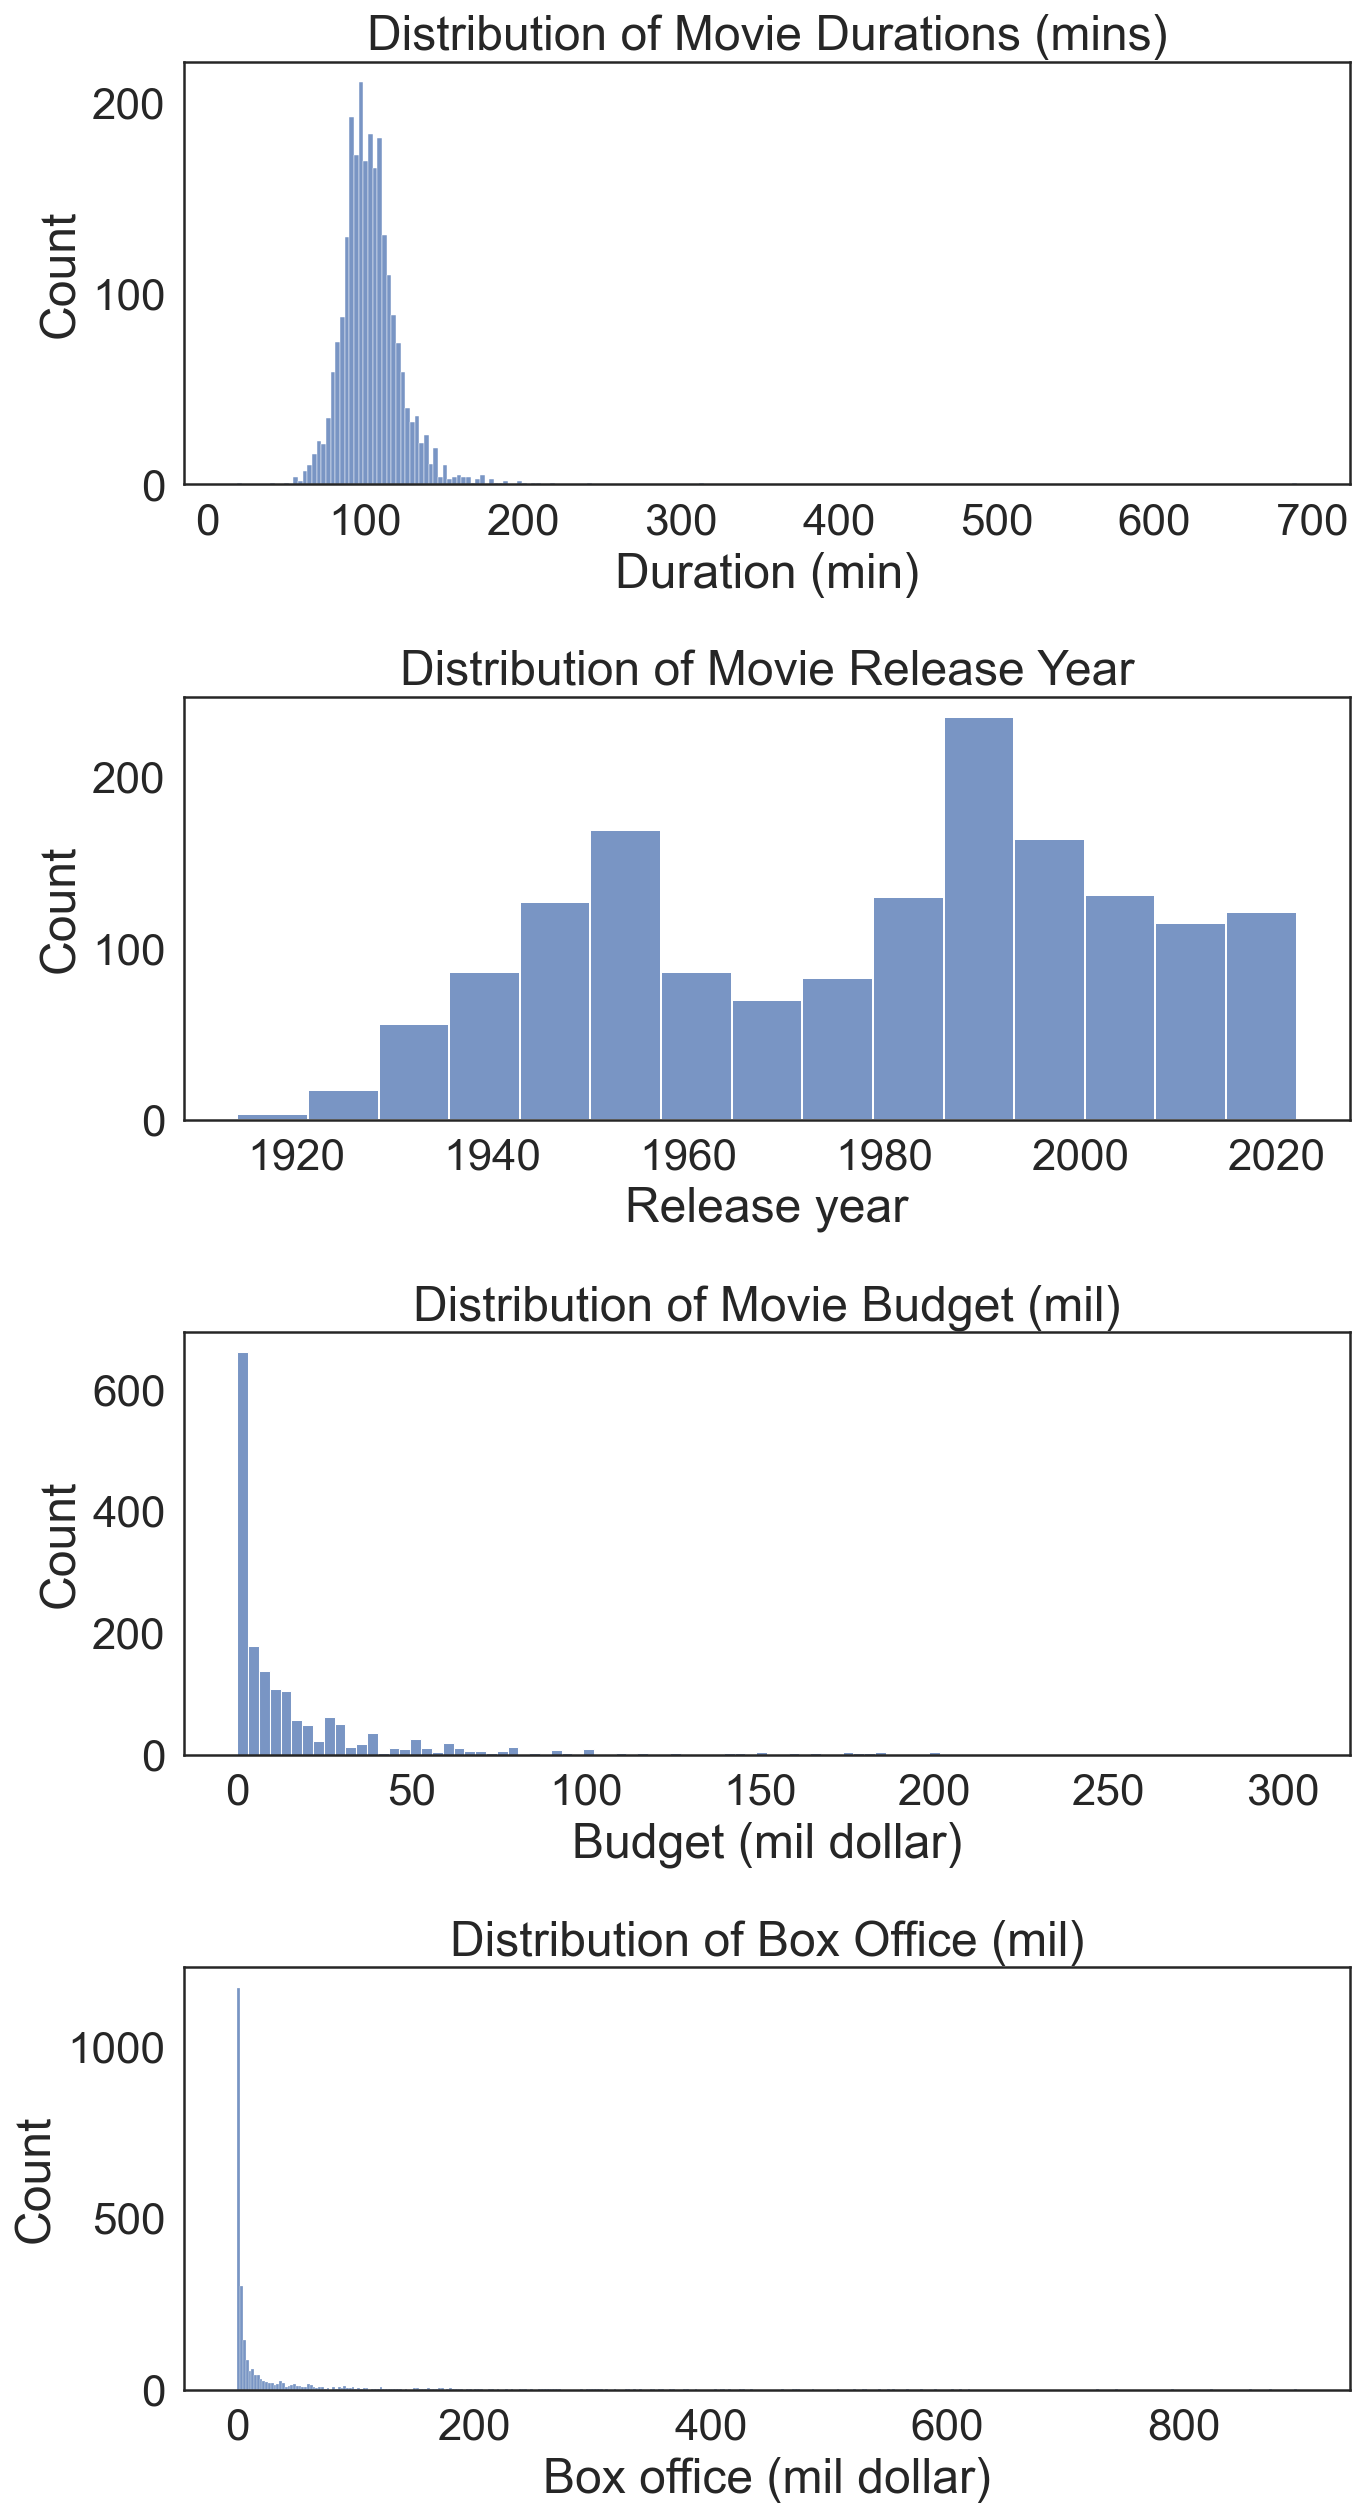

In [19]:
fig, axs = plt.subplots(4,1, figsize=(10,18))

sns.histplot(quant['Duration (min)'], ax=axs[0]).set(title='Distribution of Movie Durations (mins)')
sns.histplot(quant['Release year'], ax=axs[1]).set(title='Distribution of Movie Release Year')
sns.histplot(quant['Budget (mil dollar)'], ax=axs[2]).set(title='Distribution of Movie Budget (mil)')
sns.histplot(quant['Box office (mil dollar)'], ax=axs[3]).set(title='Distribution of Box Office (mil)')

plt.tight_layout()
plt.show()

As seen in the histograms, all columns except the release year column contain outliers. Specifically for budget and box office distributions, they both look similar and are both heavily skewed to the right.

Removing ouliers shows a clearer distribution.

[Text(0.5, 1.0, 'Distribution of Movie Budget (mil)')]

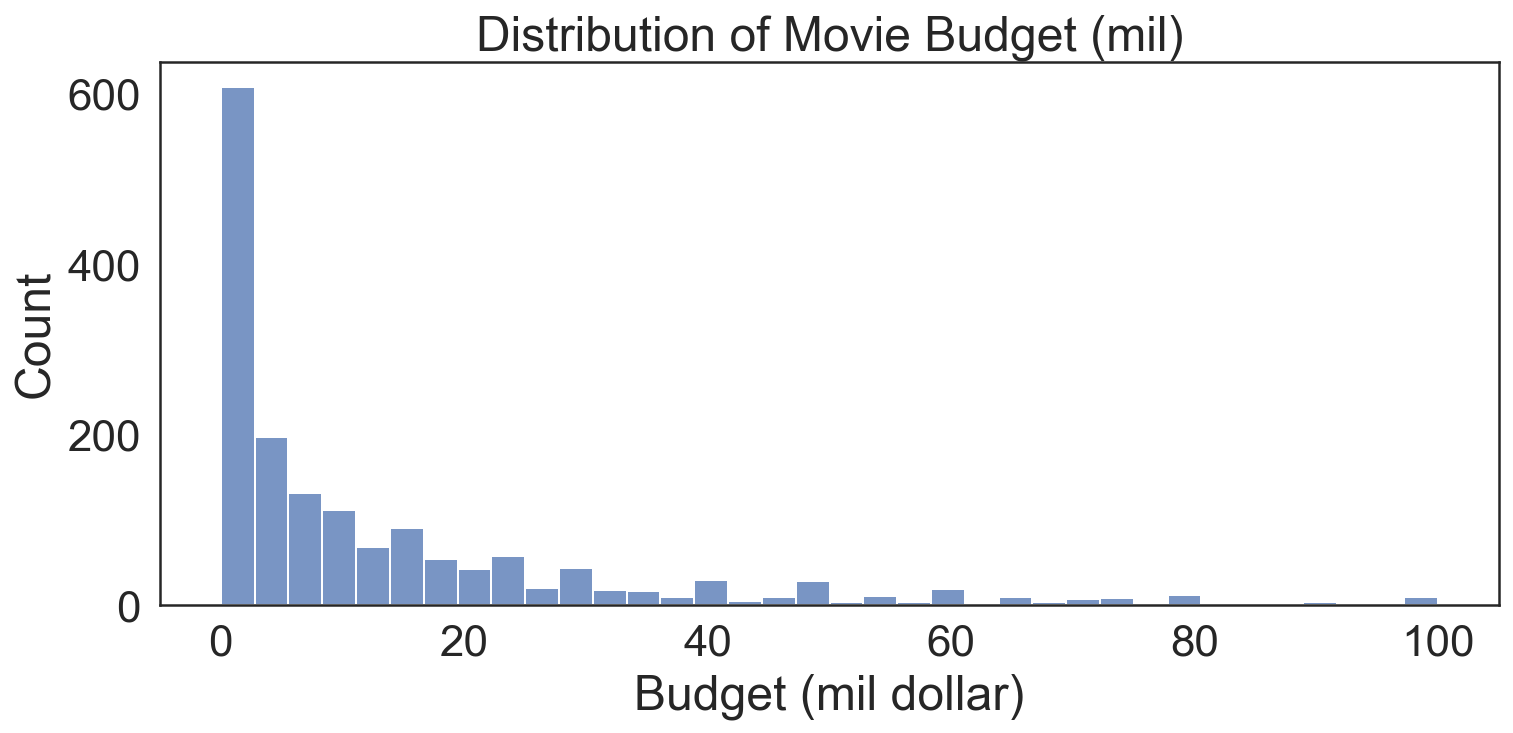

In [20]:
#Budget distribution with outliers removed
sns.histplot(quant[quant['Budget (mil dollar)'] <= 100]['Budget (mil dollar)']).set(title='Distribution of Movie Budget (mil)')


By only plotting the distribution of movies with budgets less than or equal to 100 million dollars, we can see that most movies have budgets under 20 million dollars. This also realistically makes sense given that a higher budget would neccessitate a greater box office to return a profit.

[Text(0.5, 1.0, 'Distribution of Box Office (mil)')]

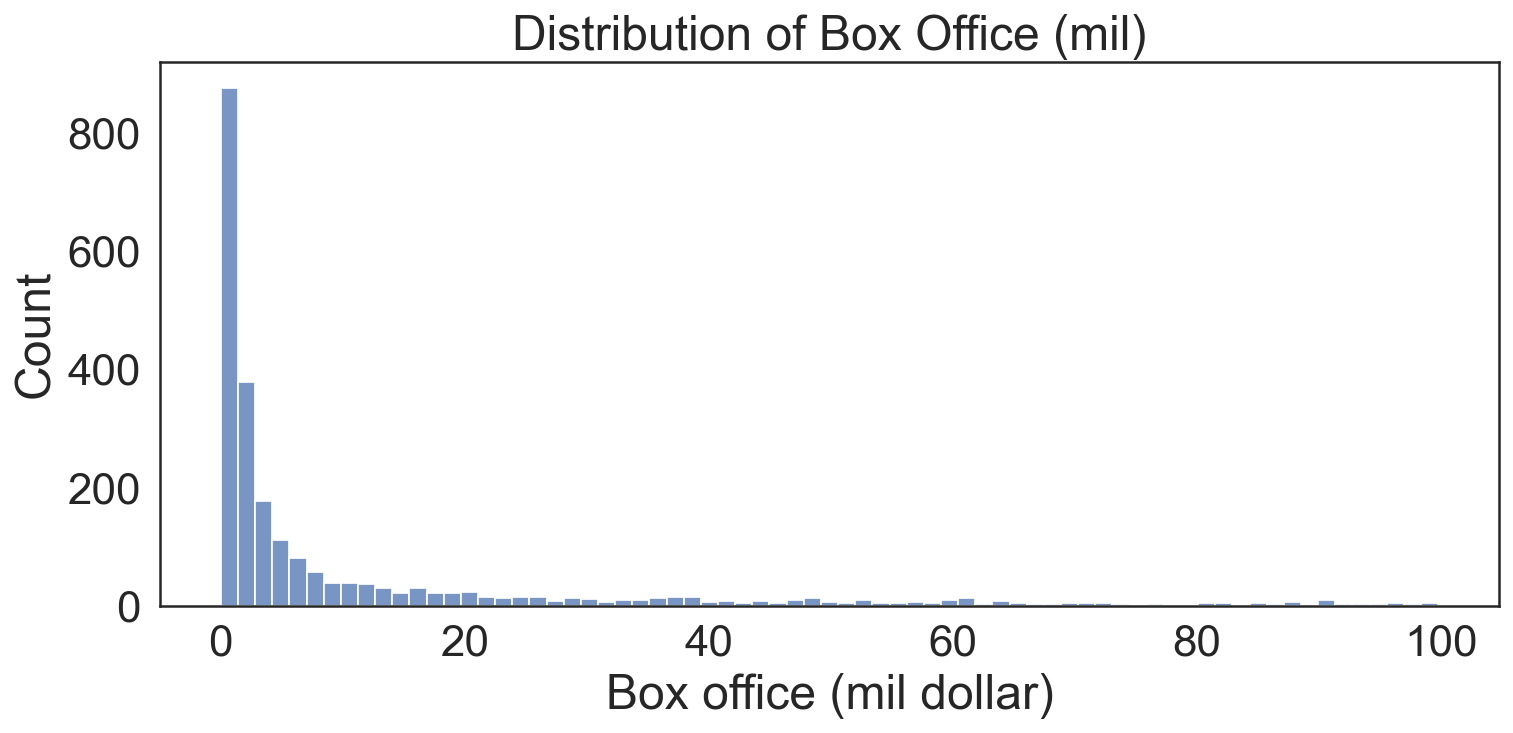

In [21]:
#Box Office distribution with outliers removed
sns.histplot(quant[quant['Box office (mil dollar)'] <= 100]['Box office (mil dollar)']).set(title='Distribution of Box Office (mil)')


Applying the same threshold to the box office data yields a distribution that looks similar to the budget distribution. This could suggest a relationship between movie budget and its respective box office amount.

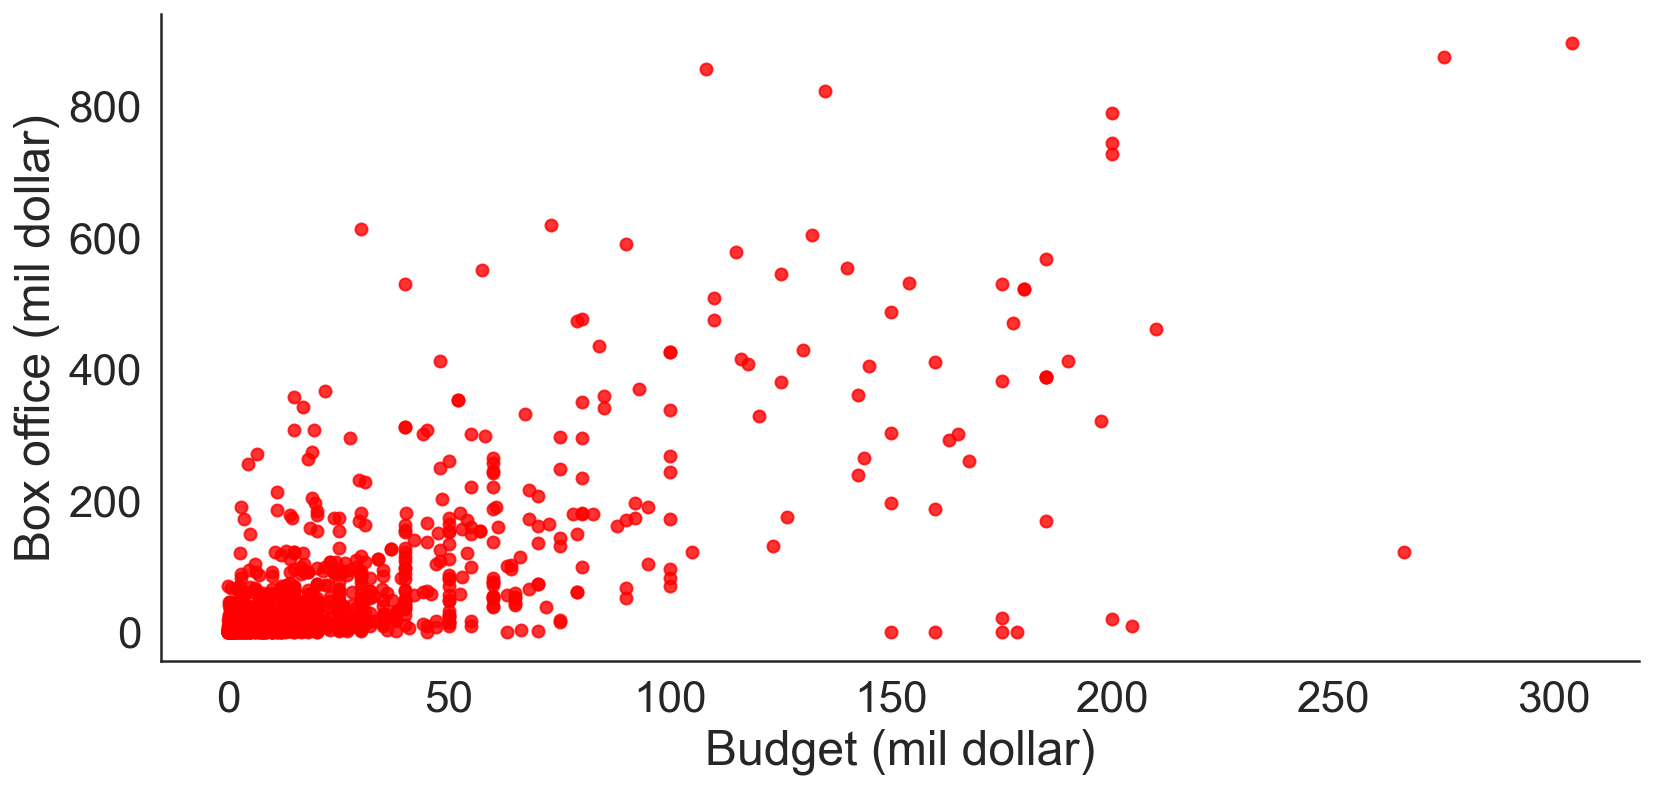

In [22]:
#Scatterplot comparing Budget and Box office (in millions)
sns.lmplot(x='Budget (mil dollar)', y='Box office (mil dollar)',data=quant, fit_reg=False, height=6,aspect=2, scatter_kws={'color':'red'})


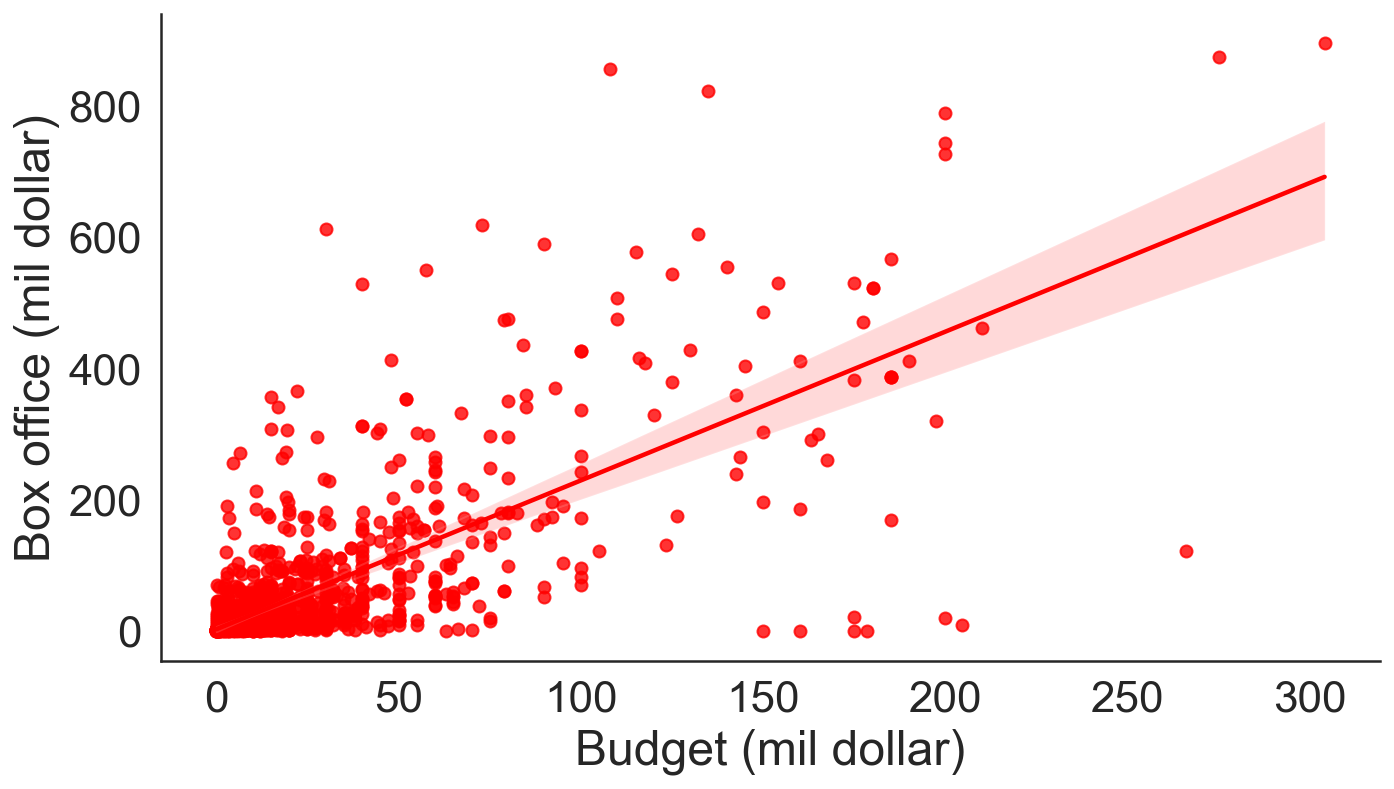

In [23]:
#Scatterplot with regression line
sns.lmplot(x='Budget (mil dollar)', y='Box office (mil dollar)',data=quant, fit_reg=True, height=6,aspect=1.7,line_kws={'color':'red'},scatter_kws={'color':'red'})


Plotting the Budget versus the Box office values of all the movies shows a rough positive correlation between budget and box office. However, this cannot imply causation given that there is lots of noise and outliers. The positive correlation line plotted is most likely due to the clustering of a large majority of the dataset under $100 million in both budget and box office.

So while there is technically a positive correlation between budget and box office, no correlation relationship can be deduced from the given dataset.

Furthermore, restricting the plot to data that falls below $100 million does not improve the regression line nor further imply a relationship given that outliers exist at an even higher frequency as the budget and box office decreases.

**Another interesting question to investigate is whether more recent movies are more popular. A way that this can be explored is by plotting the Box Office amount to the Release year of the movie.**

<AxesSubplot:xlabel='Release year', ylabel='Box office (mil dollar)'>

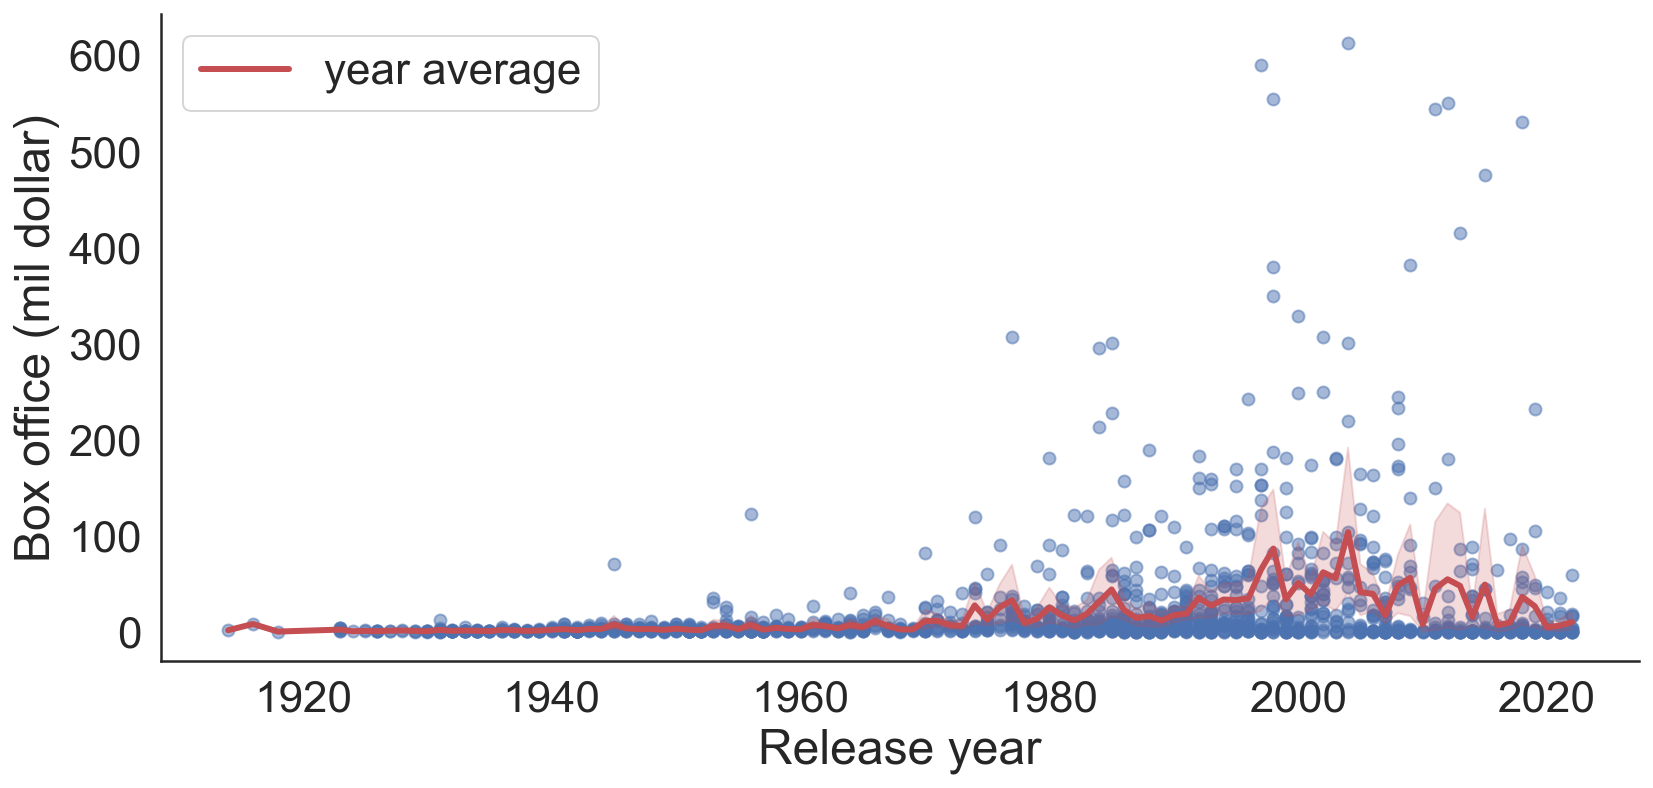

In [184]:
#Release year versus Box Office
sns.lmplot(x='Release year', y='Box office (mil dollar)' ,data=quant, fit_reg=False, height=6, aspect=2, scatter_kws={'alpha':0.5})
sns.lineplot(data=df, x='Release year', y='Box office (mil dollar)', color='r', label='year average', linewidth=3)

When plotted as a scatterplot, we can see that the highest box office values exist solely in the 2000s or later which can imply the increased popularity of recent movies. This also makes sense given the greater interconnectivety of modern society within the past 20 years.

# How many genres are there in our dataset?

In [25]:
genres = df['Genre'].value_counts()

<AxesSubplot:>

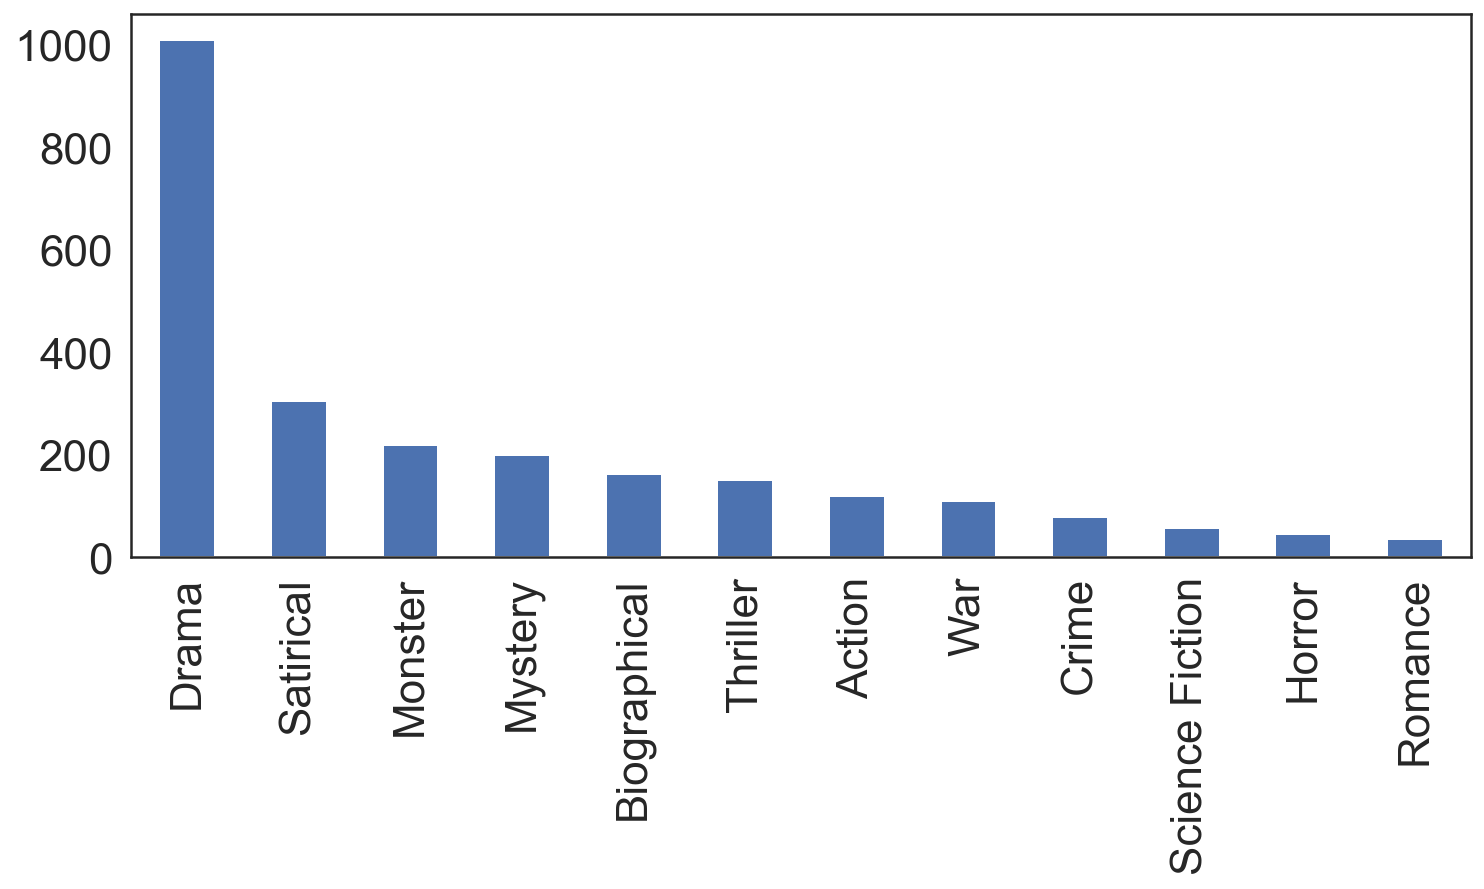

In [26]:
genres.plot.bar()

# Which genres perform much better in box office? 
In order to answer this question, we will need to calculate the mean box office for each genre, and z-transform the mean box office.

In [27]:
# Prepare a dataframe 
df2 = df[['Genre','Box office (mil dollar)']]
total_mean = df2['Box office (mil dollar)'].mean()
genres = ['Drama','Satirical','Monster','Monster','Mystery','Biographical','Thriller','Action','War','Crime','Science Fiction','Horror','Romance']
new = pd.DataFrame(columns=['Genres','Box Office'])



#A function that takes a list of box office stats and calculate the z score
def z_score_table(genre):
    
    new = pd.DataFrame(columns=['Genres','Mean Box Office'])
    for items in genre:

        New_Genre = df2[df2['Genre'] == items]
        New_Genre_mean = New_Genre['Box office (mil dollar)'].mean()
        #print(New_Genre_mean)
        dict = {'Genres': items, 'Mean Box Office': [New_Genre_mean]}
        row = pd.DataFrame(dict)
        new = pd.concat([new,row])


    return new

df3 = z_score_table(genres)
df3['Box Office Z-Score'] = zscore(df3['Mean Box Office'])
df3 = df3.sort_values(by='Box Office Z-Score', ascending=False)

We'll compare z-scores using a bar chart for easier comparison in vlaues.

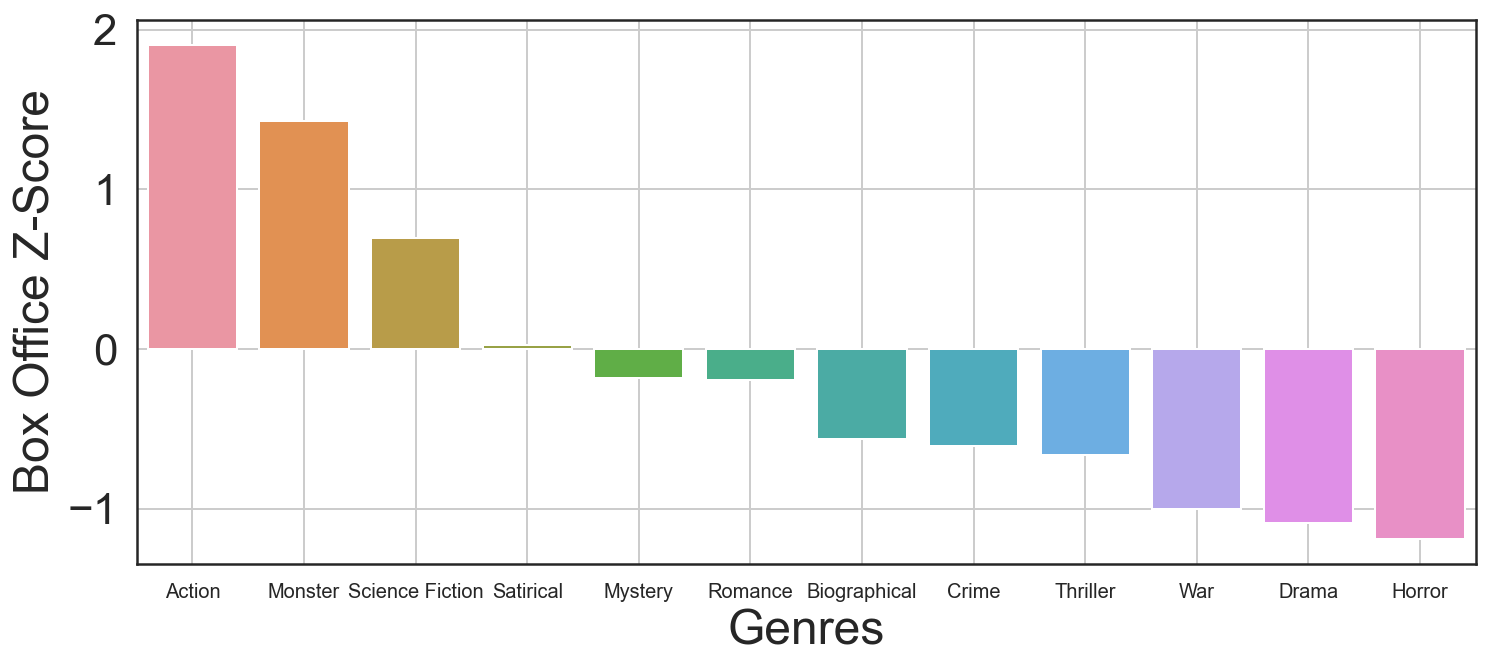

In [28]:
# plotting the z score
ax = sns.barplot(data=df3, x="Genres", y="Box Office Z-Score")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
plt.grid()
plt.show()

We can see that Action movies does perform better than other genres. The second runner up are Monster movies and science fiction. While Drama and Horror films does the poorest in box office. 

### What are the trends for profits across the Years with different movie genres?

We first extract the Genre, Year and the Box Office Column

In [37]:
df4 = df[['Genre', 'Release year', 'Box office (mil dollar)']]
df4

Genre  Release year  Box office (mil dollar)
0     Action        2020.0                 0.012604
1     Action           NaN                17.300000
2     Action        2021.0                 0.067413
3     Action           NaN                 2.500000
4     Action        1985.0                10.499694
...      ...           ...                      ...
2489   Drama        2016.0                 7.300000
2490   Drama        1959.0                 2.800000
2491   Drama           NaN                 1.000000
2492   Drama        2003.0                 0.008466
2493   Drama           NaN                 0.002418

[2494 rows x 3 columns]

We want to analyse the year of the release dates. So let's clean up the data.
First, Drop any blank rows

In [38]:
df4 = df4.dropna()
df4

Genre  Release year  Box office (mil dollar)
0     Action        2020.0                 0.012604
2     Action        2021.0                 0.067413
4     Action        1985.0                10.499694
5     Action        1987.0                 4.000000
6     Action        1989.0                 1.556606
...      ...           ...                      ...
2486   Drama        2014.0                 0.894964
2487   Drama        2003.0                 9.638389
2489   Drama        2016.0                 7.300000
2490   Drama        1959.0                 2.800000
2492   Drama        2003.0                 0.008466

[1593 rows x 3 columns]

Again, we will calculate the mean box office of all the genres in the df. However, this time we will calculate the mean based on the year. Combine all means into a new dataframe.

In [44]:
def calculate_mean(Genre, new):
    # Select all that are from year 2020
    df_action = df4[df4['Genre'] == Genre]
    year_list = df_action['Release year'].unique()

    for years in year_list:
        df_action_year = df_action[df_action['Release year'] == years]
        genre_year_mean = df_action_year['Box office (mil dollar)'].mean()
        dict_2 = {'Genres': Genre, 'Mean Box Office': [genre_year_mean], 'year': years}
        #Create new dataframe
        row = pd.DataFrame(dict_2)
        new = pd.concat([new,row])

    return new

In [45]:
genre_list = df4['Genre'].unique()
new = pd.DataFrame(columns=['Genres','Mean Box Office','year'])
for genre in genre_list:
    new = calculate_mean(genre,new) 
new

Genres  Mean Box Office    year
0   Action         0.176207  2020.0
0   Action         0.059791  2021.0
0   Action        96.474923  1985.0
0   Action         5.367081  1987.0
0   Action        17.371321  1989.0
..     ...              ...     ...
0    Drama         1.615000  1968.0
0    Drama        24.987600  1995.0
0    Drama         0.676559  1935.0
0    Drama         0.938000  1926.0
0    Drama         4.000000  1971.0

[607 rows x 3 columns]

Below we'll plot the box office trends based on different genres in several time periods. Namely 1980-1989, 1990-1999, 2000-2009, 2010-2020. A line plot allows us to analyse trends easily

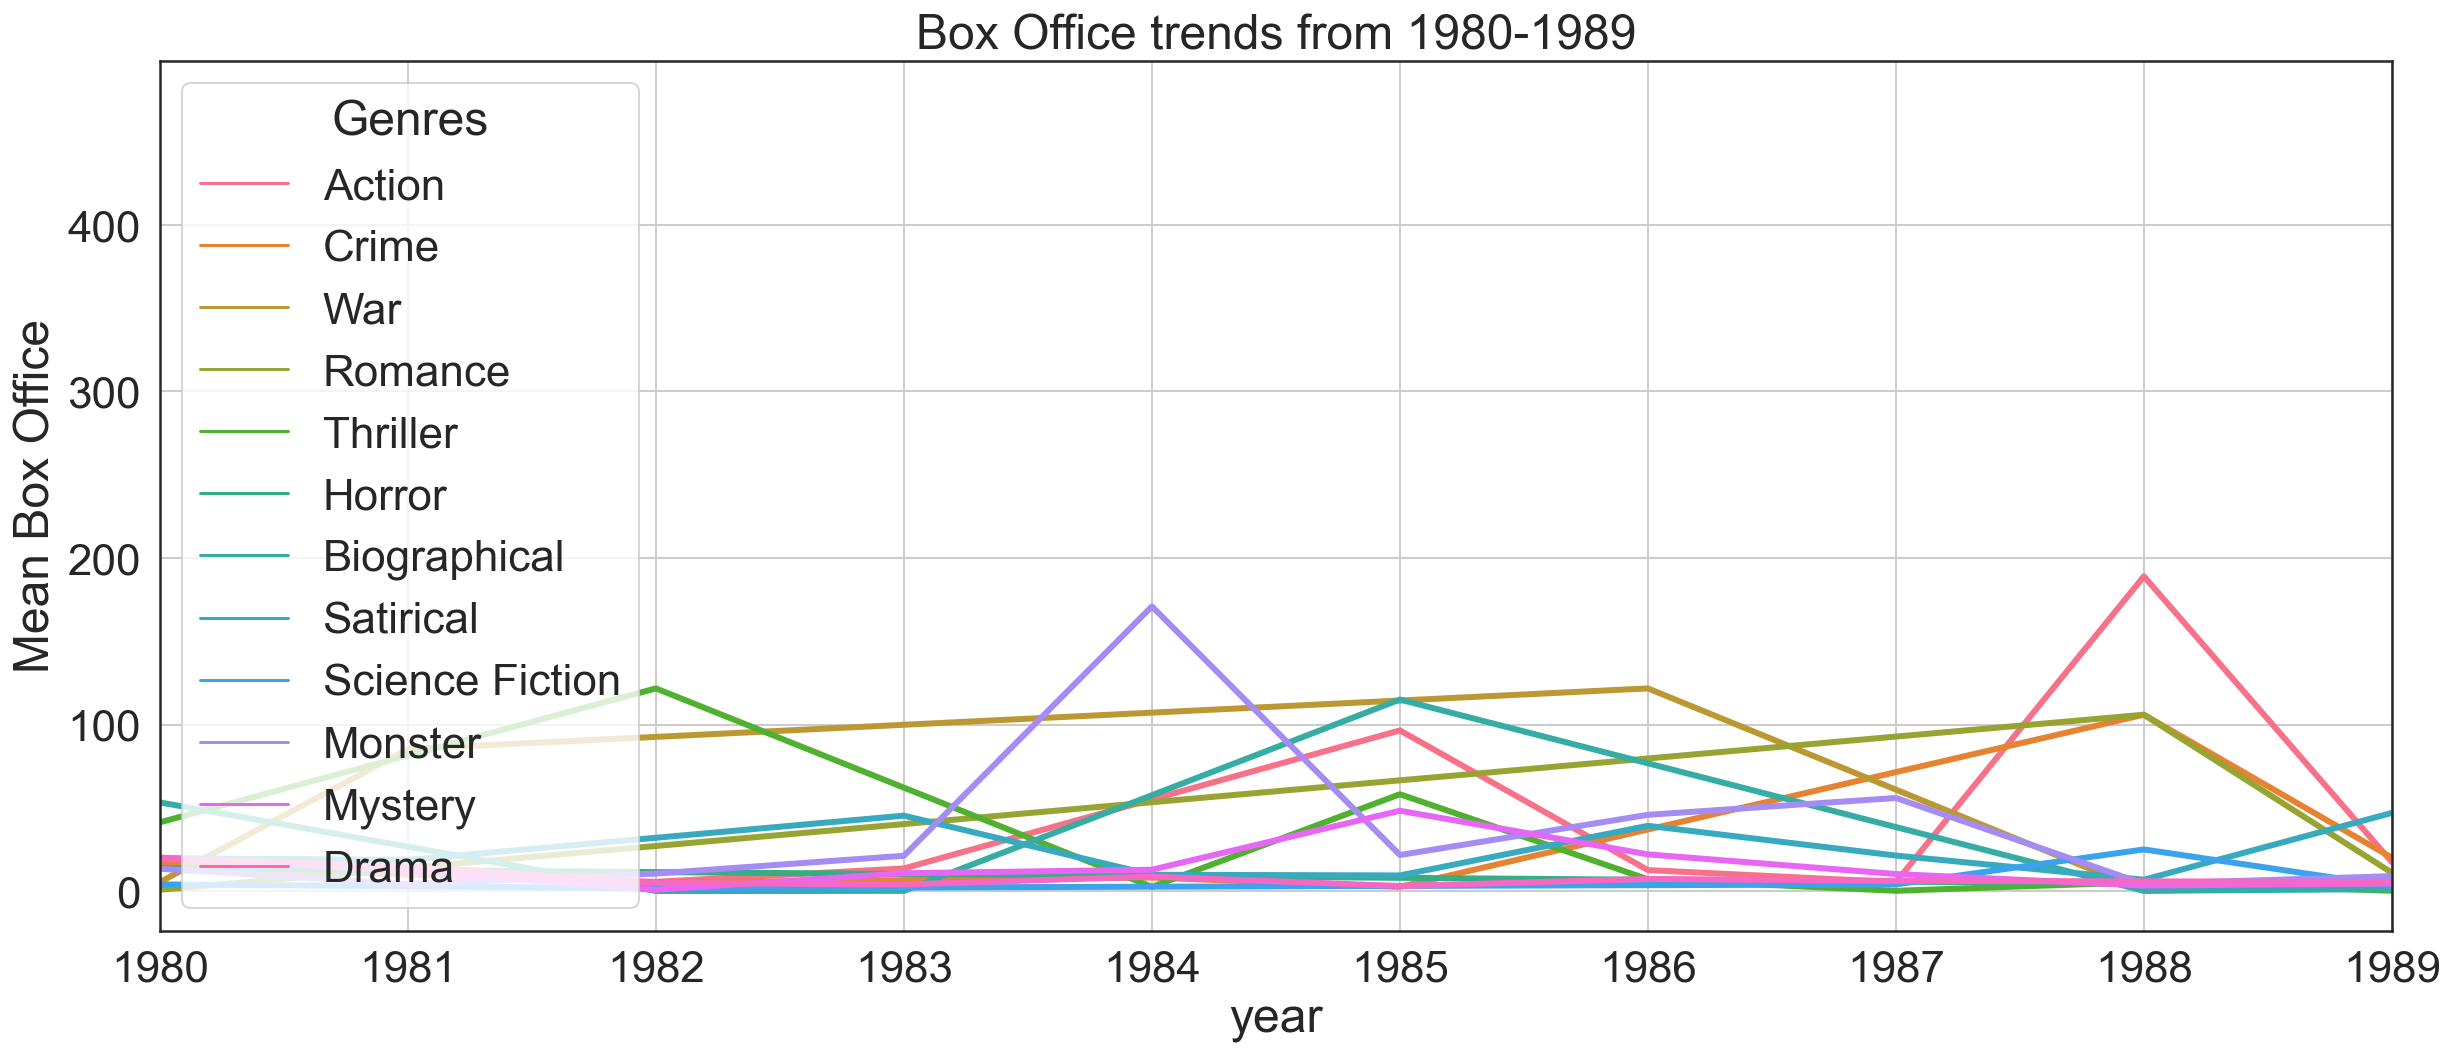

In [46]:
f4, ax = plt.subplots(figsize =(20, 8))
plt.xlim(1980, 1989)
f4 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief',linewidth=3).set(title="Box Office trends from 1980-1989")
plt.grid()

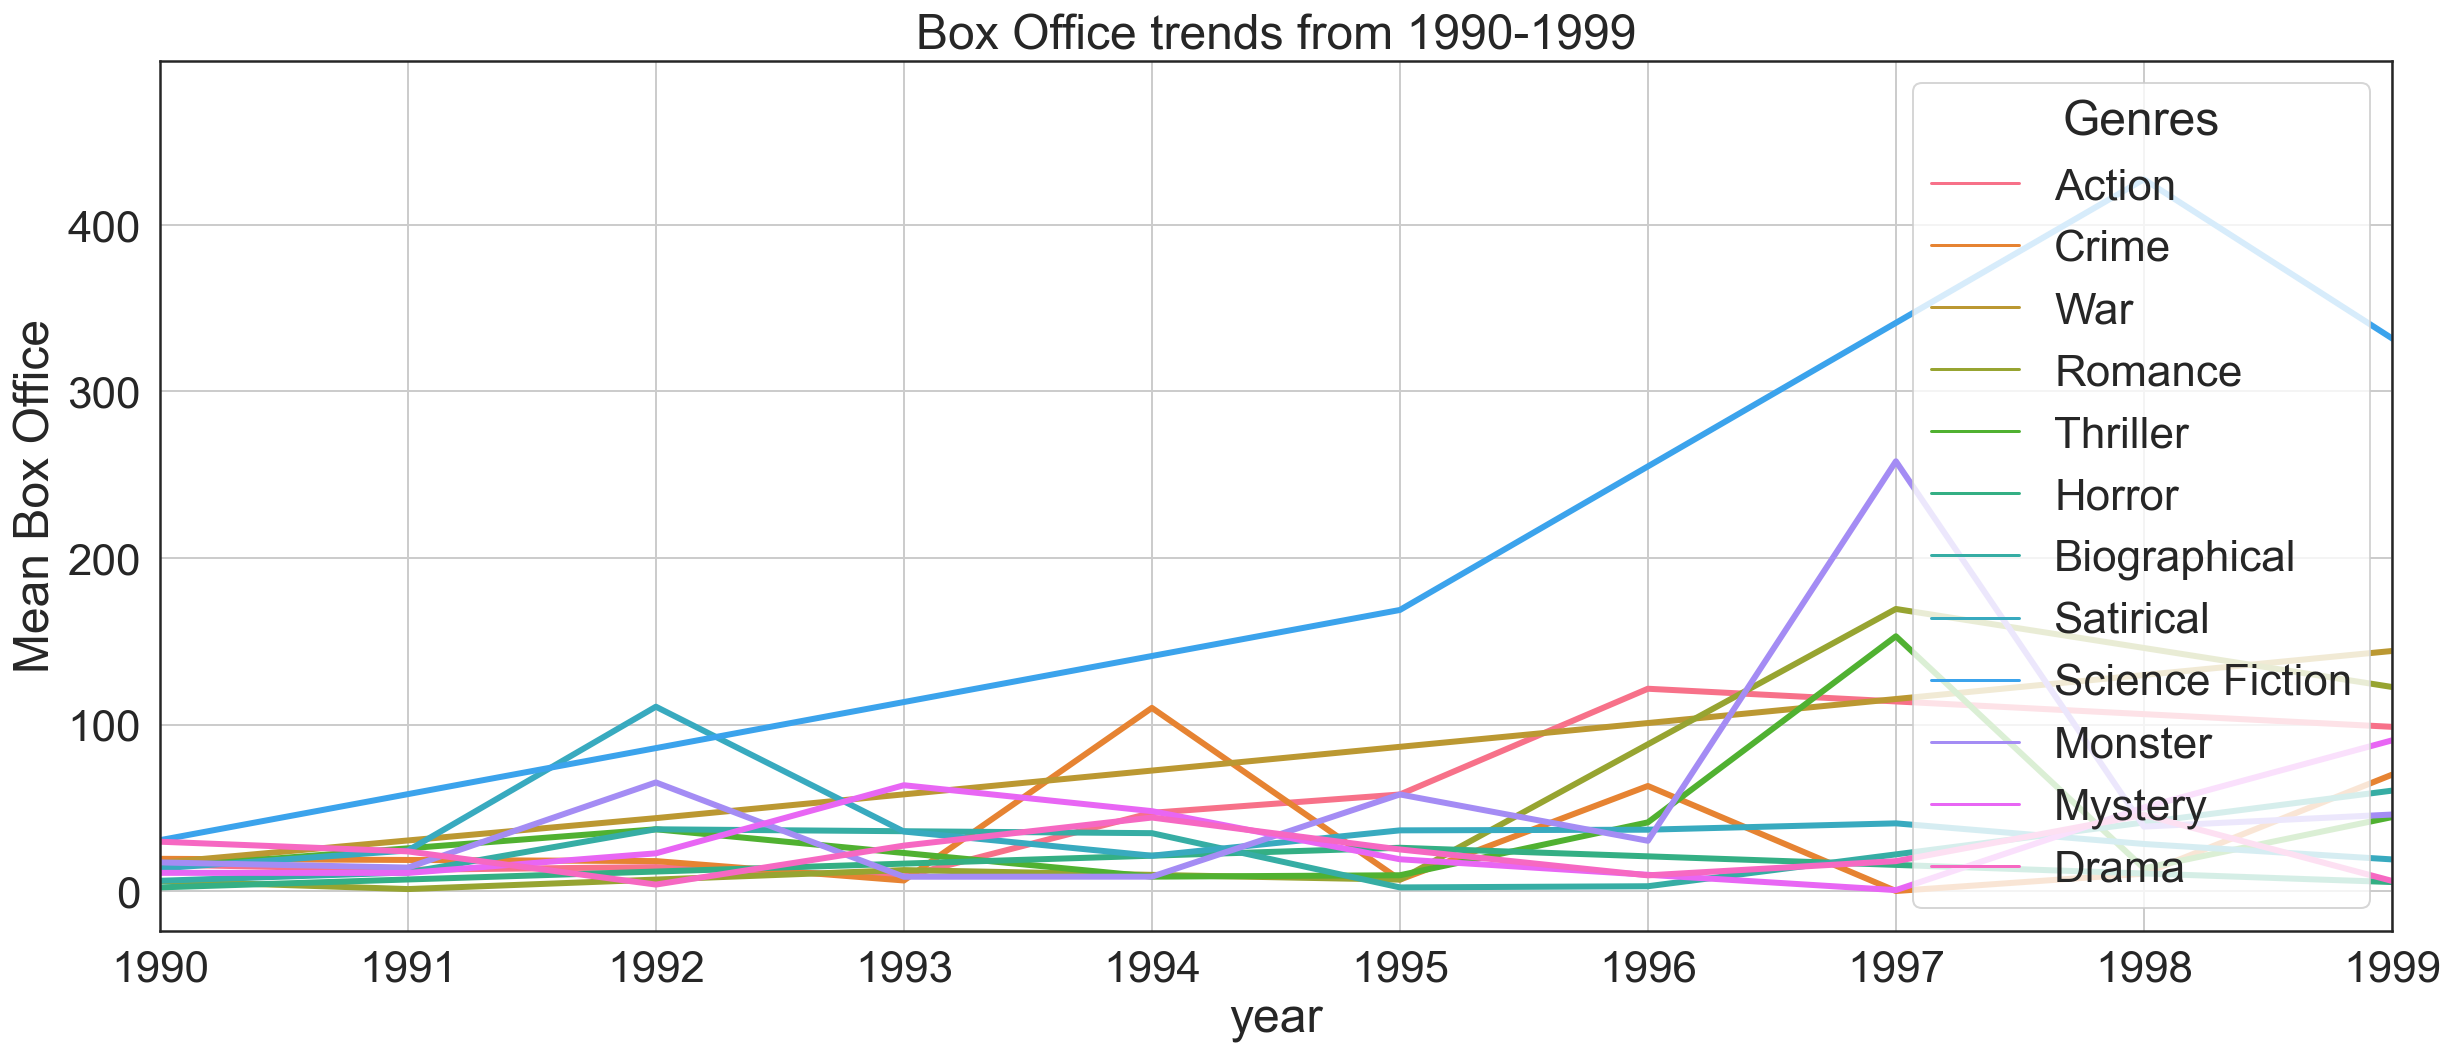

In [47]:
f3, ax = plt.subplots(figsize =(20, 8))
plt.xlim(1990, 1999)
f3 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief', linewidth=3).set(title="Box Office trends from 1990-1999")
plt.grid()

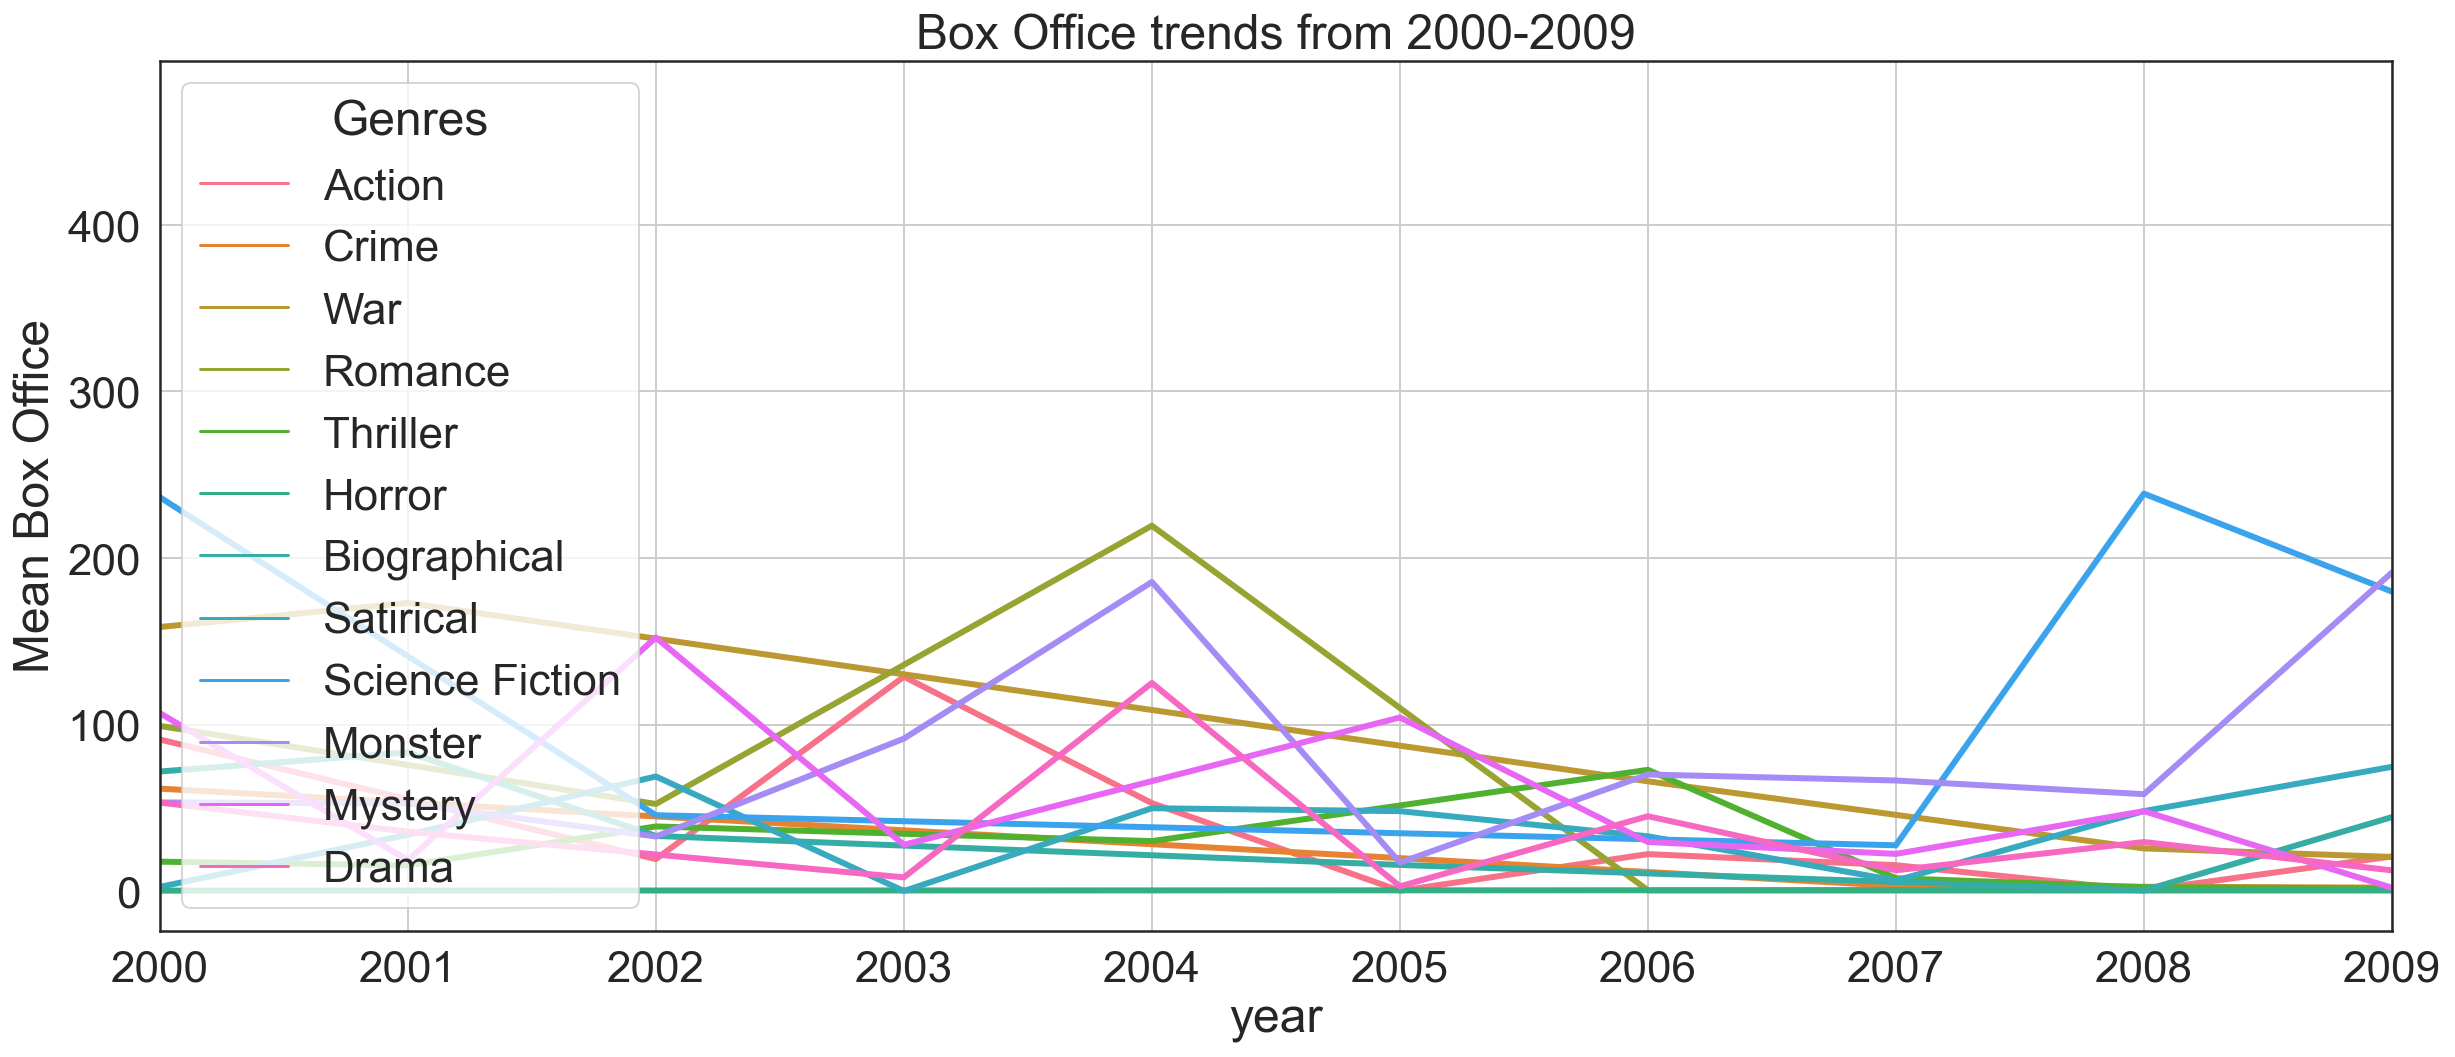

In [48]:
f2, ax = plt.subplots(figsize =(20, 8))
plt.xlim(2000, 2009)
f2 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief',linewidth=3).set(title="Box Office trends from 2000-2009")
plt.grid()

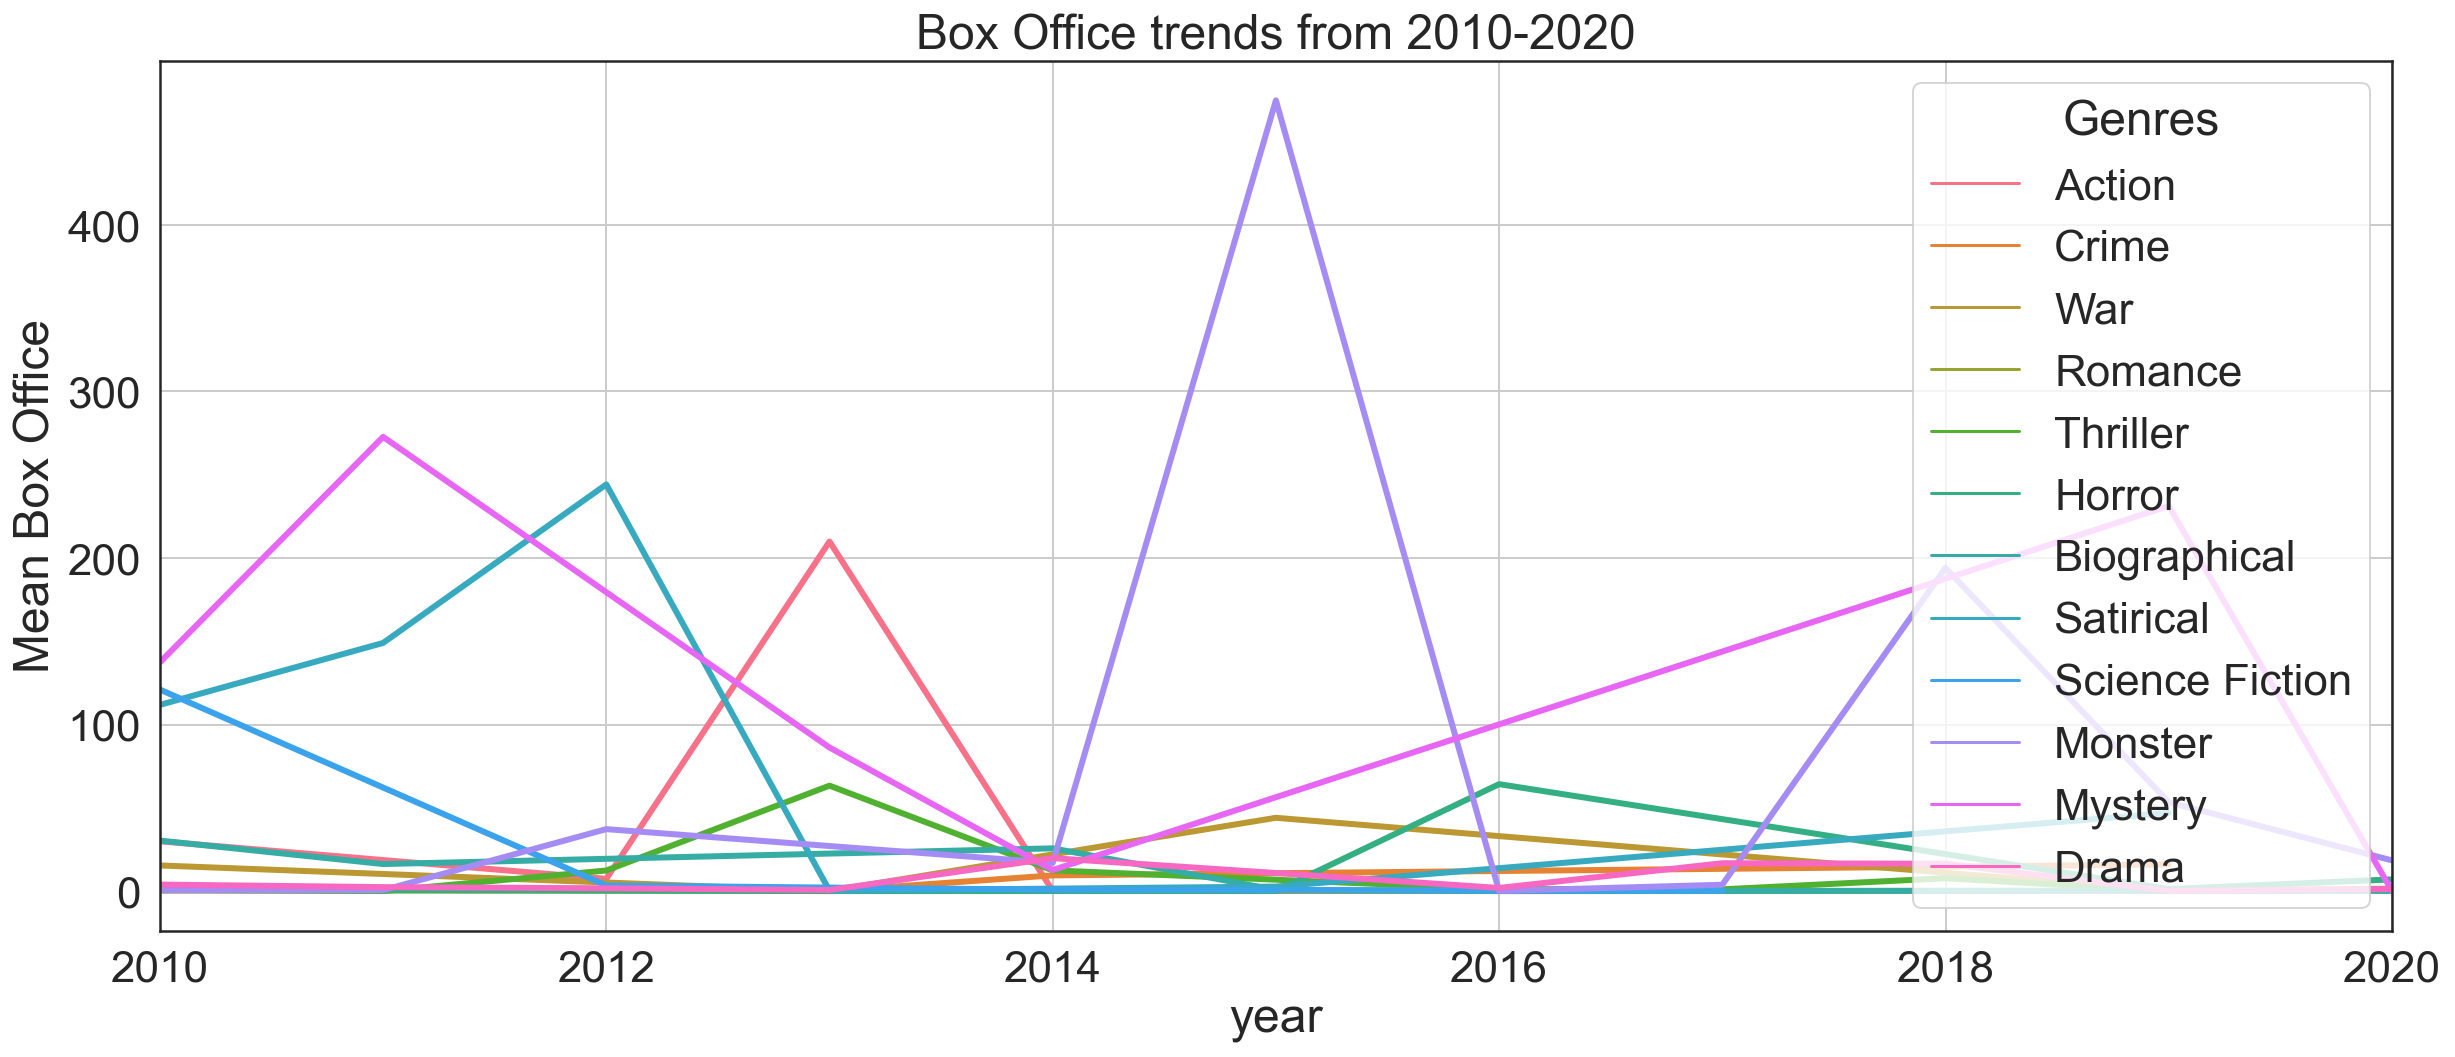

In [49]:
f1, ax = plt.subplots(figsize =(20, 8))
plt.xlim(2010, 2020)
f1 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief',linewidth = 3).set(title="Box Office trends from 2010-2020")
plt.grid()

As we can see, Science Fiction films have high box office in the 1990s and 2000s but box office dropped in the 2010s. And Monsters film were on the rise since 1990s and peaked at 2010s. In the 2010s, Mystery films increased in box office compared to other eras.

### How does the movie plot correlate with box office?

What are the distributions of the attributes (e.g. word count, character count, parts of speech count) of the plot text and do they have relationships with other variables?

In [50]:
# get attributes of each plot
char_count = []
word_count = []
box_office = []
punct_count = []
upper_count = []
sent_count = []

for i in range(len(df)):
    text = df.loc[i]['Plot']
    # number of characters
    char_count.append(len(text))
    # number of words
    word_count.append(len(text.split(' ')))
    # box office
    box_office.append(df.loc[i]['Box office (mil dollar)'])
    # number of punctuation
    punct_count.append(len([c for c in text if c in string.punctuation]))
    # number of sentences
    sent_count.append(len(re.findall(r'[.!?]', text)))
    # number of uppercase
    upper_count.append(len(re.findall(r'[A-Z]', text)))

[Text(0.5, 0, 'Number of Characters'),
 Text(0, 0.5, 'Number of Upper Case Letters')]

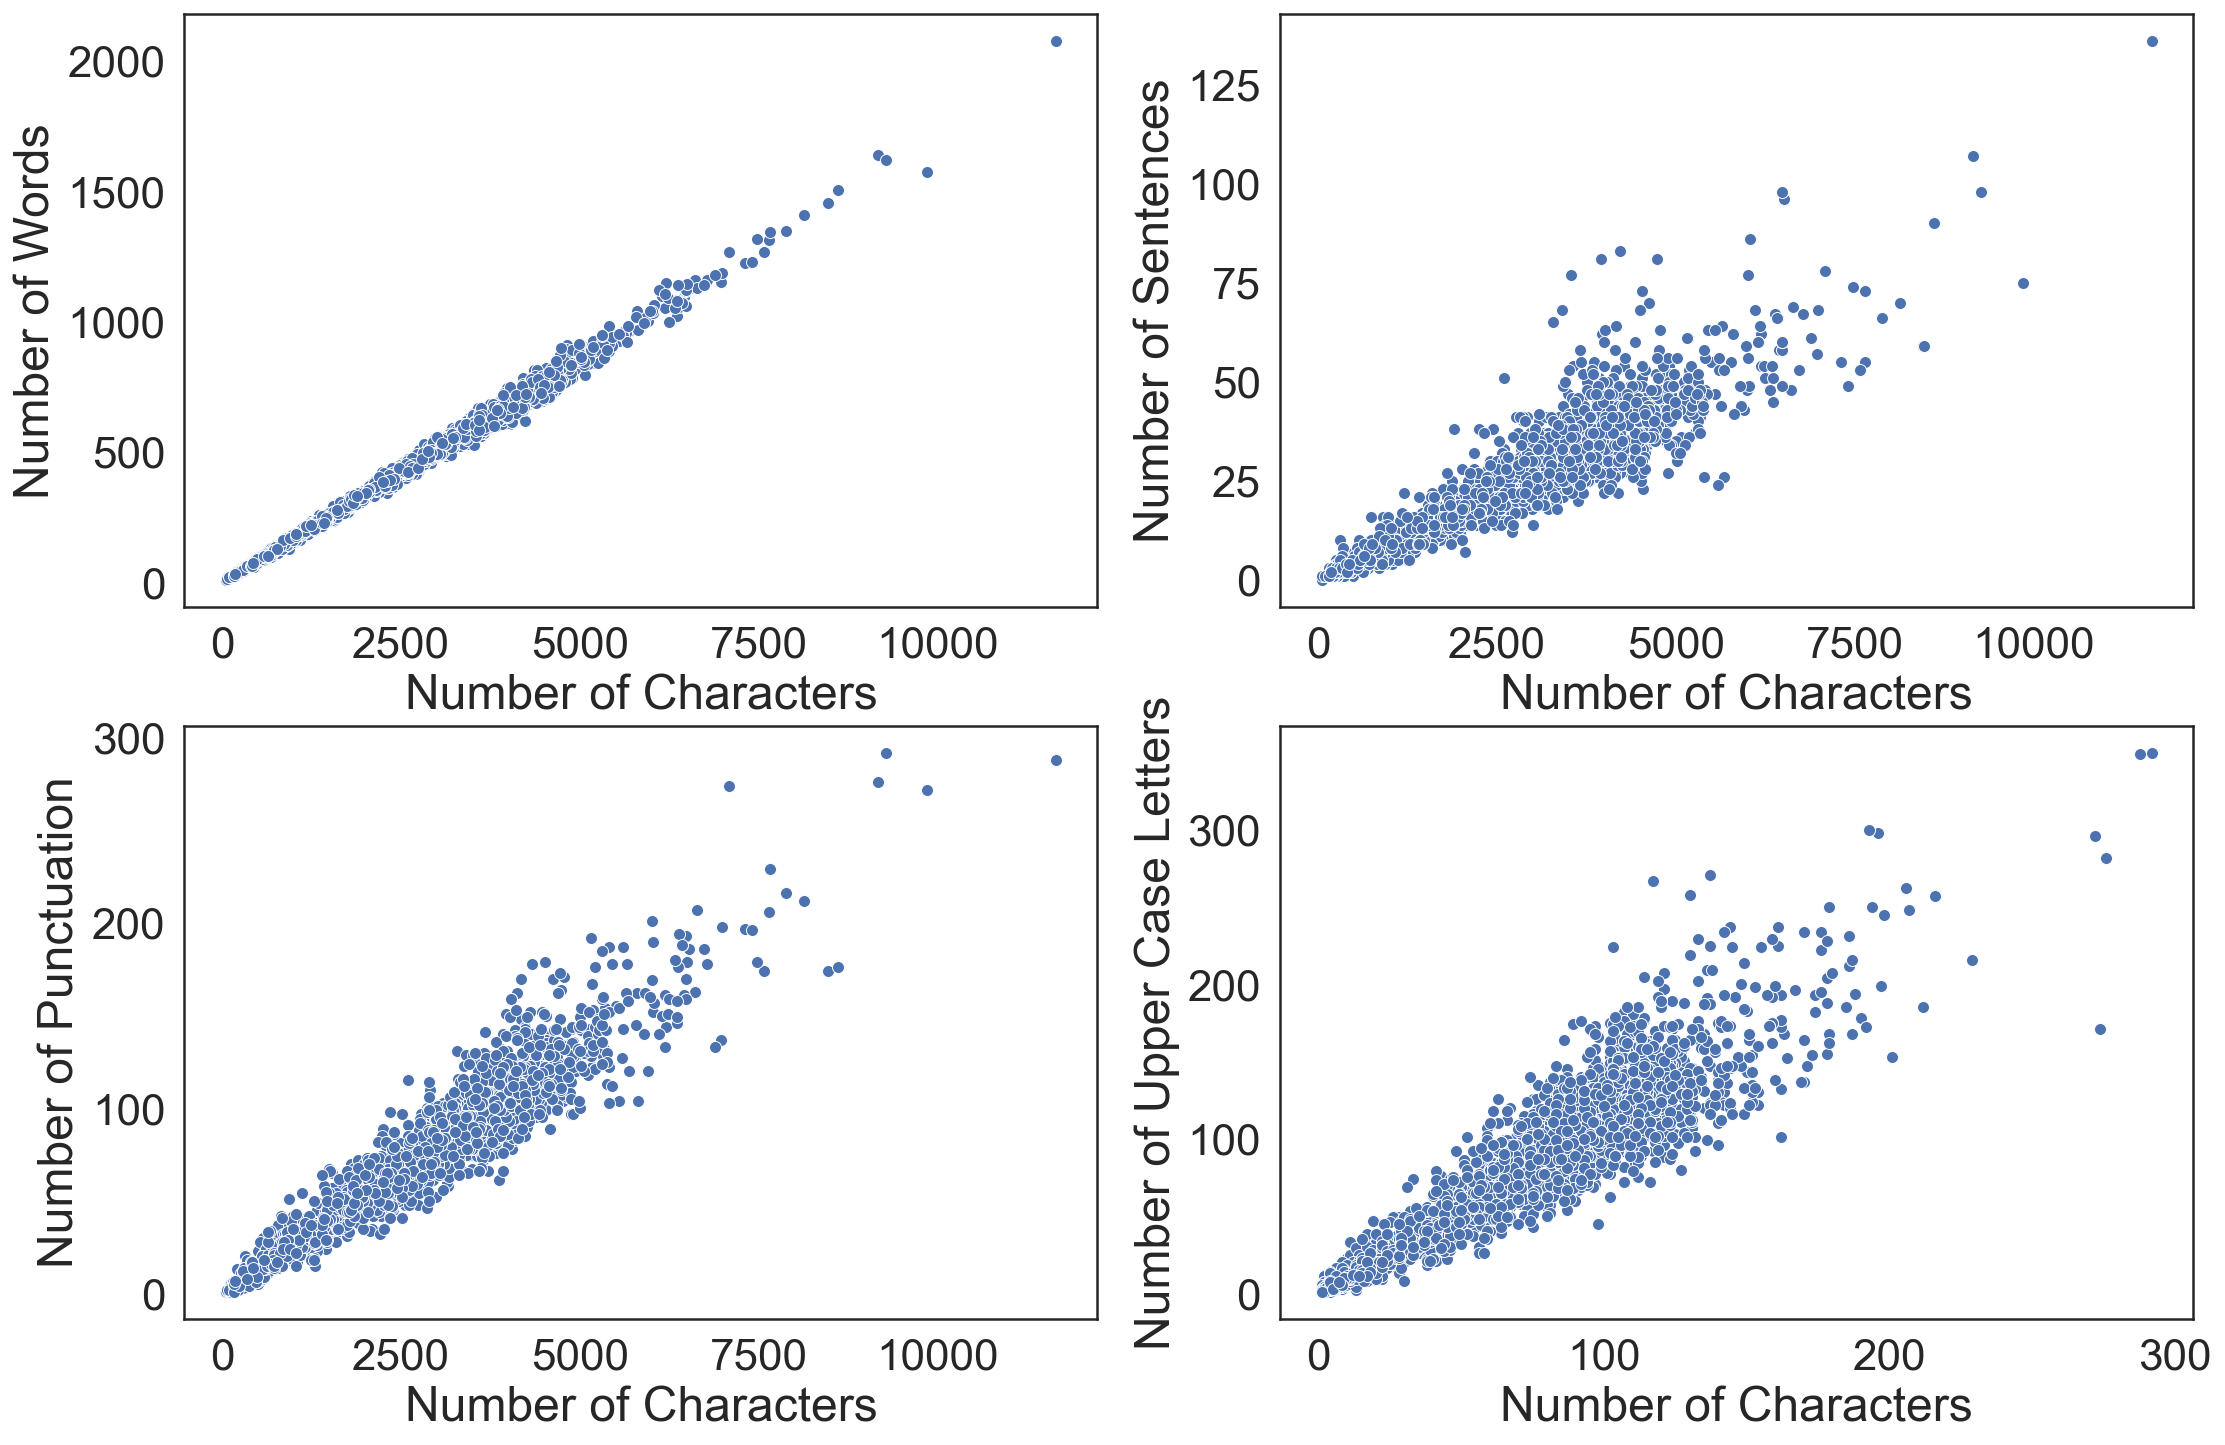

In [51]:
# plot char counts vs other counts
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax1 = sns.scatterplot(x=char_count, y=word_count, ax=ax[0][0])
ax1.set(xlabel='Number of Characters', ylabel='Number of Words')
ax2 = sns.scatterplot(x=char_count, y=punct_count, ax=ax[1][0])
ax2.set(xlabel='Number of Characters', ylabel='Number of Punctuation')
ax3 = sns.scatterplot(x=char_count, y=sent_count, ax=ax[0][1])
ax3.set(xlabel='Number of Characters', ylabel='Number of Sentences')
ax4 = sns.scatterplot(x=punct_count, y=upper_count, ax=ax[1][1])
ax4.set(xlabel='Number of Characters', ylabel='Number of Upper Case Letters')

The attributes of the plot, like the number of characters, words, punctuation, sentences, and uppercase letters are pretty linear to one another. This makes sense as the longer the plot text is, more often will these attributes appear.

<AxesSubplot:ylabel='Count'>

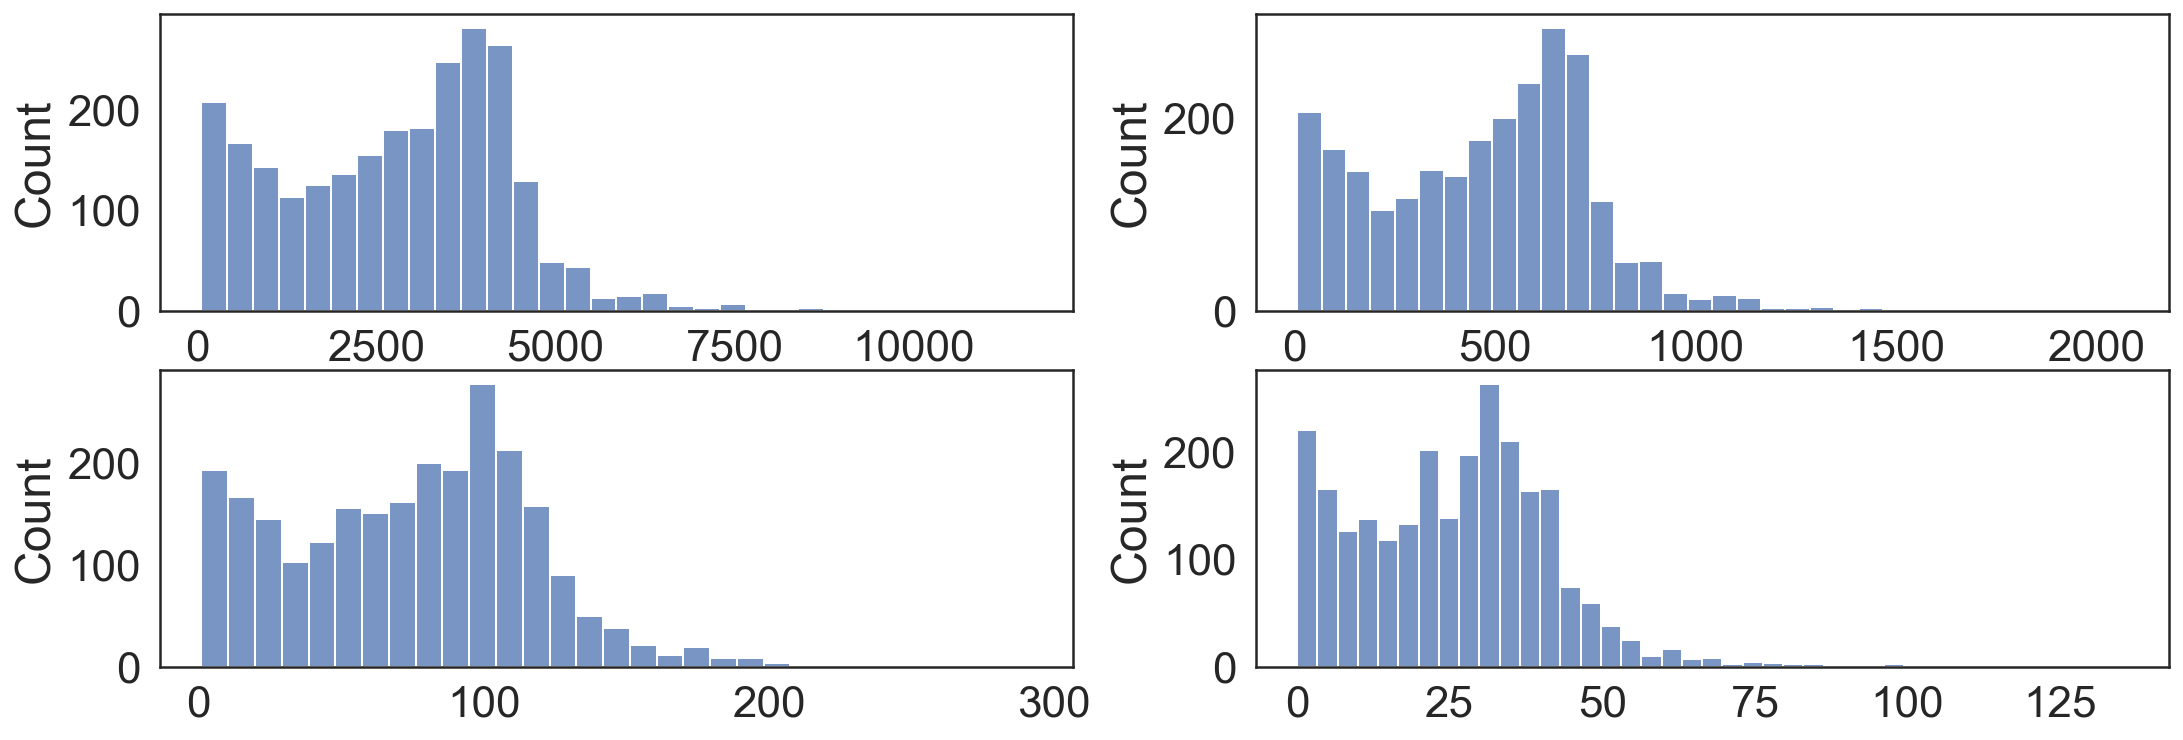

In [52]:
# plot the distribution of count values
fig, ax = plt.subplots(2, 2, figsize=(18, 6))
sns.histplot(char_count, ax=ax[0][0])
sns.histplot(word_count, ax=ax[0][1])
sns.histplot(punct_count, ax=ax[1][0])
sns.histplot(sent_count, ax=ax[1][1])


Being pretty linear to one another, it is not surprising that the distributions of these counts look very similar.

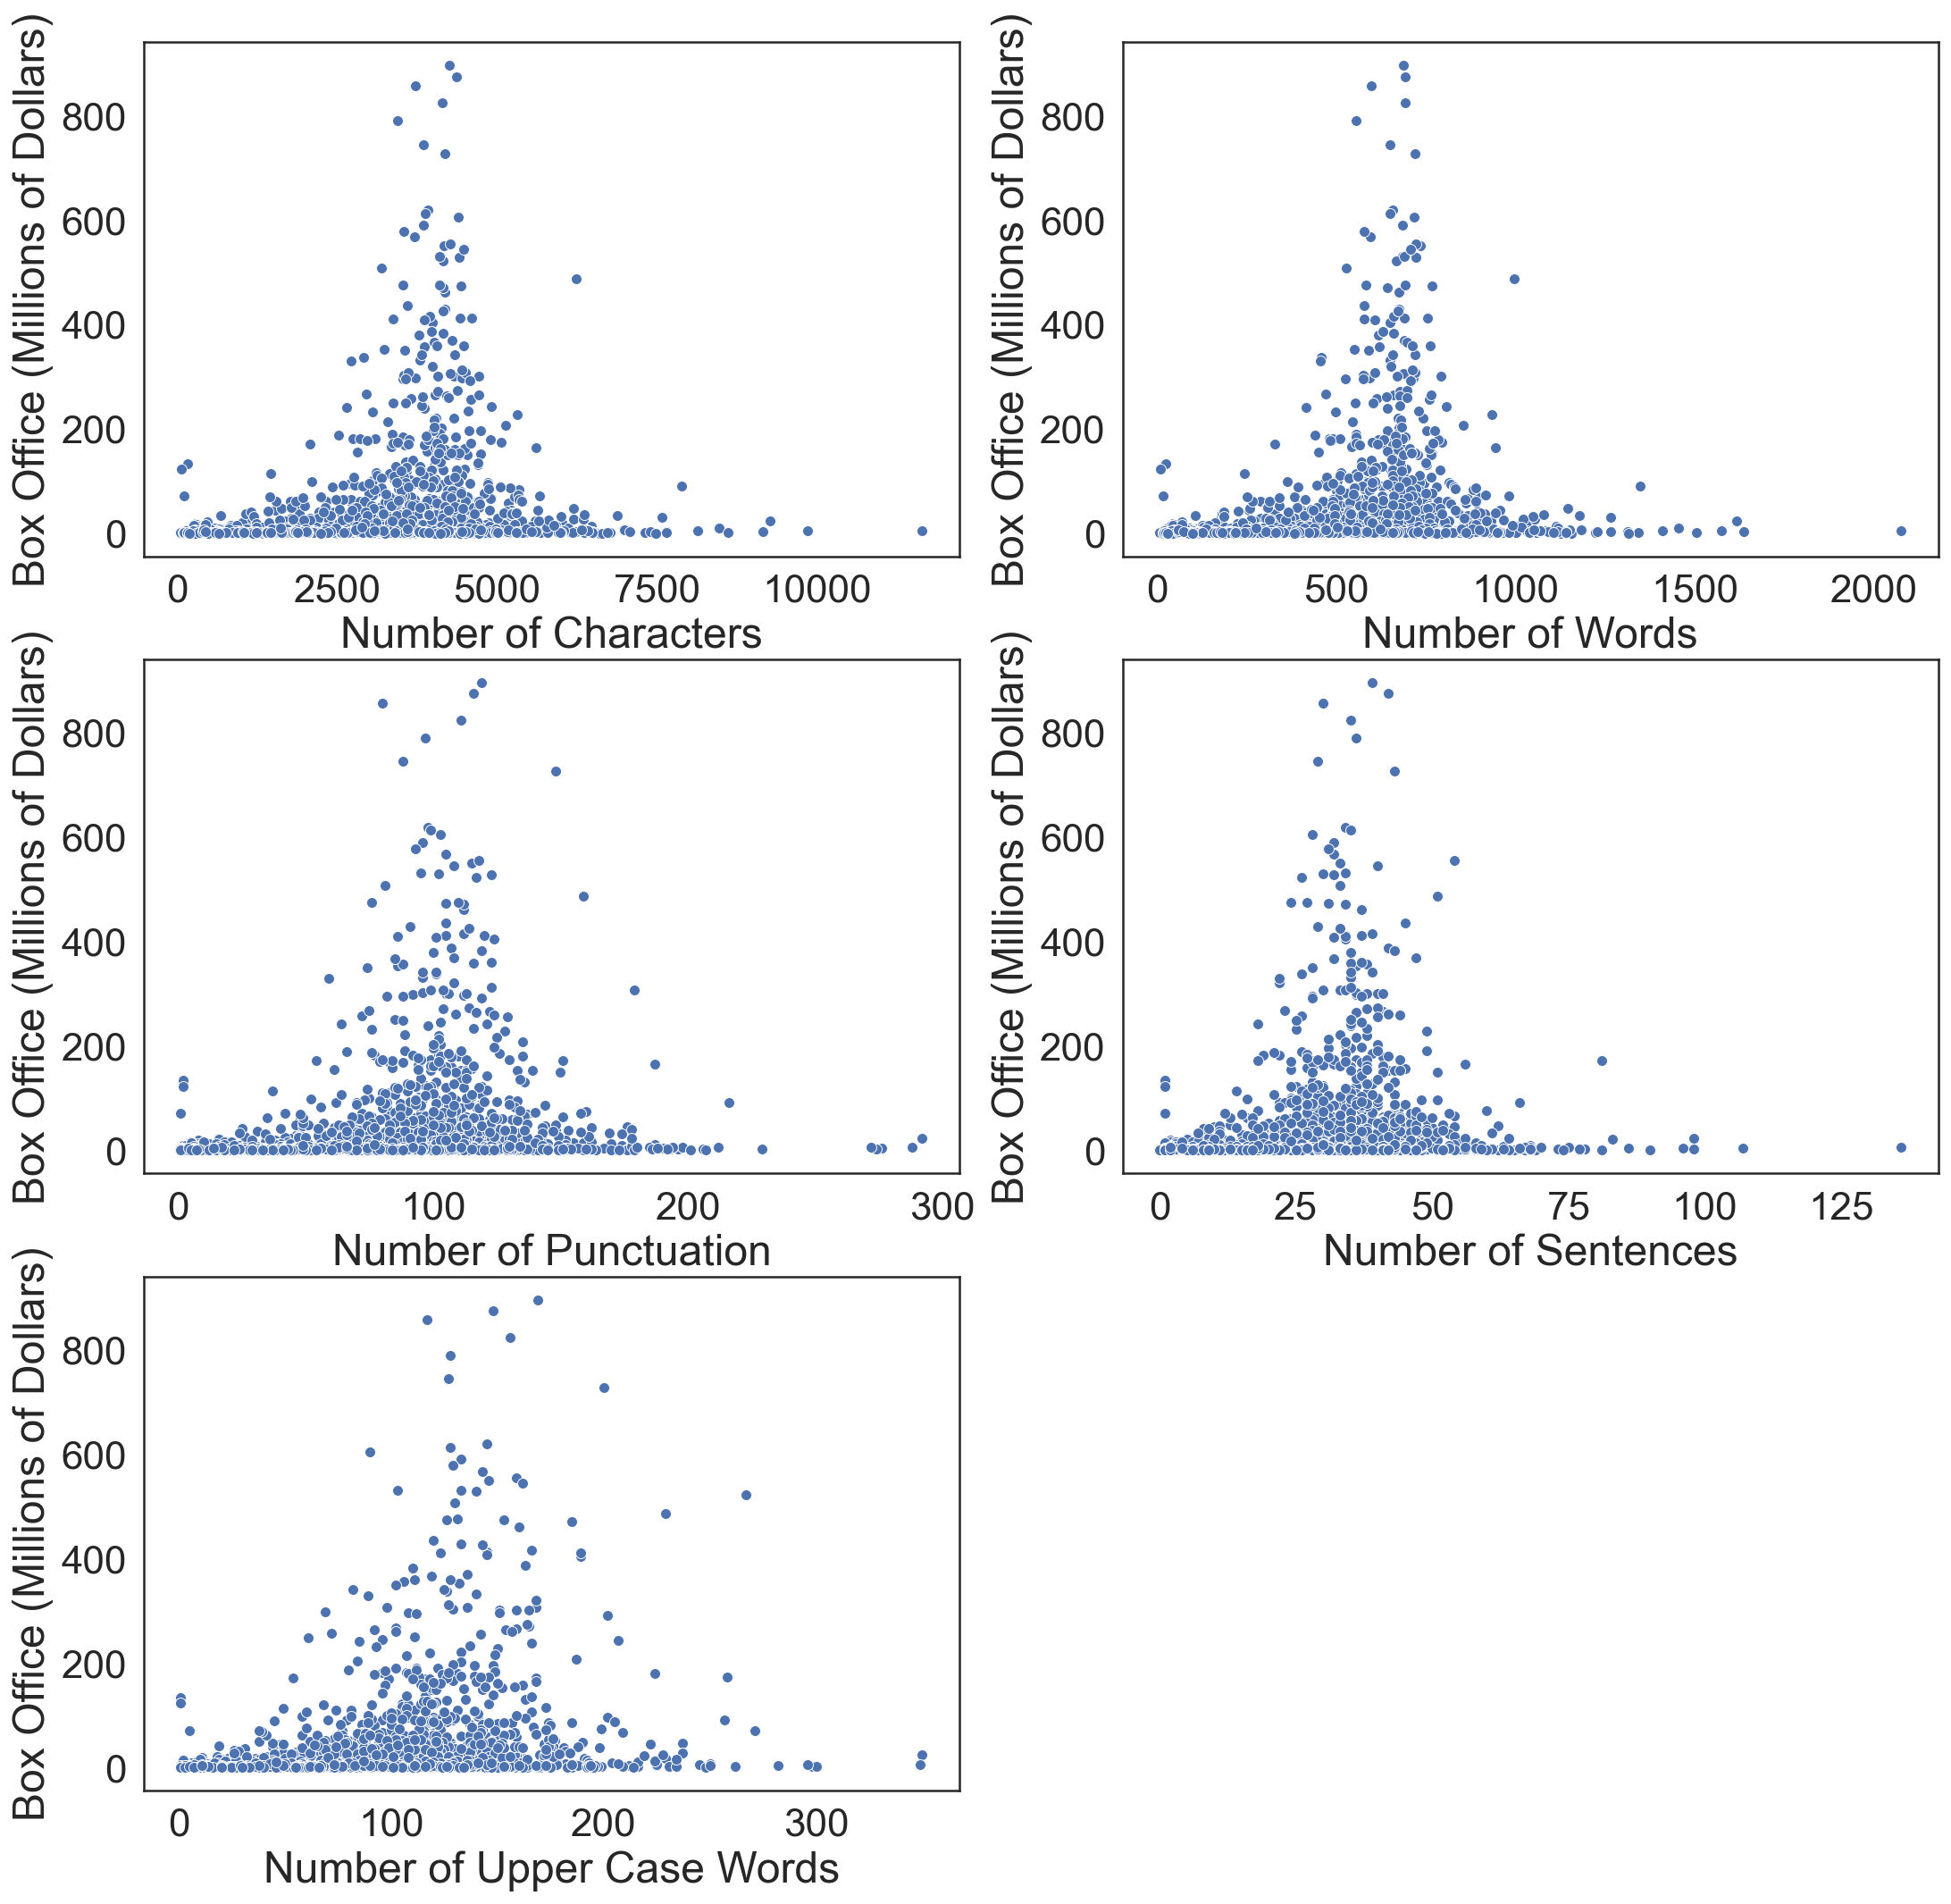

In [53]:
# plot count values vs box office
fig, ax = plt.subplots(3, 2, figsize=(18, 18))
ax1 = sns.scatterplot(x=char_count, y=box_office, ax=ax[0][0])
ax1.set(xlabel='Number of Characters', ylabel='Box Office (Millions of Dollars)')
ax2 = sns.scatterplot(x=word_count, y=box_office, ax=ax[0][1])
ax2.set(xlabel='Number of Words', ylabel='Box Office (Millions of Dollars)')
ax3 = sns.scatterplot(x=punct_count, y=box_office, ax=ax[1][0])
ax3.set(xlabel='Number of Punctuation', ylabel='Box Office (Millions of Dollars)')
ax4 = sns.scatterplot(x=sent_count, y=box_office, ax=ax[1][1])
ax4.set(xlabel='Number of Sentences', ylabel='Box Office (Millions of Dollars)')
ax5 = sns.scatterplot(x=upper_count, y=box_office, ax=ax[2][0])
ax5.set(xlabel='Number of Upper Case Words', ylabel='Box Office (Millions of Dollars)')
fig.delaxes(ax[2][1])

In [54]:
# gets the counts of each part of speech
def get_pos_count(text):
    tokens=nltk.word_tokenize(text)
    word_pos = []
    pos_count = defaultdict(int)
    for word, tag in nltk.pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
            pos_count['n'] += 1
        elif tag.startswith('VB'):
            pos = 'v'
            pos_count['v'] += 1
        elif tag.startswith('JJ'):
            pos = 'adj'
            pos_count['adj'] += 1
        elif tag.startswith('RB'):
            pos = 'adv'
            pos_count['adv'] += 1
        else:
            pos = 'a'
            pos_count['a'] += 1
        word_pos.append((word, pos))
    return word_pos, pos_count

In [55]:
# get part of speech of each plot
pos_count = []
noun_count = []
verb_count = []
adj_count = []
adv_count = []

for i in range(len(df)):
    text = df.iloc[i]['Plot']
    word_pos, pos = get_pos_count(text)
    pos_count.append(pos)
for i in pos_count:
    noun_count.append(i['n'])
    verb_count.append(i['v'])
    adj_count.append(i['adj'])
    adv_count.append(i['adv'])

[Text(0.5, 0, 'Number of Adverbs'),
 Text(0, 0.5, 'Box Office (Millions of Dollars)')]

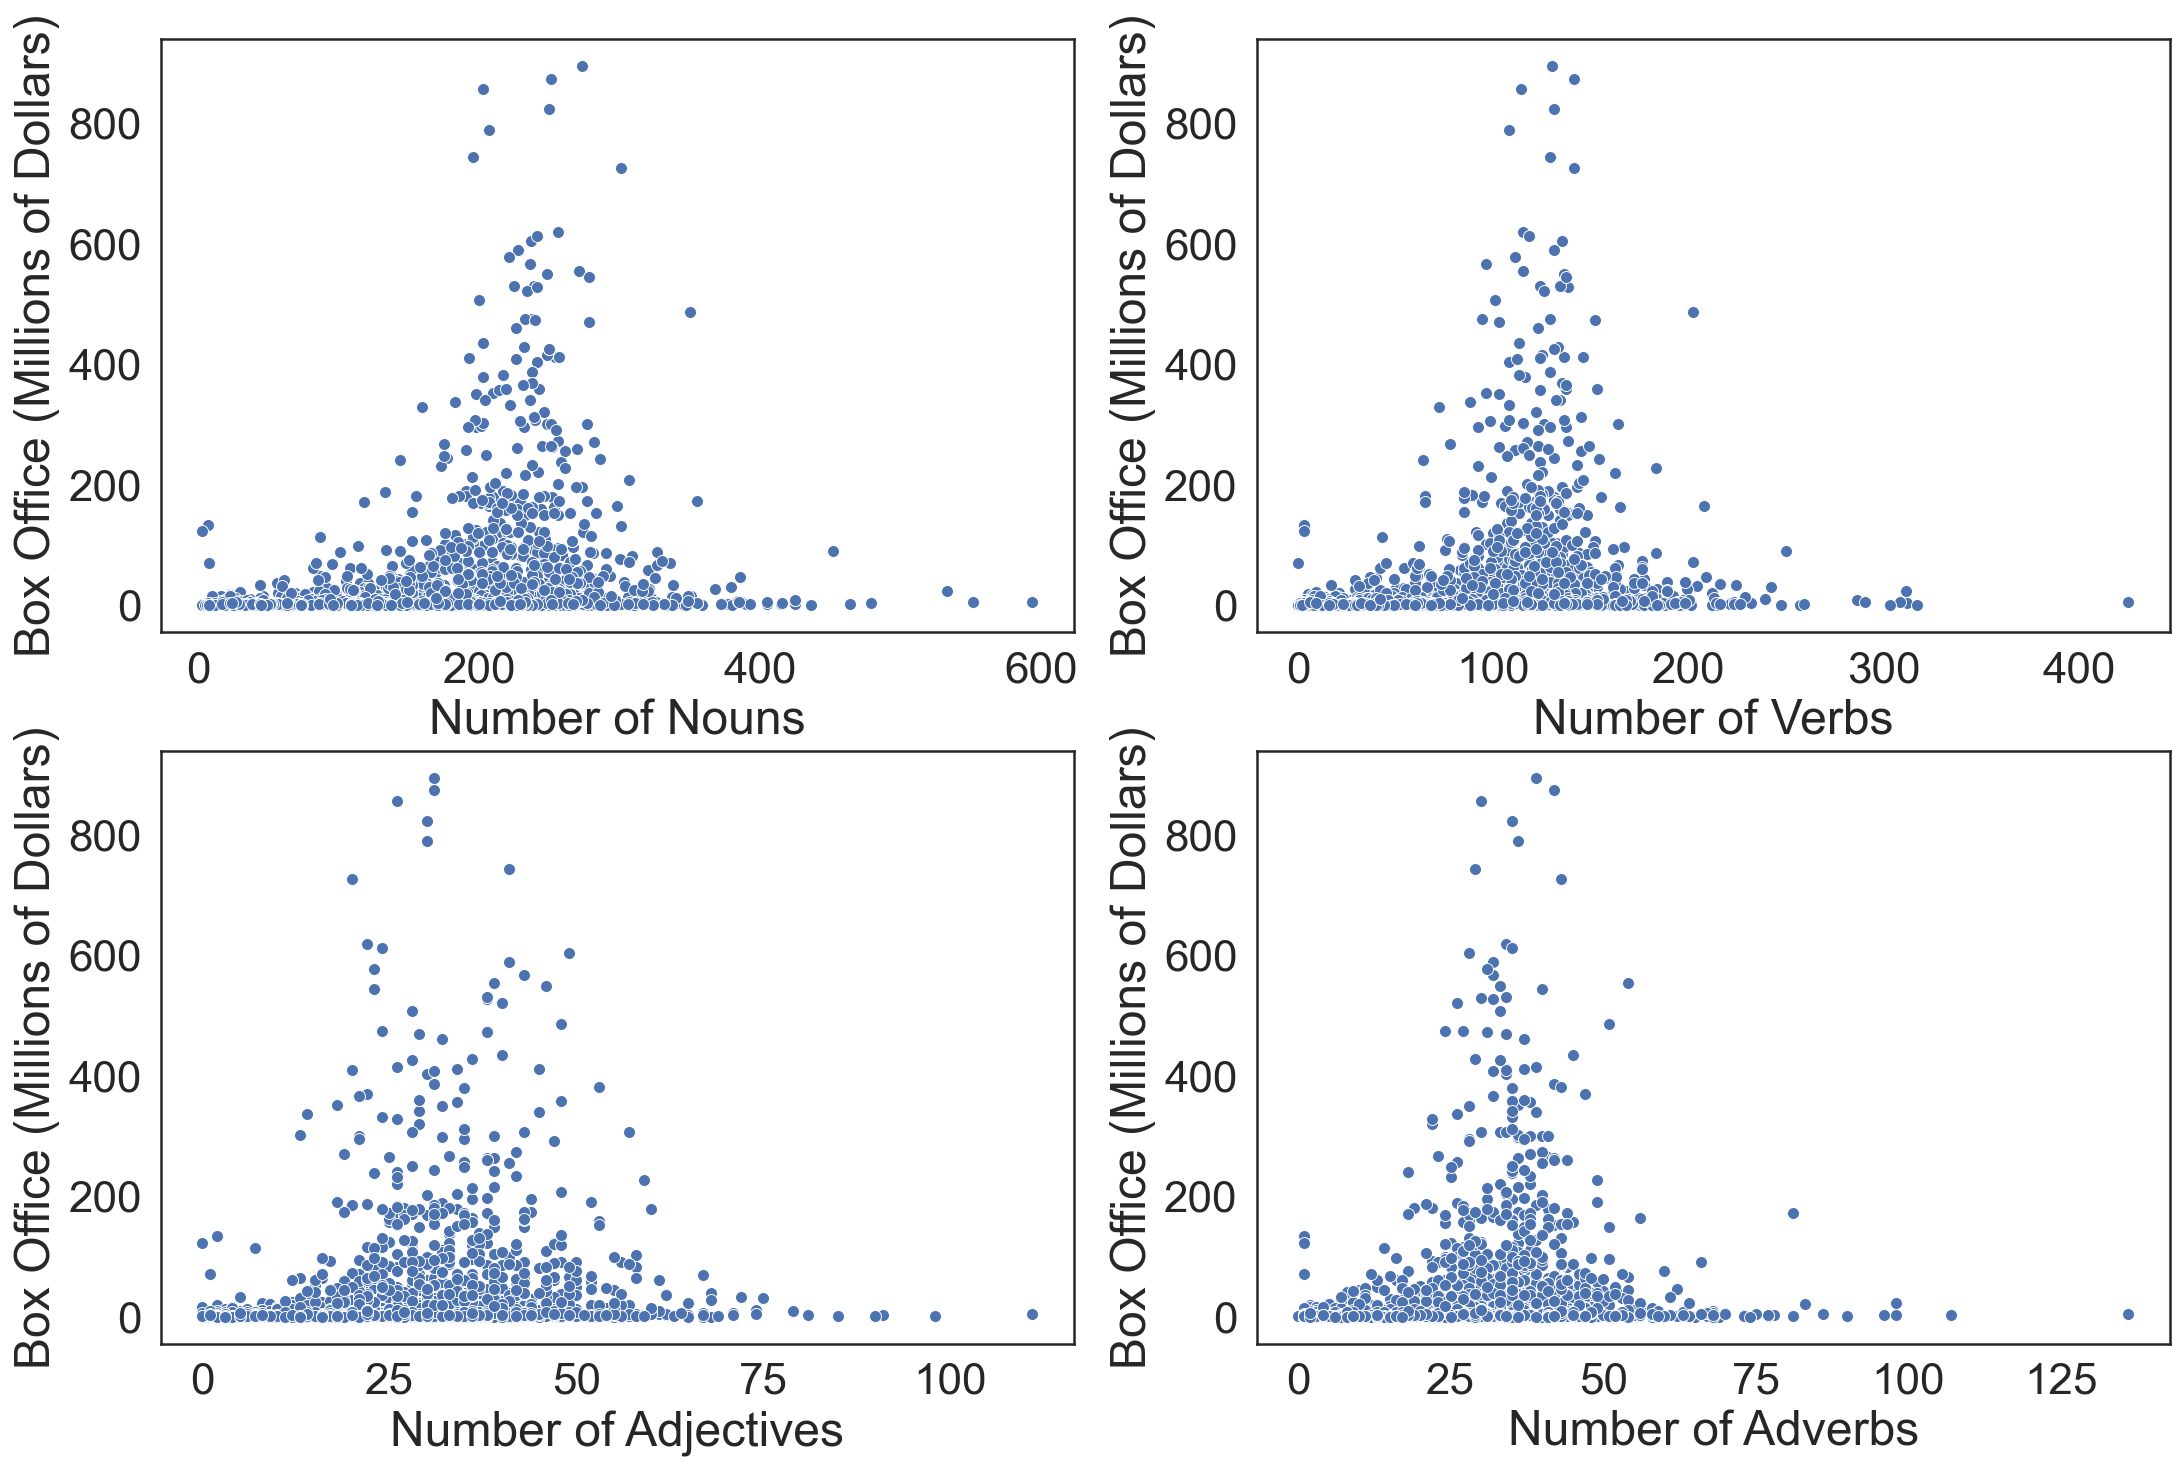

In [56]:
# plot counts of part of speech vs box office
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax1 = sns.scatterplot(x=noun_count, y=box_office, ax=ax[0][0])
ax1.set(xlabel='Number of Nouns', ylabel='Box Office (Millions of Dollars)')
ax2 = sns.scatterplot(x=verb_count, y=box_office, ax=ax[0][1])
ax2.set(xlabel='Number of Verbs', ylabel='Box Office (Millions of Dollars)')
ax3 = sns.scatterplot(x=adj_count, y=box_office, ax=ax[1][0])
ax3.set(xlabel='Number of Adjectives', ylabel='Box Office (Millions of Dollars)')
ax4 = sns.scatterplot(x=sent_count, y=box_office, ax=ax[1][1])
ax4.set(xlabel='Number of Adverbs', ylabel='Box Office (Millions of Dollars)')

The plots of the counts of each part of speech vs box office also look similar to our counts vs box office plots from before. This makes sense as the counts of each part of speech will also be linearly correlated with the size of the plot text with the same reasoning the counts of each attribute of the text was linearly correlated.

Every characteristic of the plot text we examined seems to have the same relationship with box office sales. There does not appear to have a linear relationship but a distribution with the greatest box office sale located around the median of the counts and an outlier with a large count and low box office.

### Exploration of VADER Sentiment Distribution

Information from VADER documentation: 
- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [57]:
df[['VADER negative', 'VADER neutral', 'VADER positive', 'VADER compound', 'VADER compound (absolute value)', 
  'TextBlob subjectivity', 'TextBlob polarity']].describe()

VADER negative  VADER neutral  VADER positive  VADER compound  \
count     2494.000000    2494.000000     2494.000000     2494.000000   
mean         0.119198       0.799682        0.081133       -0.436768   
std          0.050750       0.057394        0.040236        0.768220   
min          0.000000       0.521000        0.000000       -0.999800   
25%          0.085000       0.763250        0.055000       -0.994600   
50%          0.115000       0.800000        0.077000       -0.943650   
75%          0.152000       0.834000        0.103000        0.251200   
max          0.333000       1.000000        0.322000        0.999600   

       VADER compound (absolute value)  TextBlob subjectivity  \
count                      2494.000000            2494.000000   
mean                          0.849927               0.412692   
std                           0.241534               0.111112   
min                           0.000000               0.000000   
25%                           0.817850               0.352345   
50%                           0.972300               0.413395   
75%                           0.994900               0.473320   
max                           0.999800               1.000000   

       TextBlob polarity  
count        2494.000000  
mean            0.030365  
std             0.097858  
min            -0.645833  
25%            -0.023375  
50%             0.022234  
75%             0.081329  
max             0.675000

<AxesSubplot:xlabel='VADER compound', ylabel='Count'>

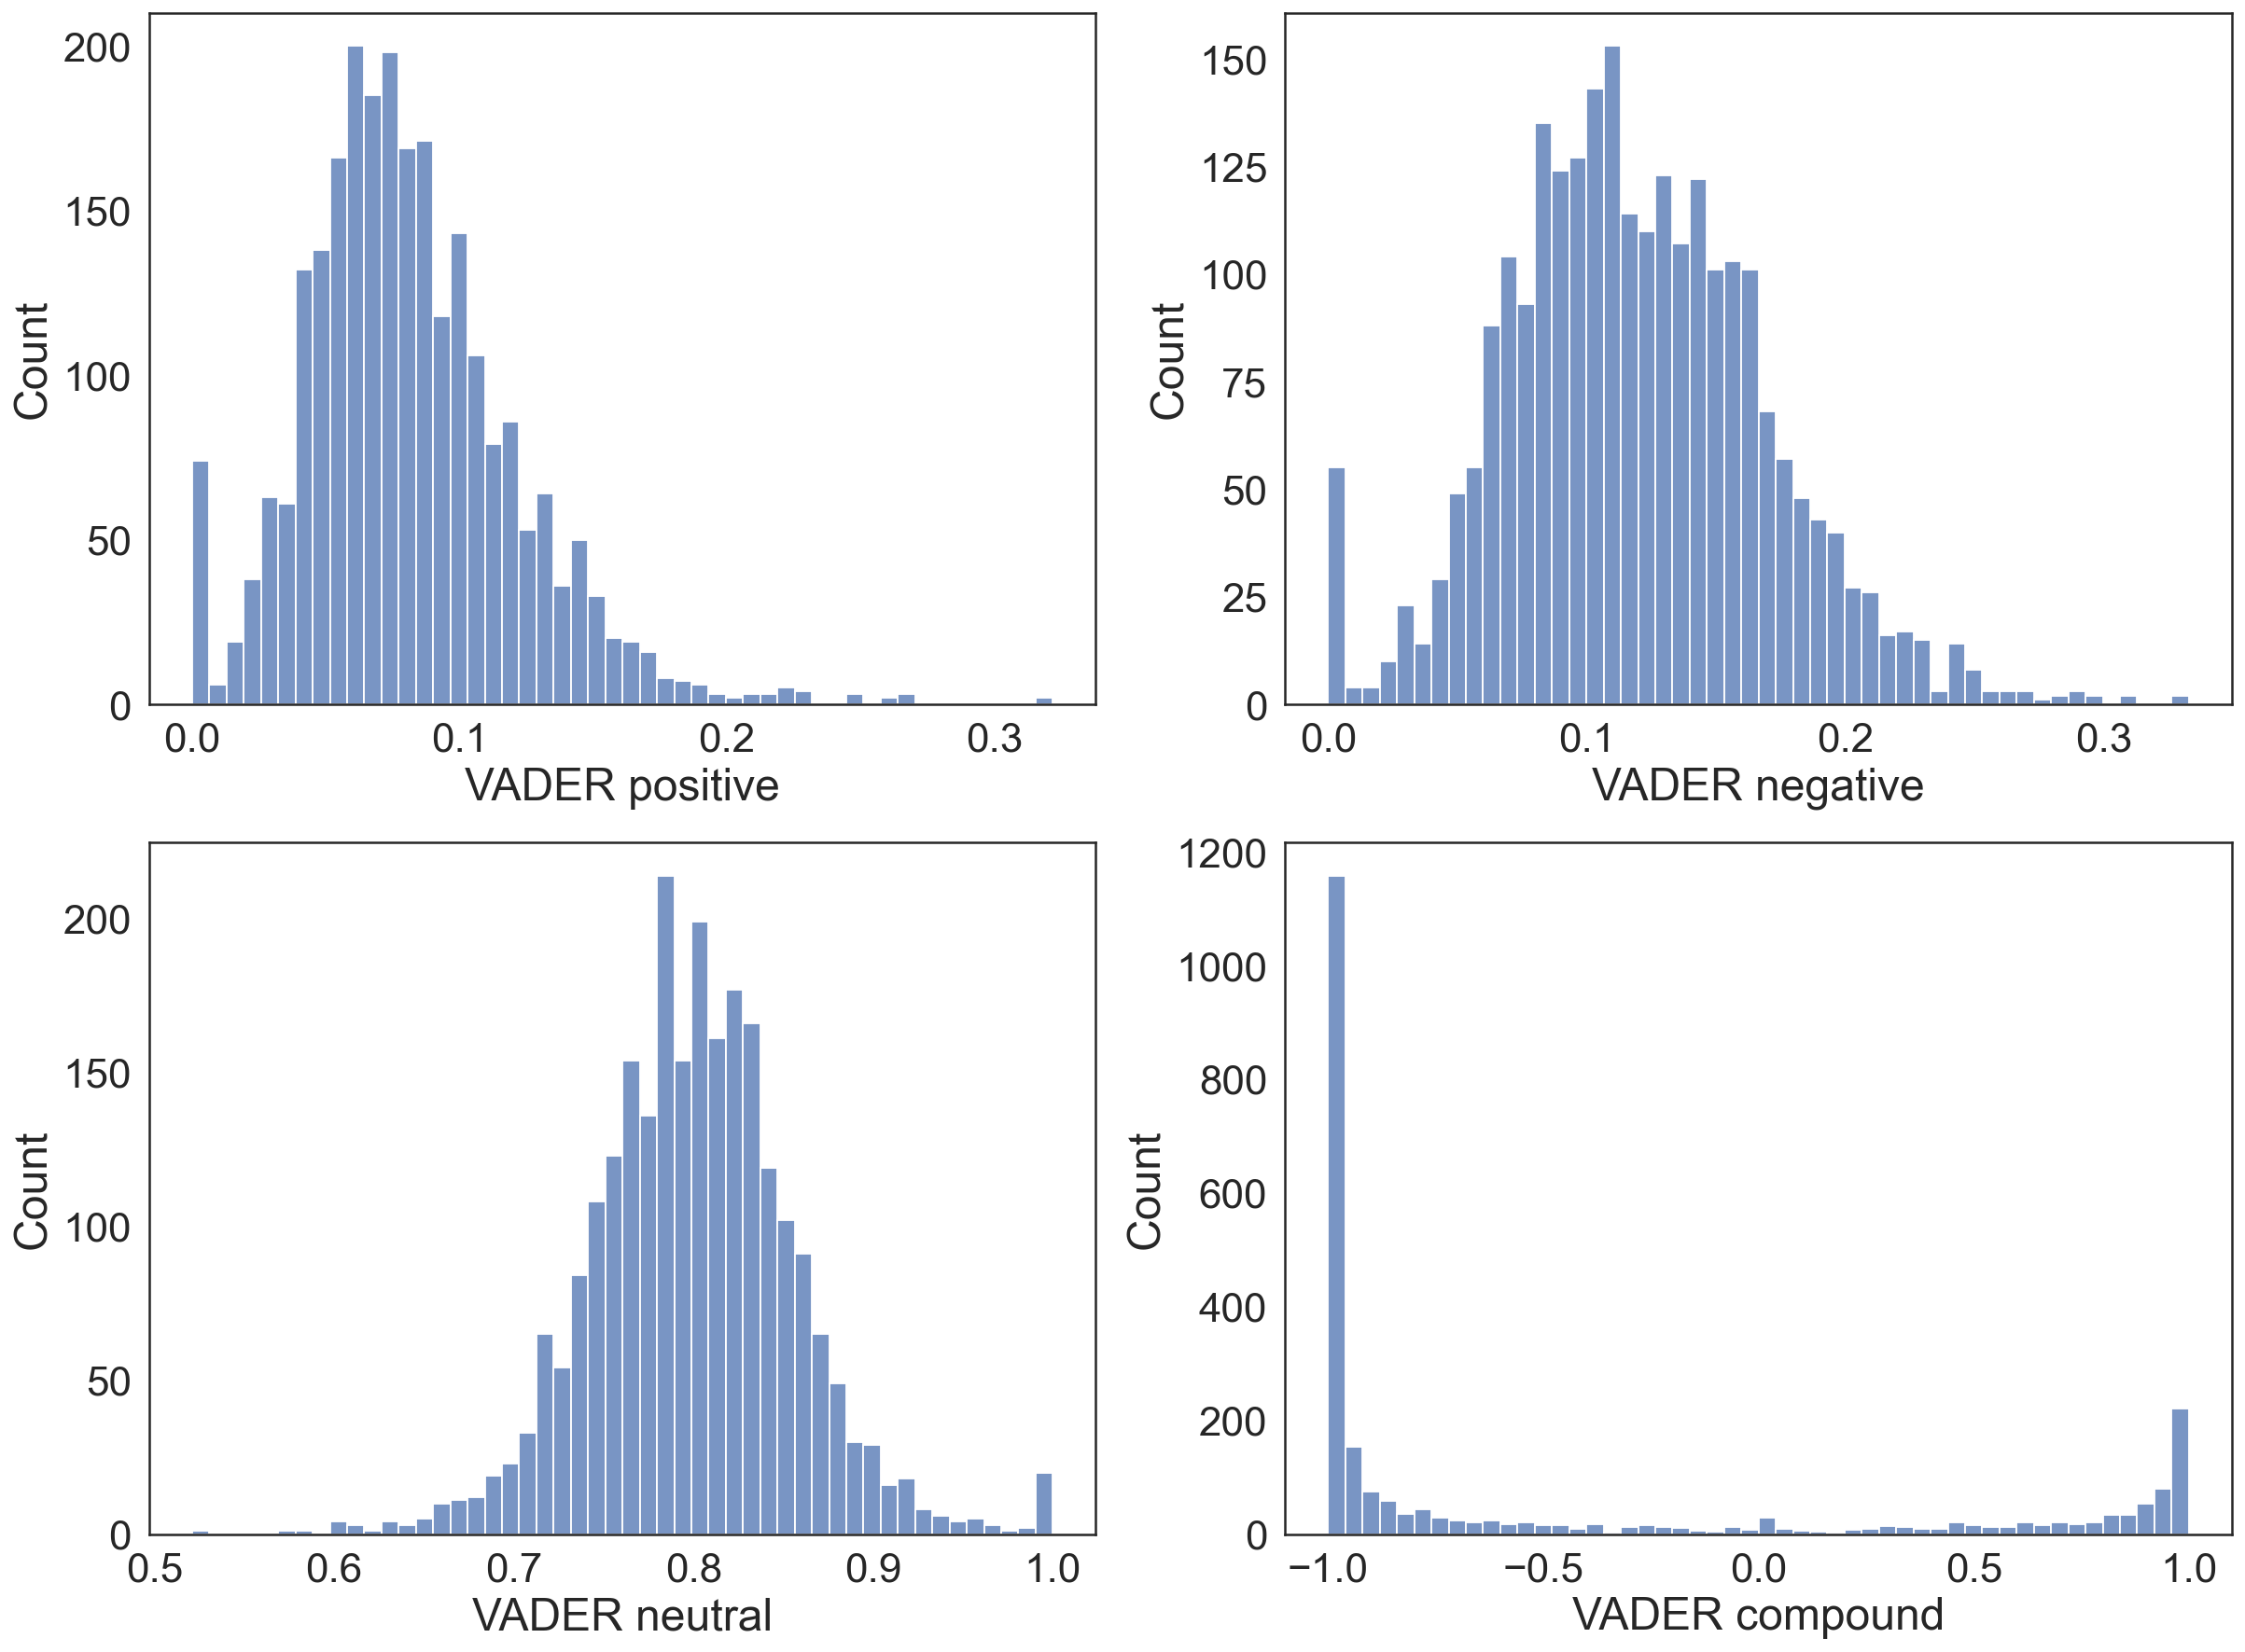

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(df['VADER positive'], bins=50, ax=ax[0][0])
sns.histplot(df['VADER negative'], bins=50, ax=ax[0][1])
sns.histplot(df['VADER neutral'], bins=50, ax=ax[1][0])
sns.histplot(df['VADER compound'], bins=50, ax=ax[1][1])

<AxesSubplot:xlabel='TextBlob subjectivity', ylabel='Count'>

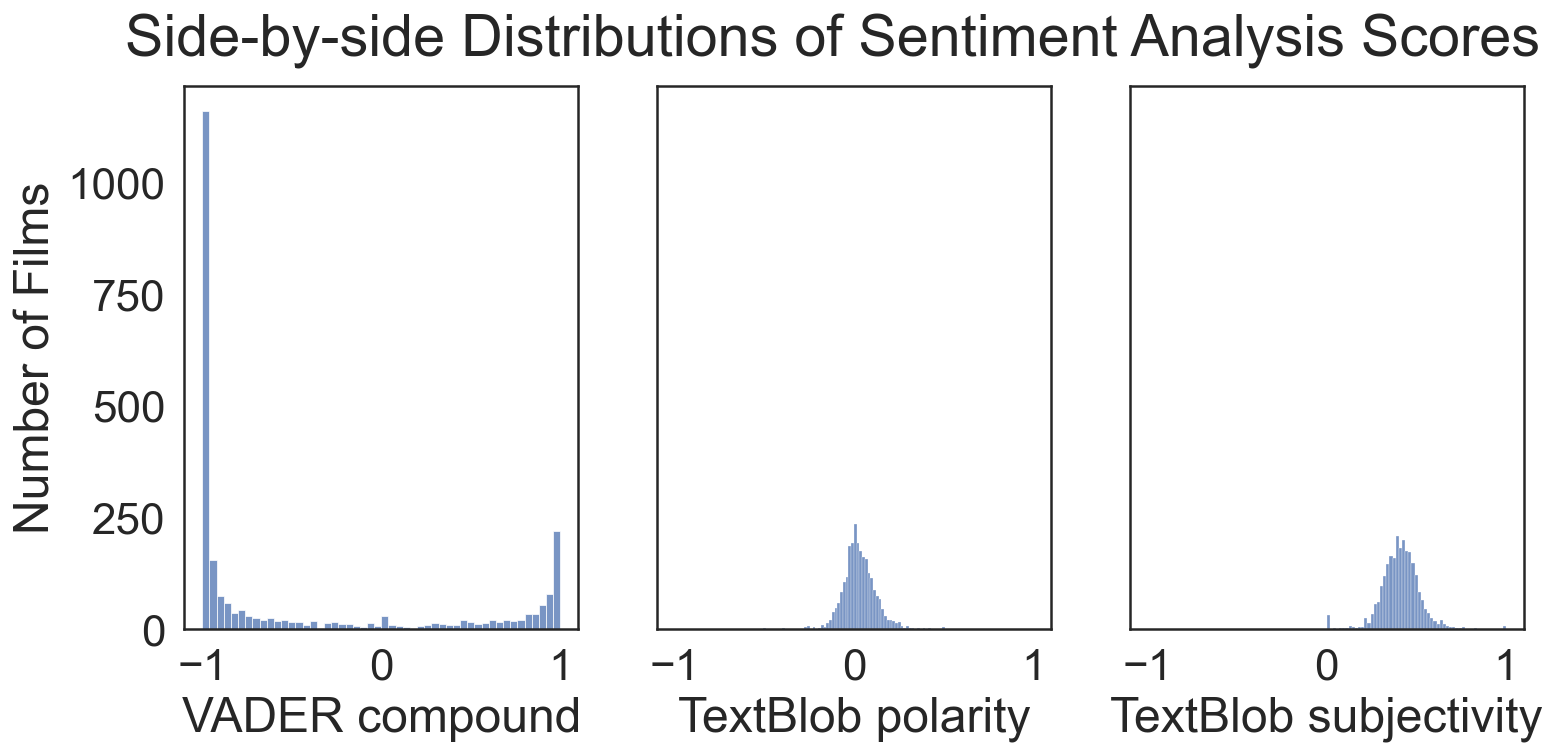

In [59]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle('Side-by-side Distributions of Sentiment Analysis Scores')
sns.histplot(df['VADER compound'], bins=50, ax=ax[0])
ax[0].set(ylabel='Number of Films')
sns.histplot(df['TextBlob polarity'], ax=ax[1])
sns.histplot(df['TextBlob subjectivity'], ax=ax[2])

#### The VADER Sentiment seems to have a lot more films with negative sentiment, so let's take a closer look at its distribution.

<AxesSubplot:xlabel='VADER compound', ylabel='Count'>

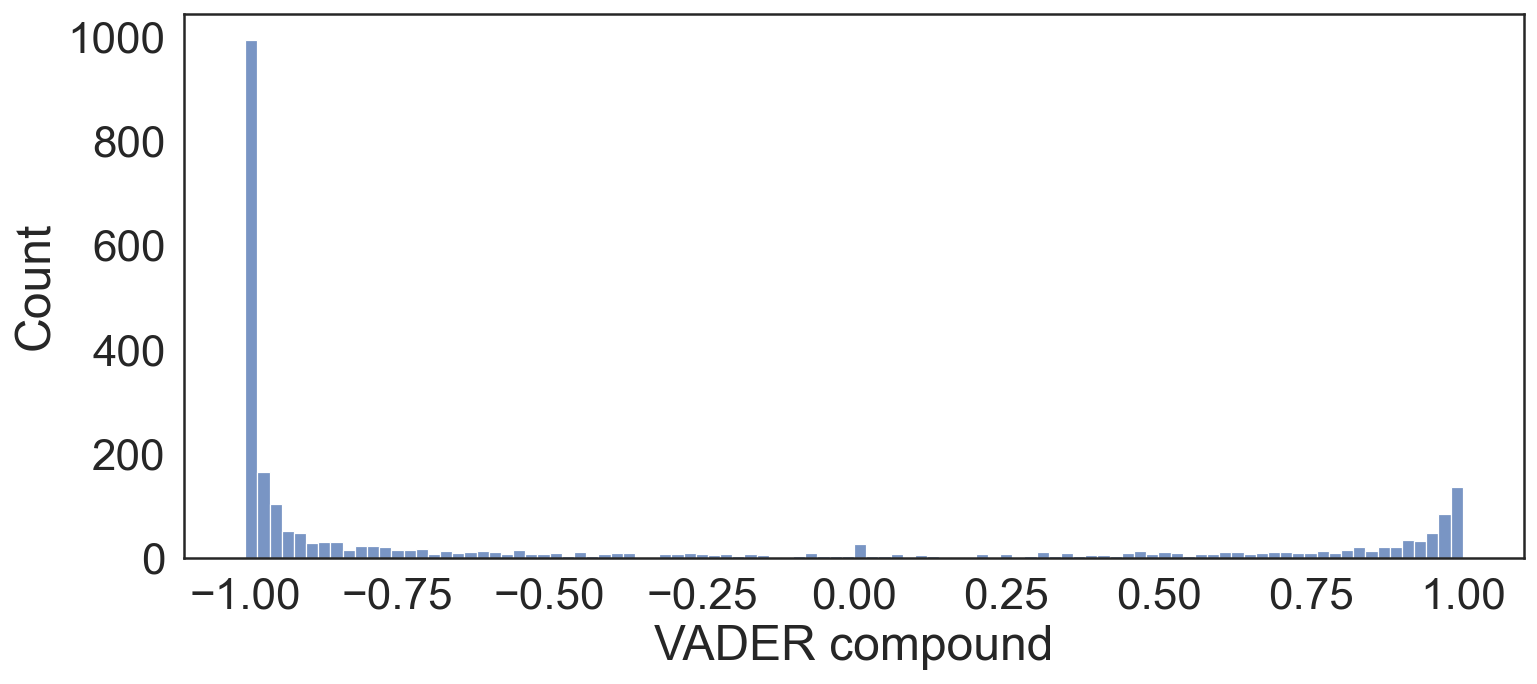

In [60]:
sns.histplot(df['VADER compound'], bins=100)

#### What proportions of films in the dataset have a compound score of less than -0.9 (and thus is considered to be highly negative)?

In [61]:
#see how many films are extremely negative (less than -0.9 VADER sentiment score)
df[df['VADER compound'] < -0.9].shape[0] #1376

#what proportions of films in the dataset have a sentiment score of less than -0.9?
df[df['VADER compound'] < -0.9].shape[0] / df.shape[0] #0.546

0.5449077786688051

Let's see what types of films normally have negative plot sentiments

[Text(0.5, 1.0, 'Highly Negative Film Plots by Genre')]

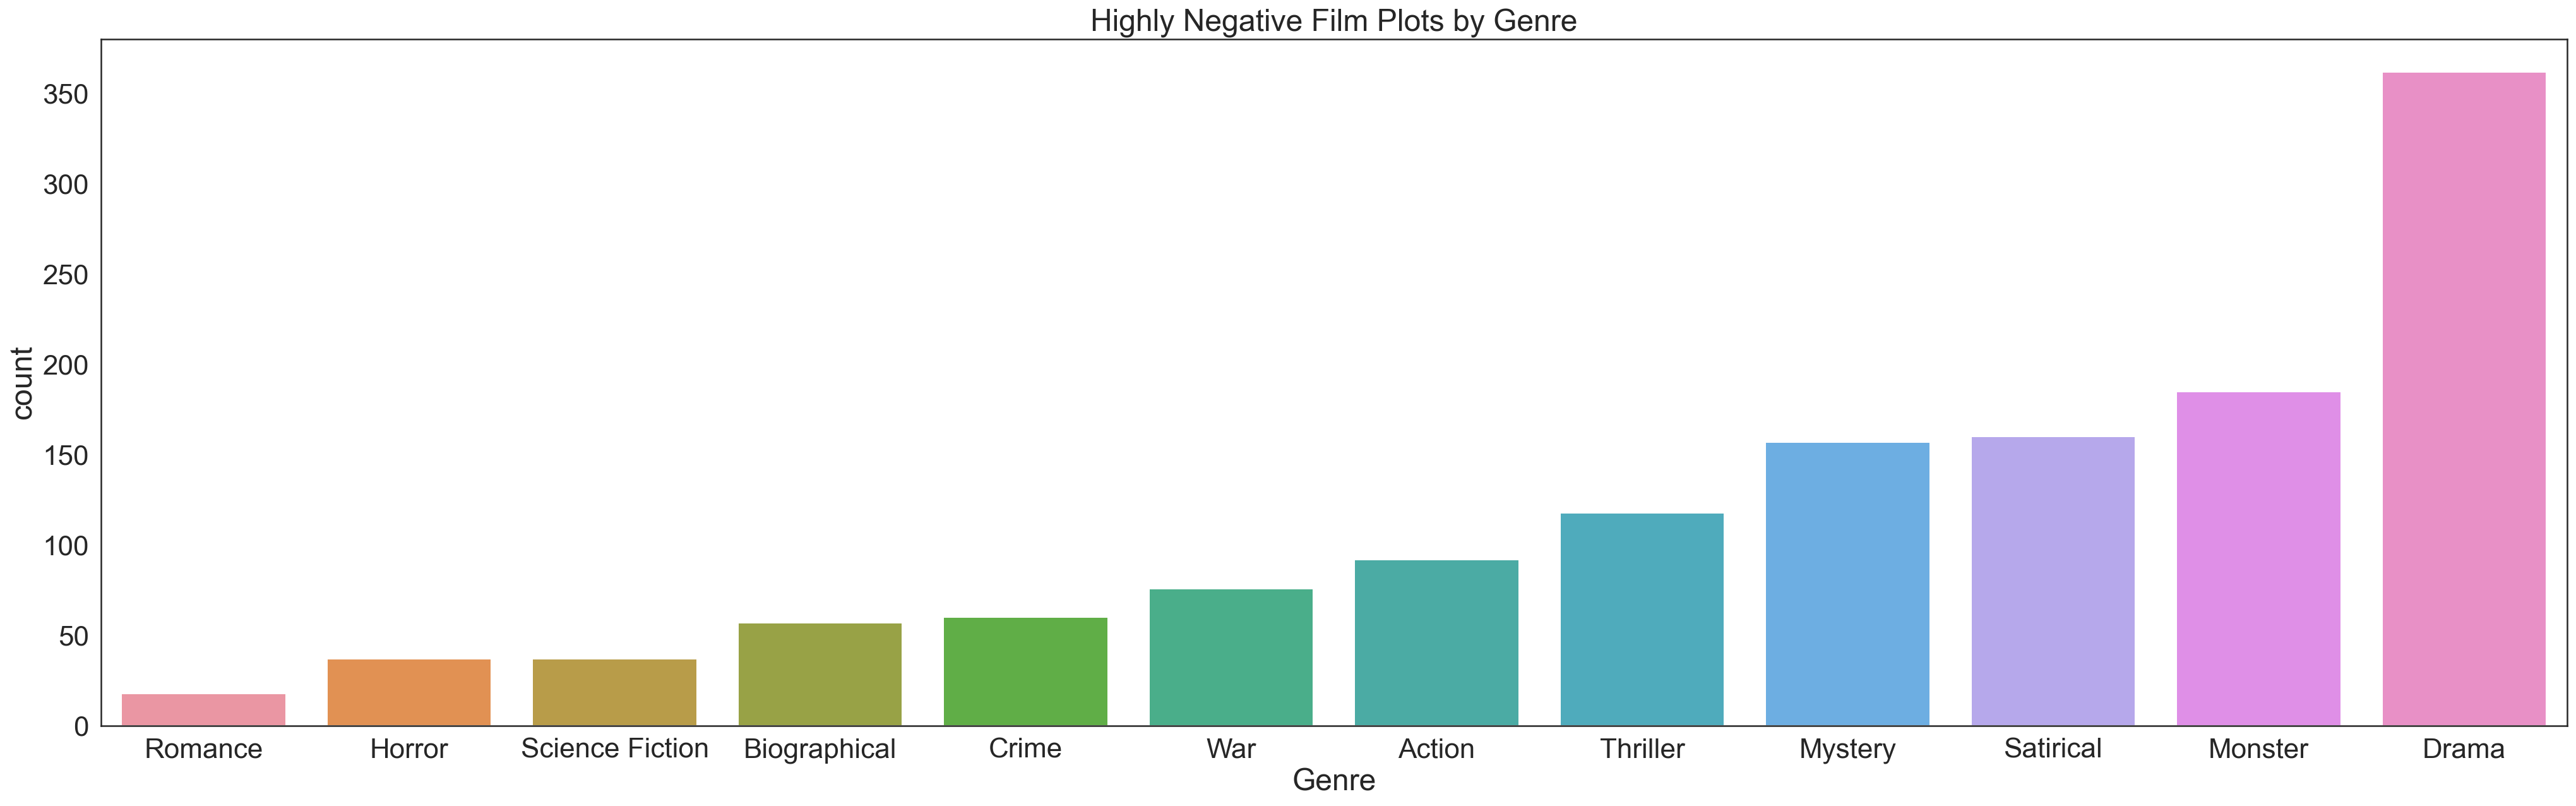

In [62]:
#Create a sub dataframe of just films with sentiment scores of < -0.9 and plot a bar graph to see common genres
very_neg = df[df['VADER compound'] < -0.9]
fig, ax = plt.subplots(figsize= (35, 10))
sns.countplot(data=very_neg, order= very_neg['Genre'].value_counts(ascending=True).index, x='Genre', ax=ax).set(title='Highly Negative Film Plots by Genre')

#### Something interesting to explore is whether certain directors tend to direct movies with more negative Wikipedia Film Plot sentiments:

In [63]:
#see the counts per genre
very_neg.groupby(df['Genre']).count().sort_values(by='Film name', ascending= False)

#Is there a certain director who has directed more negative films?
very_neg.groupby(df['Directed by']).count().sort_values(by='Film name', ascending= False)
#John Farrow has 9 and Roger Corman has 8, a couple have 7

#John Farrow has directed 12 movies in the dataset and 8 have a sentiment score of less than -0.9
df[df['Directed by'] == 'John Farrow'].head()#.Genre.unique()#.shape[0] #12

Film name  Genre  \
148         His Kind of Woman  Crime   
180    The Saint Strikes Back  Crime   
216  Commandos Strike at Dawn    War   
289         Submarine Command    War   
305        Wake Island (film)    War   

                                                  Plot  Directed by  \
148  Down on his luck, professional gambler Dan Mil...  John Farrow   
180  While dancing at a New Year's party, the Saint...  John Farrow   
216  Erik Toresen, a widower and peaceful man, is s...  John Farrow   
289  During the Pacific War, Lieutenant Commander K...  John Farrow   
305  A map is shown with a voiceover giving a brief...  John Farrow   

                   Written by              Story by     Produced by  \
148                       NaN  Gerald Drayson Adams   Robert Sparks   
180                John Twist                   NaN     Robert Sisk   
216    C. S. Forester (story)                   NaN        Sam Wood   
289  Jonathan Latimer (story)                   NaN  Joseph Sistrom   
305             W. R. Burnett                   NaN  Joseph Sistrom   

           Starring     Cinematography          Edited by         Music by  \
148  Robert Mitchum      Harry J. Wild  Frederic Knudtson    Leigh Harline   
180  George Sanders       Frank Redman        Jack Hively         Roy Webb   
216       Paul Muni  William C. Mellor      Anne Bauchens  Louis Gruenberg   
289  William Holden      Lionel Lindon         Eda Warren   David Buttolph   
305   Brian Donlevy  William C. Mellor       Frank Bracht   David Buttolph   

         Distributed by  Duration (min)  Release year  Budget (mil dollar)  \
148  RKO Radio Pictures           120.0           NaN                  NaN   
180  RKO Radio Pictures            64.0        1939.0                0.128   
216   Columbia Pictures           100.0        1942.0                  NaN   
289  Paramount Pictures            87.0        1951.0                  NaN   
305  Paramount Pictures            88.0           NaN                0.826   

     Box office (mil dollar)  VADER negative  VADER neutral  VADER positive  \
148                     2.00           0.160          0.746           0.093   
180                     0.46           0.140          0.794           0.066   
216                     1.50           0.150          0.788           0.063   
289                     1.00           0.171          0.731           0.098   
305                     3.50           0.143          0.814           0.043   

     VADER compound  VADER compound (absolute value)  TextBlob subjectivity  \
148         -0.9941                           0.9941               0.486178   
180         -0.9892                           0.9892               0.436596   
216         -0.8176                           0.8176               0.219048   
289         -0.9938                           0.9938               0.225510   
305         -0.9972                           0.9972               0.251453   

     TextBlob polarity  
148          -0.027570  
180           0.036170  
216          -0.021429  
289           0.070170  
305          -0.011985

### Is there an association between films with extreme sentiment and high box office sales?
We use the absolute value of Vader Compound scores to see both highly negative and highly positive films.  

<AxesSubplot:xlabel='VADER compound (absolute value)', ylabel='Box office (mil dollar)'>

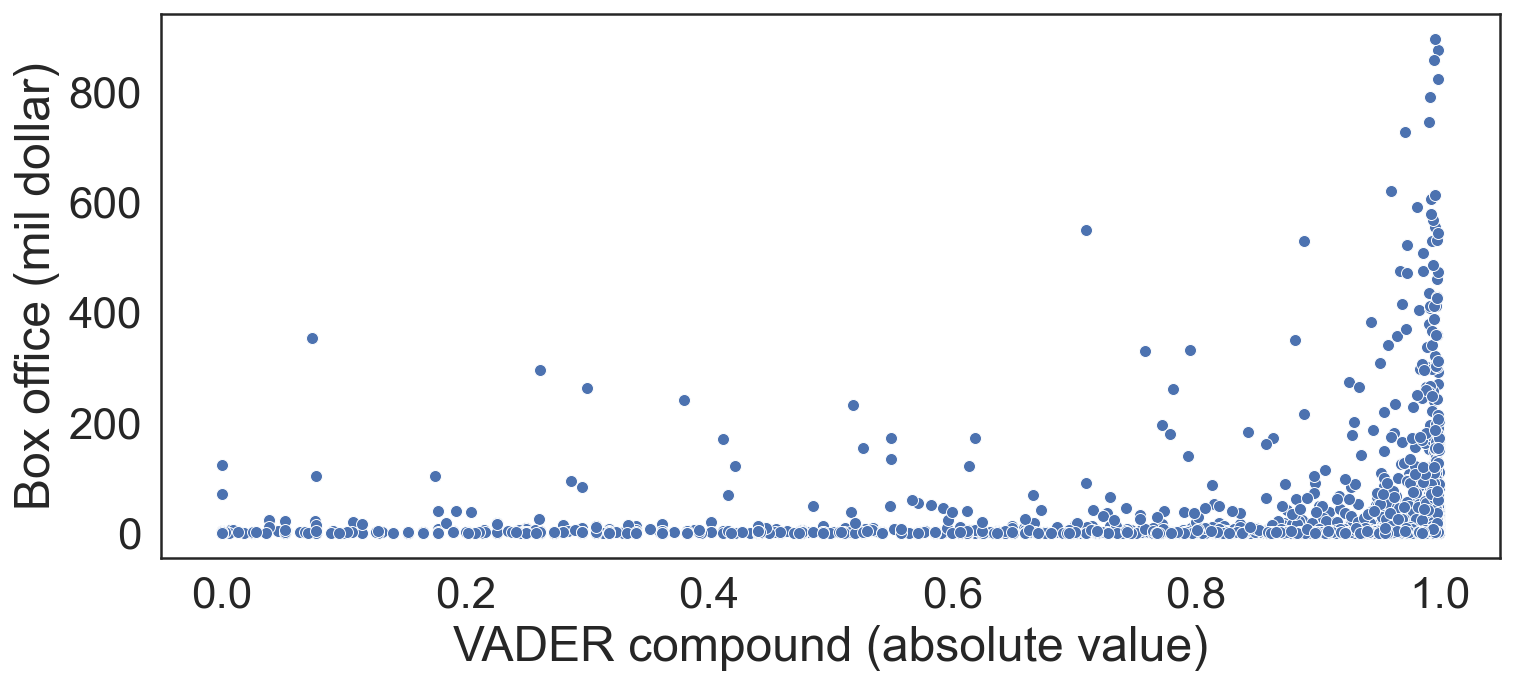

In [64]:
sns.scatterplot(data=df, x='VADER compound (absolute value)', y= 'Box office (mil dollar)')

### Looking at highly extreme values from 0.9-1.0 and exploring whether Genre plays a role

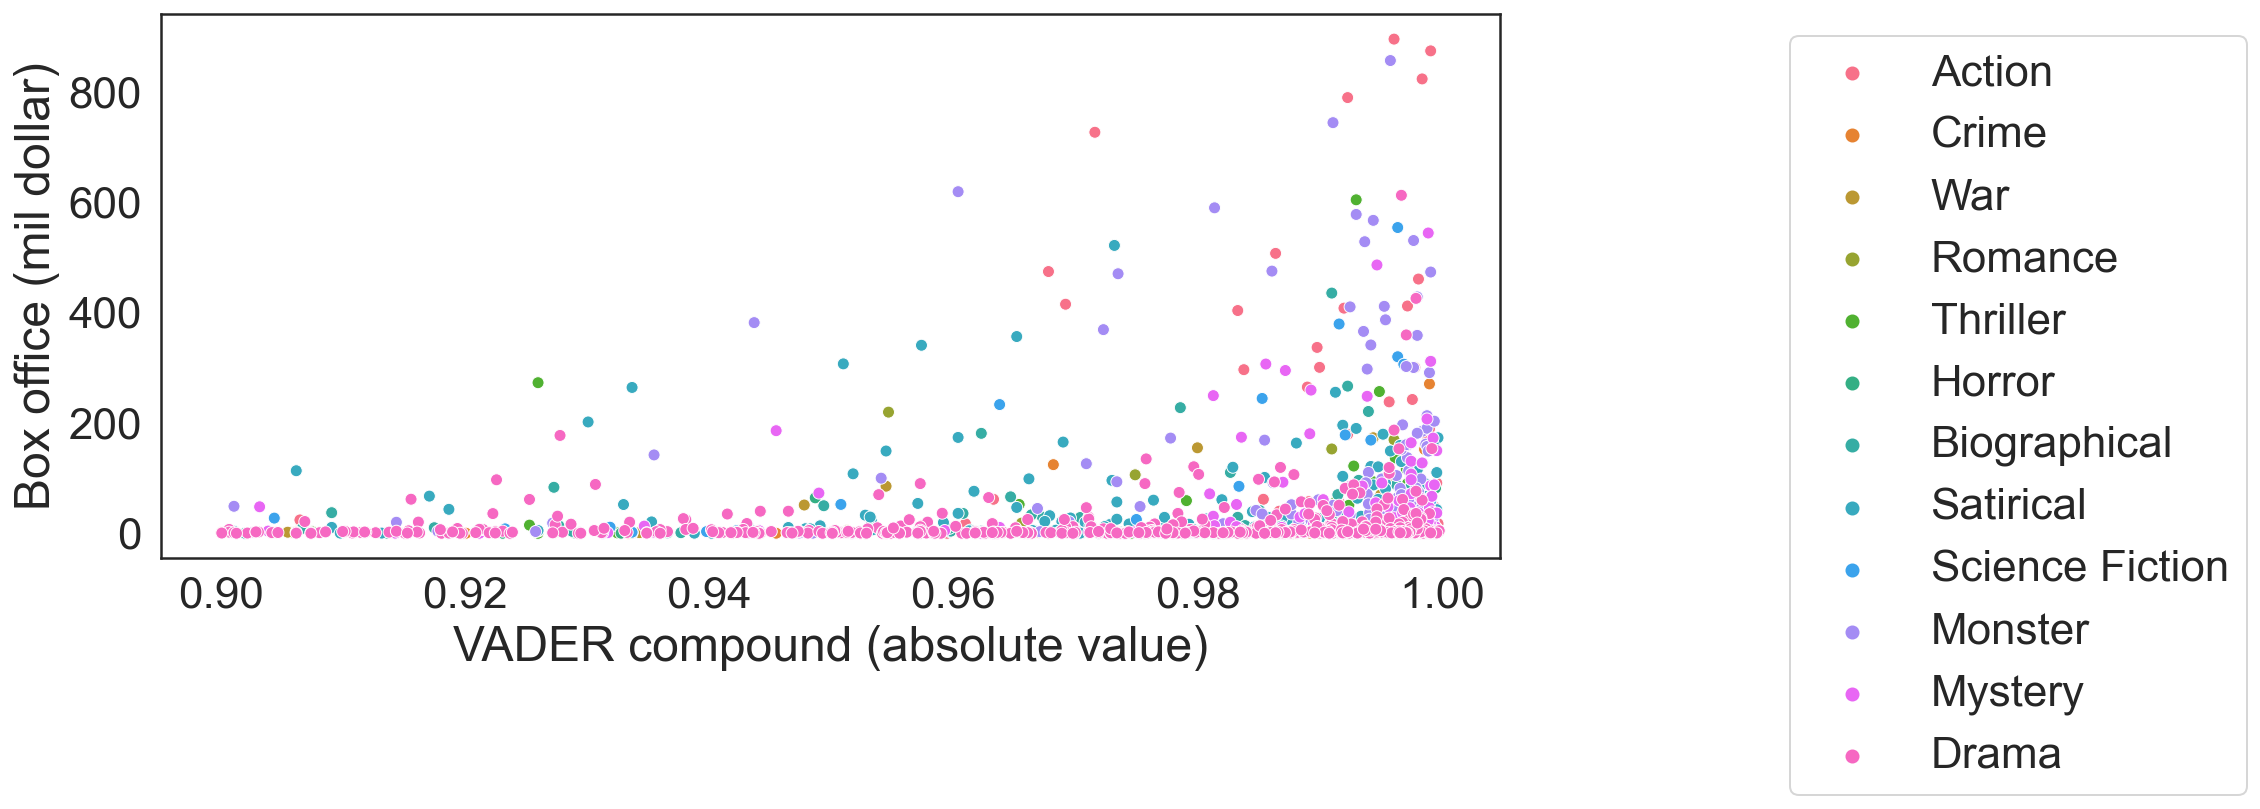

In [65]:
extreme_val = df[df['VADER compound (absolute value)'] > 0.9]
extreme_plt = sns.scatterplot(data=extreme_val, x='VADER compound (absolute value)', y= 'Box office (mil dollar)', hue='Genre')
extreme_plt.legend(bbox_to_anchor= (1.2,1))


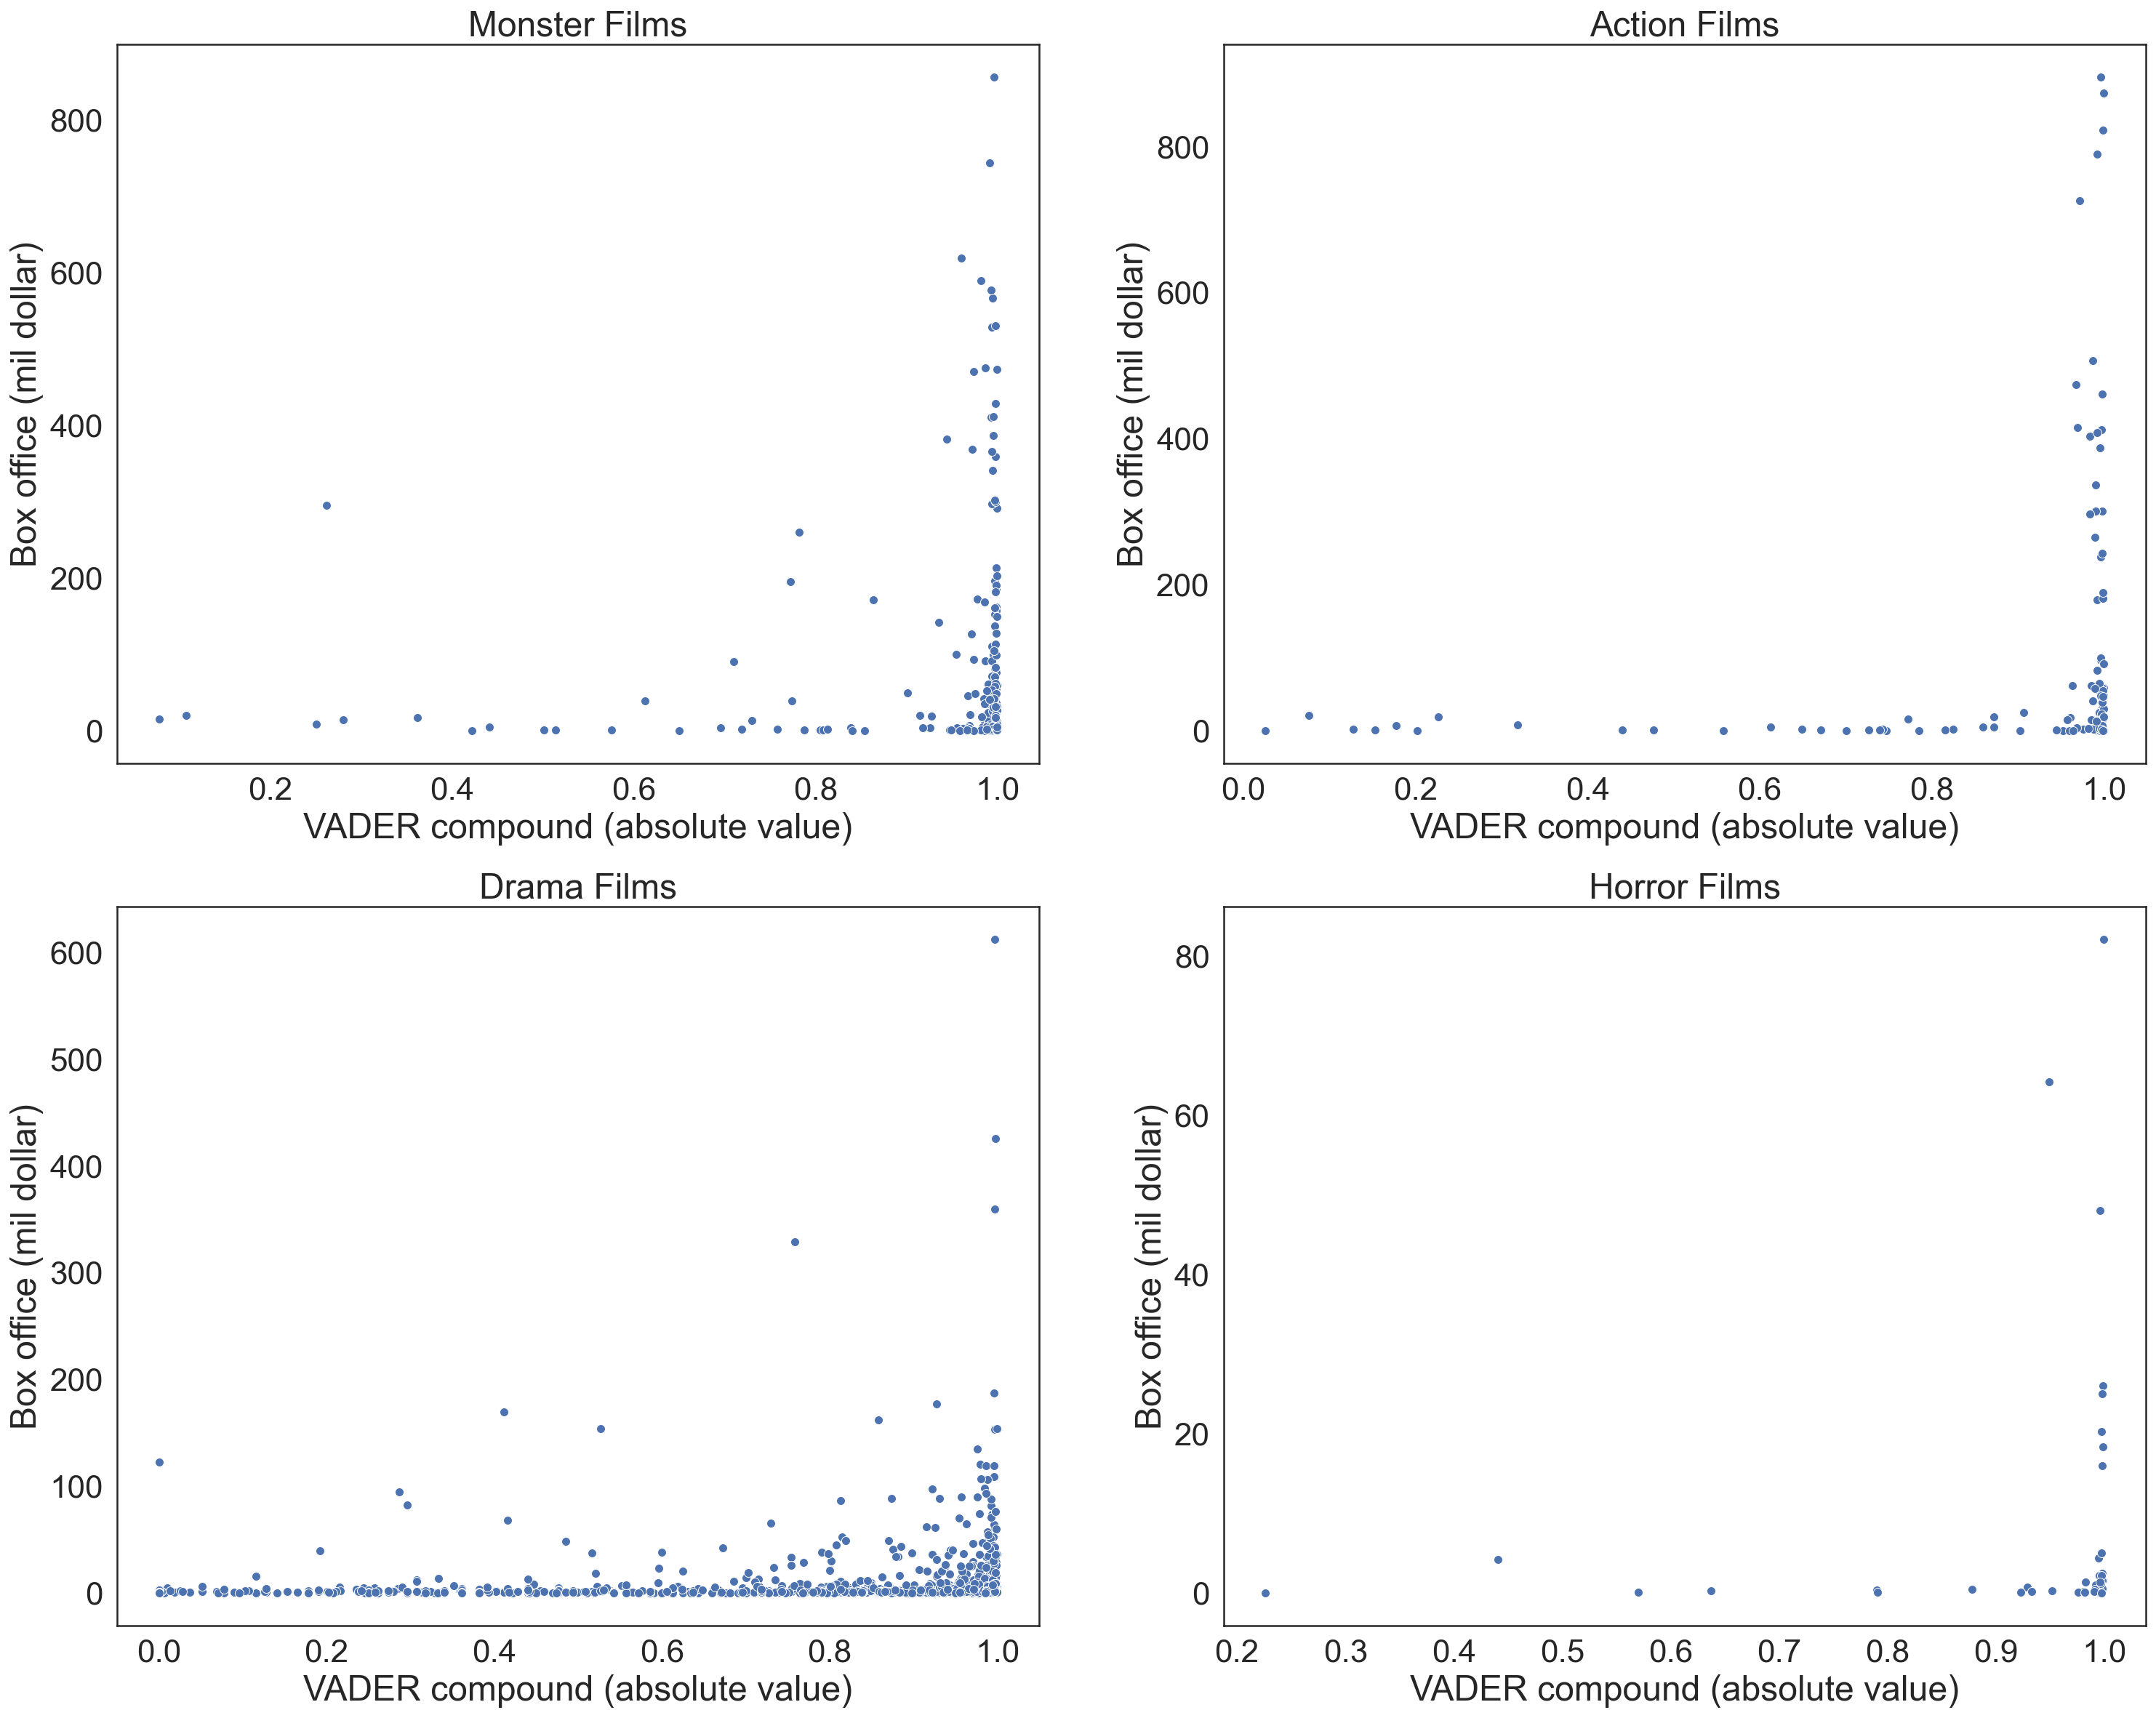

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
monster= df[df['Genre']=='Monster']
sns.scatterplot(data=monster, x='VADER compound (absolute value)', y= 'Box office (mil dollar)', ax=ax[0][0]).set(title='Monster Films')
action = df[df['Genre']=='Action']
sns.scatterplot(data=action, x='VADER compound (absolute value)', y= 'Box office (mil dollar)', ax=ax[0][1]).set(title='Action Films')
action = df[df['Genre']=='Action']
drama = df[df['Genre']=='Drama']
sns.scatterplot(data=drama, x='VADER compound (absolute value)', y= 'Box office (mil dollar)', ax=ax[1][0]).set(title='Drama Films')
action = df[df['Genre']=='Action']
horror = df[df['Genre']=='Horror']
sns.scatterplot(data=horror, x='VADER compound (absolute value)', y= 'Box office (mil dollar)', ax=ax[1][1]).set(title='Horror Films')
action = df[df['Genre']=='Action']


There appears to be an association between high VADER compound scores and high box office sales. However, there are also some outliers, and many high scores with low box office sales. 
From the figure, it seems like Action and Monster movies generally have movies with higher box plot sales and VADER compound scores. 

# Data Analysis & Results

In [67]:
df = pd.read_csv('American Films.csv')

Since our dependent variable `Box office (mil dollar)` is a numeric variable, we can consider analyzing it with regression models. 

One model we can consider is the linear regression model. However, to perform linear regression, we must check for the assumptions of linear regression (descriptions taken from Boston University):
- Linearity: The relationship between X and the mean of Y is linear.
- Homoscedasticity: The variance of residual is the same for any value of X.
- Independence: Observations are independent of each other.
- Normality: For any fixed value of X, Y is normally distributed.

Our hypothesis mentions the extremeness of the plot's sentiment, as measured by VADER and stored in the variable `VADER compound (absolute value)`. Earlier in our EDA section we have explored the linearity between `VADER compound (absolute value)` and `Box office (mil dollar)`, and the result is unclear. So we will perform a homoscedasticity check by plotting the residual of a linear model based on `VADER compound (absolute value)`.

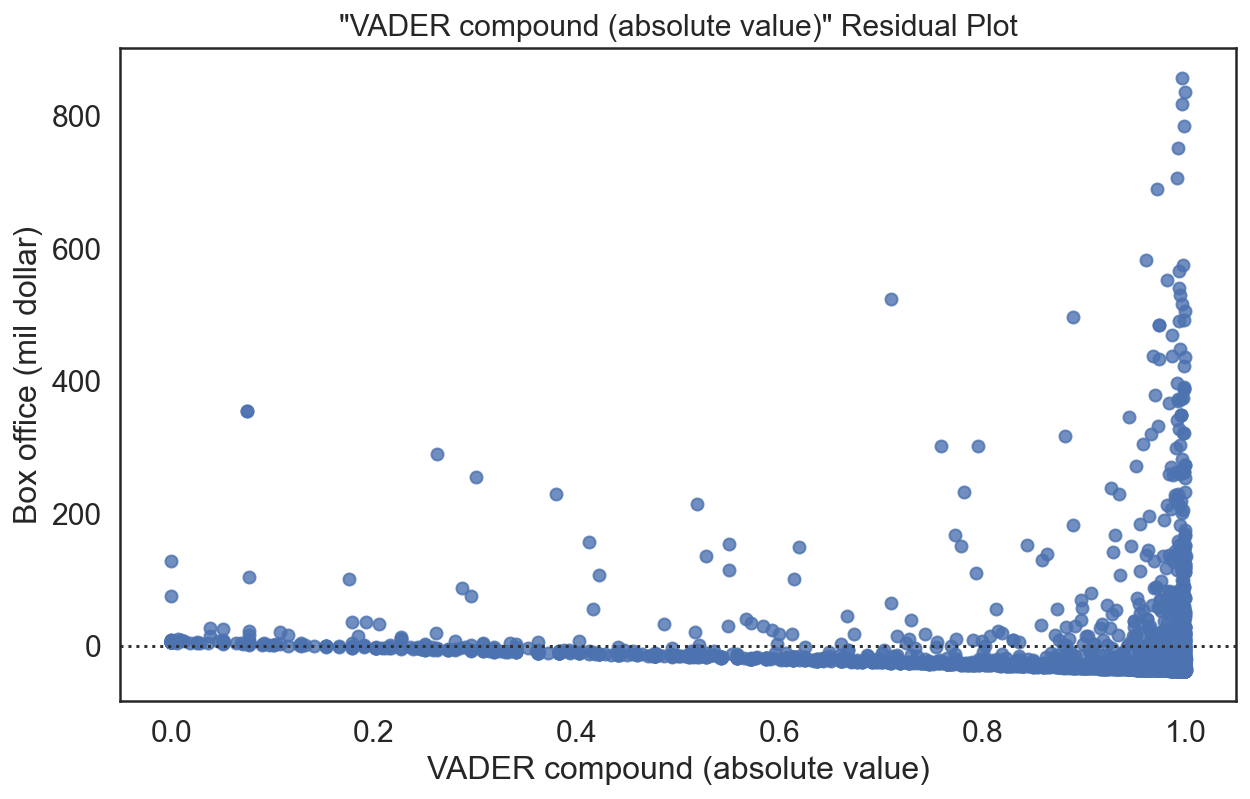

In [72]:
variable = 'VADER compound (absolute value)'

reg = smf.ols(formula=f'Q("Box office (mil dollar)") ~ Q("{variable}")', data=df).fit()

fig = plt.figure(figsize=(10, 6))
SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sns.residplot(x=variable, y='Box office (mil dollar)', data=df)
plt.title(f'"{variable}" Residual Plot')
plt.show()

The residual plot shows a highly uneven and strongly patterned spread around the 0 line, which is a sign that **our linear regression model failed the assumption of linearity**. On top of that, the residuals showed increasing variance as the x value increased, so **our linear regression model also failed the assumption of homoscedasticity**. Therefore, linear regression is not the best model for our data. 

However, our hypothesis test asked for the correlation between each variable and the film's box office sales, so we will still perform linear regression and compare the R-squared values for the sake of our hypothesis.

## Approach 1: Which factor has the highest correlation with "Box Office"?

In [73]:
import statsmodels.formula.api as smf 

In [74]:
variables = list(df.columns)
variables.remove('Film name')
variables.remove('Box office (mil dollar)')
variables.remove('Plot')
variables_df = pd.Series(variables).to_frame().rename(columns={0:'Variable'})

In [75]:
def get_rsquared(variable):
    reg = smf.ols(formula=f'Q("Box office (mil dollar)") ~ Q("{variable}")', data=df).fit() 
    return reg.rsquared

variables_df['R-squared'] = variables_df['Variable'].apply(get_rsquared)

In [76]:
print("According to R-squared values, the variables are ranked by correlation to box office sales (best to worst):")
variables_df.sort_values(by='R-squared', ascending=False)

According to R-squared values, the variables are ranked by correlation to box office sales (best to worst):


Variable  R-squared
3                          Story by   0.984943
2                        Written by   0.887921
1                       Directed by   0.829488
4                       Produced by   0.703538
7                         Edited by   0.671356
5                          Starring   0.664801
6                    Cinematography   0.564965
12              Budget (mil dollar)   0.554045
8                          Music by   0.396010
9                    Distributed by   0.304660
0                             Genre   0.096180
11                     Release year   0.057767
10                   Duration (min)   0.040204
17  VADER compound (absolute value)   0.014514
16                   VADER compound   0.010504
13                   VADER negative   0.007240
14                    VADER neutral   0.006358
19                TextBlob polarity   0.004266
18            TextBlob subjectivity   0.000607
15                   VADER positive   0.000041

### Approach 1: Results and Interpretation
The table above shows that categorical variables like `Story by`, `Written by`, and `Directed by`, have the highest correlation with box office sales, as shown by their extremely high r-squared values. However, the high correlation for `Story by` can be explained by the fact that there are very few films storied by the same person (the max a person has appeared in our dataset's `Story by` column is only 3 times, with most people appearing only once). The same idea applies to the other high correlation categorical variables. 

However, `Budget (mil dollar)` has the highest r-squared value among the quantitative variables, which seems reasonable. This scatter plot below shows the seemingly linear relationship between `Budget (mil dollar)` and `Box office (mil dollar)`.

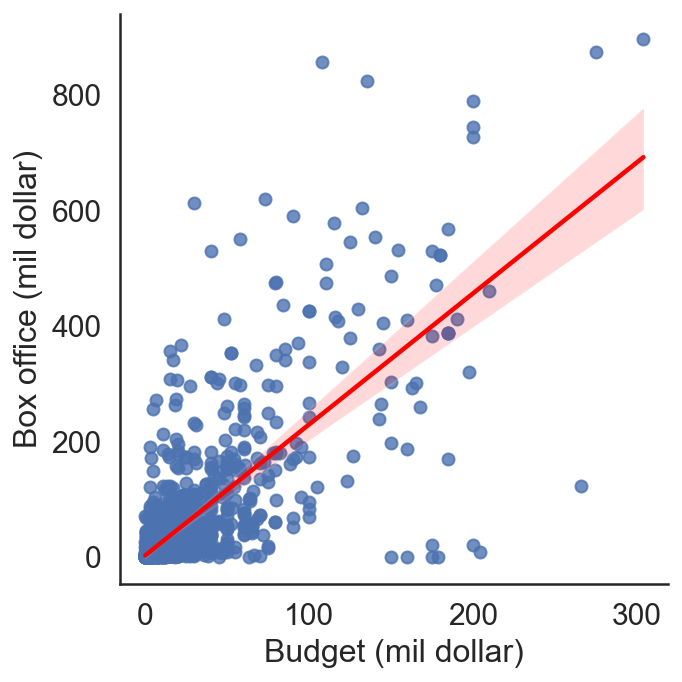

In [77]:
sns.lmplot(x='Budget (mil dollar)', y='Box office (mil dollar)', data=df, line_kws={'color': 'red'})

From our r-squared table above, we can see that `VADER compound (absolute value)` has a much lower r-squared value of around 0.015. This is supported by the regression line in the lmplot below: 

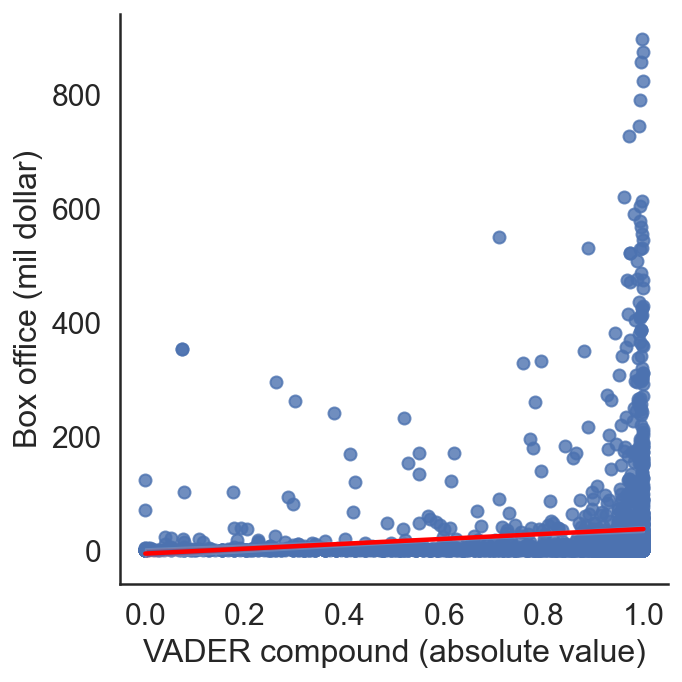

In [78]:
sns.lmplot(x='VADER compound (absolute value)', y='Box office (mil dollar)', data=df, line_kws={'color': 'red'})

**Our study on r-squared values conclude that the film plot's extremeness of sentiment does not have the highest linear correlation to box office sales.** But this may be explained by the fact that `VADER compound (absolute value)` is not linearly related to `Box office (mil dollar)`, but instead has a somewhat exponential relationship. See how the plot of `VADER compound (absolute value)` has a linear relationship with the ***log*** of `Box office (mil dollar)`.

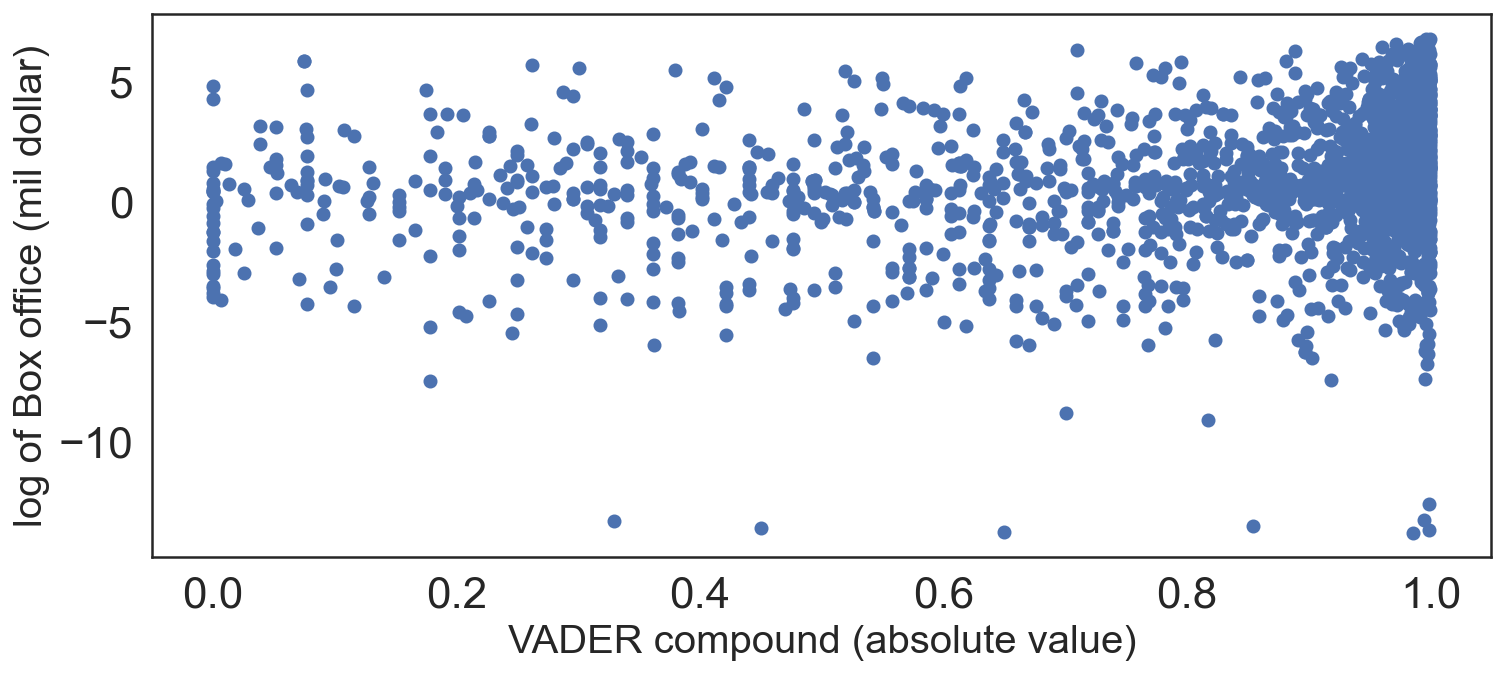

In [169]:
x = df['VADER compound (absolute value)']
y = df['Box office (mil dollar)']

plt.scatter(x, np.log(y))
plt.xlabel('VADER compound (absolute value)', fontsize=20)
plt.ylabel('log of Box office (mil dollar)', fontsize=20)
plt.show()

## Approach 2: Which factor predicts "Box Office" the best?

In [79]:
# Create training and testing dataset 
percent_train = 0.7
mask = np.random.rand(len(df)) < percent_train
train = df[mask]
test = df[~mask]

To identify which factor predicts "Box office (mil dollar)" the best, we will train a Decision Tree Regressor model for every independent variable in our dataset. 

We chose to use a Decision Tree Regressor because:
- the variables in this dataset are not linearly related to box office sales
- Decision Tree Regressor is well suited for non-linear problems
- Decision Tree Regressor can handle both categorical and numerical data
- Decision Tree Regressor does not require normalization and scaling of data

After splitting the dataset into training and testing sets, we will fit the Decision Tree Regressor on the training data, then  predict "Box office (mil dollar)" using the testing data. We We will measure how good the prediction is using Mean Squared Error (MSE). The lower the MSE, the more predictive the model is.

In [147]:
def get_dtree_results(variable):
    X_train = train[variable]
    y_train = train['Box office (mil dollar)']
    mask_to_remove_nan = X_train.isnull()
    X_train = np.array(X_train[~mask_to_remove_nan]).reshape(-1, 1)
    y_train = y_train[~mask_to_remove_nan]

    X_test = test[variable]
    y_test = test['Box office (mil dollar)']
    mask_to_remove_nan = X_test.isnull()
    X_test = np.array(X_test[~mask_to_remove_nan]).reshape(-1, 1)
    y_test = y_test[~mask_to_remove_nan]

    # If column contains string items, perform one hot encoding
    if df[variable].dtype == object:
        enc = OneHotEncoder(handle_unknown='ignore').fit(X_train)
        X_train = enc.transform(X_train).toarray()
        X_test = enc.transform(X_test).toarray()


    dtree = tree.DecisionTreeRegressor().fit(X_train, y_train)
    pred = dtree.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    return mse, X_test, pred, dtree

def get_MSE_of_dtree(variable):
    return get_dtree_results(variable)[0]

variables_df['MSE'] = variables_df['Variable'].apply(get_MSE_of_dtree)

In [150]:
print("According to MSE values, the variables are ranked by how well they predict box office sales with Decision Tree Regressor (best to worst):")

variables_df.sort_values(by='MSE')

According to MSE values, the variables are ranked by how well they predict box office sales with Decision Tree Regressor (best to worst):


Variable  R-squared           MSE
11                     Release year   0.057767   2160.718821
2                        Written by   0.887921   3491.209473
4                       Produced by   0.703538   5617.470156
12              Budget (mil dollar)   0.554045   5858.692351
9                    Distributed by   0.304660   6189.682111
1                       Directed by   0.829488   6909.765229
0                             Genre   0.096180   6961.638042
6                    Cinematography   0.564965   7463.889180
10                   Duration (min)   0.040204   7504.425756
8                          Music by   0.396010   7553.651689
5                          Starring   0.664801   7597.362415
7                         Edited by   0.671356   8118.817725
13                   VADER negative   0.007240   8249.520015
15                   VADER positive   0.000041   8384.828705
17  VADER compound (absolute value)   0.014514   9682.164727
14                    VADER neutral   0.006358   9693.097706
16                   VADER compound   0.010504  10719.795004
19                TextBlob polarity   0.004266  12904.909875
18            TextBlob subjectivity   0.000607  13022.634166
3                          Story by   0.984943  33992.551885

### Approach 2: Results and Interpretation
The mean squared error (MSE) of the prediction tells us how well we can predict box office sales based on that particular variable. The lower the MSE, the better the prediction.

`Release year` has the lowest MSE according to our model. This may be due to the box office dollar amount not being adjusted for the inflation over these decades. But this may also be explained by the increasing consumer demand for films and the increasing buying power.

Various categorical variables such as `Written by` and `Produced by` appear to be very good predictors. However, this may be due to how these variables have very few repeating values (e.g. `Written by` only has 181 out of 1207 values that appear more than once). Hence these variables almost function like unique indentifiers and are not very practical for making predictions in real life scenarios. 

`Budget (mil dollar)` is 4th in ranking, which seems reasonable, as a higher budget should lead to a higher box office.

`Duration` and `Genre` are also reasonable predictors for box office sales.

The variable in interest, `VADER compound (absolute value)` ranks very low. The plot's sentiment extremeness does not appear to be as good of a predictor as the other variables listed above. 

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

***Discuss your project. Summarize your data and question. Briefly describe your analysis. Summarize your results and conclusions. Be sure to mention any limitations of your project. Discuss the impact of this work on society. (~2-3 paragraphs)***

Our research question aimed to find out which factor, among factors such as director, genre, and sentiment analysis of the plot, has the highest correlation with American film's box office sale.

Before performing any analysis, we hypothesized that American films with more extreme sentiment values have a higher association with higher box office sales than other film characteristics because viewers are more enticed by dramatic film plots as opposed to mild or bland plots. 

We webscraped our whole dataset from Wikipedia page "American Films by Genre (https://en.wikipedia.org/wiki/Category:American_films_by_genre). It contains information on the film name, plot, genre, director, release year, duration, box office, and many other characteristics. 

We evaluated a plot's extremeness using VADER sentiment analysis. VADER provides a score between [-1, 1], with 1 being positive, 0 being neutral, and -1 being negative. `VADER compound (absolute value)` contains the absolute value of the VADER compound score, which quantifies the extremeness of the sentiment, with closer to 1 being more extreme and closer to 0 being less extreme. In our EDA, we discovered that `VADER compound (absolute value)` does *not* have a linear relationship with `Box office (mil dollar)`, which complicates our analysis.

For our analysis, we answered our research questions with two different approaches. In approach 1, we ranked the factors by their linear correlation to the box office sales, as calculated by their R-squared values. In approach 2, we ranked the factors by how well they individually predict the box office sales, as measured by their decision tree regressor MSEs. 

From approach 1, we concluded that `VADER compound (absolute value)` does not have the highest linear correlation to box office sales. But this may be explained by the fact that `VADER compound (absolute value)` is not linearly related to `Box office (mil dollar)`, but instead has a somewhat exponential relationship. 

From approach 2, we concluded that `VADER compound (absolute value)` does not appear to be as good of a predictor as most other variables in our dataset, so it is not as important of a factor in predicting box office sales. 

Our research was heavily limited by the sentiment analysis package as well as the source of plots. We relied on VADER's pre-labeled lexicon to accurately quantify the extremeness of a plot's sentiment, but realistically, we did not have the means and resources to prove that accuracy. Our decision to use Wikipedia plots as opposed to other sources like IMDb or Rotten Tomatoes also limited our research by relying on a potentially biased or outdated source. These limitations can be improved with a smarter and more accurate sentiment analysis package and a more comprehensive dataset.

# Team Contributions

*Specify who in your group worked on which parts of the project.*

Ester Tsai web scraped Wikipedia for the dataset, cleaned the dataset, performed the analysis, and wrote part of the conclusion.